# Task 2

Perform classification of protein types based on codon usage in SARS-CoV2.

- use the [data](alas.matf.bg.ac.rs) containing coding sequences and protein types, prepared from [NCBI Virus](https://www.ncbi.nlm.nih.gov/labs/virus/vssi/#/virus?SeqType_s=Nucleotide&VirusLineage_ss=SARS-CoV-2,%20taxid:2697049).

- use standard codon table from [The Genetic Codes](https://www.ncbi.nlm.nih.gov/Taxonomy/Utils/wprintgc.cgi).
Za SARS2 koristiti standardni kod (transl_table=1)

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz
import dalex as dx

from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, precision_recall_curve as prec_rec_crve, balanced_accuracy_score, classification_report

from mlxtend.evaluate import confusion_matrix as conf_matrx, RandomHoldoutSplit
from mlxtend.plotting import plot_confusion_matrix

from openTSNE import TSNE

from annoy import AnnoyIndex

from xgboost import XGBClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall

from scikeras.wrappers import KerasClassifier

from sklearn_genetic import ExponentialAdapter, GASearchCV
from sklearn_genetic.callbacks import DeltaThreshold
from sklearn_genetic.space import Categorical, Integer, Continuous

from yellowbrick.target import class_balance
from yellowbrick.target.feature_correlation import feature_correlation
from yellowbrick.features.pcoords import parallel_coordinates
from yellowbrick.features.radviz import radviz
from yellowbrick.classifier import confusion_matrix, precision_recall_curve
from yellowbrick.model_selection import feature_importances
from yellowbrick.contrib.wrapper import classifier

In [2]:
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=PendingDeprecationWarning)

stop = 5
start = 7

tous = 11
pops = 31
seed = 196883

sample = 4224
maxiter = np.iinfo(np.int32).max

t_stop = 1e-4
t_sample = 0.2

a_rate = 0.1
m_prob = 0.2
c_prob = 0.8

n_features = 7

np.random.seed(seed)

## Priprema podataka

Učitavamo podatke sa jedinstvenim kodirajućim sekvencama proteina SARS-CoV-2.

In [3]:
df = pd.read_csv('samo_jedinstvene_kodirajuce_sekvence.csv', header=None, on_bad_lines='warn')

In [4]:
df.shape

(889737, 15)

In [5]:
df.head()

0           1     2      3      4      5      6   \
0  BCA87360.1  LC528232.2  join    249  13451  13451  21538   
1  BCA87379.1  LC528233.2  raw   29551  29667      0      0   
2  BCB15089.1  LC529905.1  join    266  13468  13468  21555   
3  BCB15091.1  LC529905.1  raw   25393  26220      0      0   
4  BCB15098.1  LC529905.1  raw   28274  29533      0      0   

                           7    8                          9      10     11  \
0  2020-02-29-00.00.00.000000    B  4.1.2/1.12/v0.1.10/0.3.17  21291  21291   
1  2020-02-29-00.00.00.000000  B.5  4.1.2/1.12/v0.1.10/0.3.17    117    117   
2  2020-03-07-00.00.00.000000    B  4.1.2/1.12/v0.1.10/0.3.17  21291  21291   
3  2020-03-07-00.00.00.000000    B  4.1.2/1.12/v0.1.10/0.3.17    828    828   
4  2020-03-07-00.00.00.000000    B  4.1.2/1.12/v0.1.10/0.3.17   1260   1260   

                            12        13  \
0           ORF1ab polyprotein  20200210   
1                ORF10 protein  20200210   
2           ORF1ab polyprotein  20200115   
3                ORF3a protein  20200115   
4  nucleocapsid phosphoprotein  20200115   

                                                  14  
0  ATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAAC...  
1  ATGGGCTATATAAACGTTTTCGCTTTTCCGTTTACGATATATAGTC...  
2  ATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAAC...  
3  ATGGATTTGTTTATGAGAATCTTCACAATTGGAACTGTAACTTTGA...  
4  ATGTCTGATAATGGACCCCAAAATCAGCGAAATGCACCCCGCATTA...

Izdvajamo kolonu sa kodirajućim sekvencama i kolonu sa oznakama tipova proteina.

In [6]:
df = df[[14, 12]]
df.shape

(889737, 2)

### Čišćenje podataka

Proveravamo da li su kodirajuće sekvence odgovarajuće dužine.
One koje nisu, odbacujemo.

In [7]:
length = np.array([len(a) for a in df[14]])
valid = (length > 8) & (length % 3 == 0)

df = df[valid]
df.shape

(889695, 2)

Proveravamo da li se kodirajuće sekvence sastoje samo od slova A, T, C i G.
Sekvence koje ne ispunjavaju ovaj uslov odbacujemo.

In [8]:
valid = df[14].map(lambda a: set(a).issubset(set('ATCG')))

df = df[valid]
df.shape

(869874, 2)

Proveravamo koliko instanci imamo u svakoj klasi.
Odnosno koliko sekvenci imamo za svaki tip proteina.
Klase koje sadrže 64 instanci i manje odbacujemo zajedno sa instancom.

In [9]:
proteins = df.groupby([12])[12].count()
valid = np.array([proteins[a] for a in df[12]]) > 64

df = df[valid]
df.shape

(869858, 2)

Nakon čišćenja podataka, od jedinstvenih 889737 kodirajućih ostalo nam je 869858 instanci.
Ukupno 19879 instanci je odbačeno kao nevalidno, odnosno oko $2.23\%$ skupa jedinstvenih kodirajućih sekvenci.

### Izračunavanje upotrebe kodona

Računamo koliko često neki kodon kodira svoju amino-kiselinu u svakoj kodirajućoj sekvenci.

Potrebna nam je standardna tabela kodona.

In [10]:
standard_codon_table = {
    'TTT': 'F', 'TCT': 'S', 'TAT': 'Y', 'TGT': 'C',
    'TTC': 'F', 'TCC': 'S', 'TAC': 'Y', 'TGC': 'C',
    'TTA': 'L', 'TCA': 'S', 'TAA': 'O', 'TGA': 'O',
    'TTG': 'L', 'TCG': 'S', 'TAG': 'O', 'TGG': 'W',

    'CTT': 'L', 'CCT': 'P', 'CAT': 'H', 'CGT': 'R',
    'CTC': 'L', 'CCC': 'P', 'CAC': 'H', 'CGC': 'R',
    'CTA': 'L', 'CCA': 'P', 'CAA': 'Q', 'CGA': 'R',
    'CTG': 'L', 'CCG': 'P', 'CAG': 'Q', 'CGG': 'R',

    'ATT': 'I', 'ACT': 'T', 'AAT': 'N', 'AGT': 'S',
    'ATC': 'I', 'ACC': 'T', 'AAC': 'N', 'AGC': 'S',
    'ATA': 'I', 'ACA': 'T', 'AAA': 'K', 'AGA': 'R',
    'ATG': 'M', 'ACG': 'T', 'AAG': 'K', 'AGG': 'R',

    'GTT': 'V', 'GCT': 'A', 'GAT': 'D', 'GGT': 'G',
    'GTC': 'V', 'GCC': 'A', 'GAC': 'D', 'GGC': 'G',
    'GTA': 'V', 'GCA': 'A', 'GAA': 'E', 'GGA': 'G',
    'GTG': 'V', 'GCG': 'A', 'GAG': 'E', 'GGG': 'G'
}

Potrebna nam je i inverzna tabela kodona.

In [11]:
inverse_codon_table = {
    'F': ('TTT', 'TTC'),
    'L': ('CTT', 'CTC', 'CTA', 'CTG', 'TTA', 'TTG'),
    'I': ('ATT', 'ATC', 'ATA'),
    'M': ('ATG', ),
    'V': ('GTT', 'GTC', 'GTA', 'GTG'),
    'S': ('TCT', 'TCC', 'TCA', 'TCG', 'AGT', 'AGC'),
    'P': ('CCT', 'CCC', 'CCA', 'CCG'),
    'T': ('ACT', 'ACC', 'ACA', 'ACG'),
    'A': ('GCT', 'GCC', 'GCA', 'GCG'),
    'Y': ('TAT', 'TAC'),
    'O': ('TAA', 'TGA', 'TAG'),
    'H': ('CAT', 'CAC'),
    'Q': ('CAA', 'CAG'),
    'N': ('AAT', 'AAC'),
    'K': ('AAA', 'AAG'),
    'D': ('GAT', 'GAC'),
    'E': ('GAA', 'GAG'),
    'C': ('TGT', 'TGC'),
    'W': ('TGG', ),
    'R': ('CGT', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'),
    'G': ('GGT', 'GGC', 'GGA', 'GGG')
}

Za svaku sekvencu brojimo koliko sadrži kodona.

In [12]:
def count_codons(seq):
    seq = seq[14]
    
    codon_counts = {a: 0 for a in standard_codon_table.keys()}
    
    for i in range(0, len(seq) - 2, 3):
        codon = seq[i:i+3]
        codon_counts[codon] += 1
    
    return codon_counts

codon_counts = df[[14]].apply(count_codons, axis=1, result_type='expand').to_dict('list')
codon_counts = {key: np.array(val, dtype='float64') for key, val in codon_counts.items()}

Za prebrojavanje amino-kiselina u prevedenim sekvencama, nećemo eksplicitno prevoditi sekvence i brojati.
Iskoristićemo činjenicu da smo već izbrojali kodone u kodirajućim sekvencama.
Sada ostaje da za svaku amino-kiselinu saberemo broj kodona koji ih kodiraju, za svaku sekvencu.

In [13]:
length = df.shape[0]

amino_counts = {a: np.zeros(length) for a in inverse_codon_table.keys()}

for amino, codons in inverse_codon_table.items():
    for codon in codons:
        amino_counts[amino] += codon_counts[codon]

Neka se kodon *X* pojavljuje *x* puta u nekoj sekvenci i kodira amino-kiselinu *Y*.
U prevedenoj sekvenci, nakon transkripcije i translacije, amino-kiselina *Y* se pojavljuje *y* puta.
Vrednost
$$
f(X) = \frac{x}{y}
$$
predstavlja upotrebu kodona *X*.

Postoje sekvence koje ne kodiraju sve amino-kiseline, što prilikom primene formule dovodi do deljenja nulom i dodele *NaN* vrednosti.
Zamenićemo *NaN* vrednosti nulom.

In [14]:
for codon in standard_codon_table.keys():
    codon_counts[codon] /= amino_counts[standard_codon_table[codon]]
    np.nan_to_num(codon_counts[codon], copy=False, nan=0, posinf=0, neginf=0) # ako delimo nulom

### Završna priprema podataka i podela na skupove

Rečnik sa vrednostima upotrebe kodona prevodimo u pogodniji format za rad sa tabelarnim podacima.
Odbacujemo podatke o upotrebi stop kodona.

In [15]:
X = pd.DataFrame(codon_counts)
X.drop(['TAA', 'TGA', 'TAG', 'ATG'], axis=1, inplace=True)

y = df[12]
y.name = 'Protein'

df = X.join(y, validate='one_to_one')

cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

# df.to_csv('proteini_ucestalost_kodona.csv', index=False)
df.head()

Protein       TTT       TCT       TAT       TGT  \
0           ORF1ab polyprotein  0.728571  0.337719  0.620896  0.814159   
1                ORF10 protein  0.750000  0.500000  1.000000  0.000000   
2           ORF1ab polyprotein  0.727794  0.337719  0.620896  0.814159   
3                ORF3a protein  0.571429  0.136364  0.470588  0.428571   
4  nucleocapsid phosphoprotein  0.230769  0.210526  0.181818  0.000000   

        TTC       TCC       TAC       TGC       TTA  ...       GAC       GGC  \
0  0.271429  0.059211  0.379104  0.185841  0.301349  ...  0.354756  0.152913   
1  0.250000  0.000000  0.000000  1.000000  0.000000  ...  0.000000  1.000000   
2  0.272206  0.059211  0.379104  0.185841  0.300898  ...  0.354756  0.152913   
3  0.428571  0.181818  0.529412  0.571429  0.103448  ...  0.461538  0.214286   
4  0.769231  0.078947  0.818182  0.000000  0.074074  ...  0.416667  0.372093   

        GTA       GCA       GAA       GGA       GTG       GCG       GAG  \
0  0.229097  0.268994  0.729412  0.184466  0.147157  0.032854  0.270588   
1  0.500000  0.500000  0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.229097  0.268994  0.729412  0.184466  0.147157  0.032854  0.270588   
3  0.269231  0.230769  0.909091  0.285714  0.038462  0.000000  0.090909   
4  0.125000  0.216216  0.666667  0.302326  0.250000  0.081081  0.333333   

        GGG  
0  0.024272  
1  0.000000  
2  0.024272  
3  0.000000  
4  0.093023  

[5 rows x 61 columns]

Pravimo enkoder koji kateogričkim ciljnim podacima dodeljuje celobrojne vrednosti.

In [16]:
enc = LabelEncoder()
_ = enc.fit(y.unique())

In [17]:
ohe = LabelBinarizer()
_ = ohe.fit(y.unique())

Konačno, delimo podatke na podatke za test i trening skupove.
Test skup će se sadržati 20% podataka, a ostatak će sadržati trening skup.
Pravimo stratifikovanu podelu, kako bi sve klase bile jednako zastupljene u test i trening skupu.
Dalje u analizi ćemo se fokusirati na trening skup.
Test skup ćemo koristiti isključivo za proveru modela.
U svim ostalim situacijama ponašamo se kao da test skup ne postoji.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

A small training data sample that will be used for certain visualization techniques.

In [19]:
train_sample = X_train.join(y_train, validate='one_to_one').groupby(['Protein']).sample(8, random_state=seed).reset_index(drop=True)

X_train_sample = train_sample.drop(['Protein'], axis=1)
y_train_sample = train_sample['Protein']

Long form of the small sampled training data set.

In [20]:
shape = train_sample.shape[0] * (train_sample.shape[1] - 1)

train_sample_long = {
    'index': np.empty(shape, np.int32),
    'codon': [None for _ in range(shape)],
    'usage': np.empty(shape, np.float64),
    'protein': [None for _ in range(shape)]
}

j = 0
for i, s in X_train_sample.iterrows():
    for codon, freq in s.items():
        train_sample_long['index'][j] = i
        train_sample_long['codon'][j] = codon
        train_sample_long['usage'][j] = freq
        train_sample_long['protein'][j] = y_train_sample.iloc[i]
        j += 1

train_sample_long = pd.DataFrame(train_sample_long)

## Data vizualization

The classes are very unbalanced.
About $79\%$ instances belong to *ORF1ab* i *ORF1a*.
More than $95\%$ of instances are in five, out of total twelve classes.

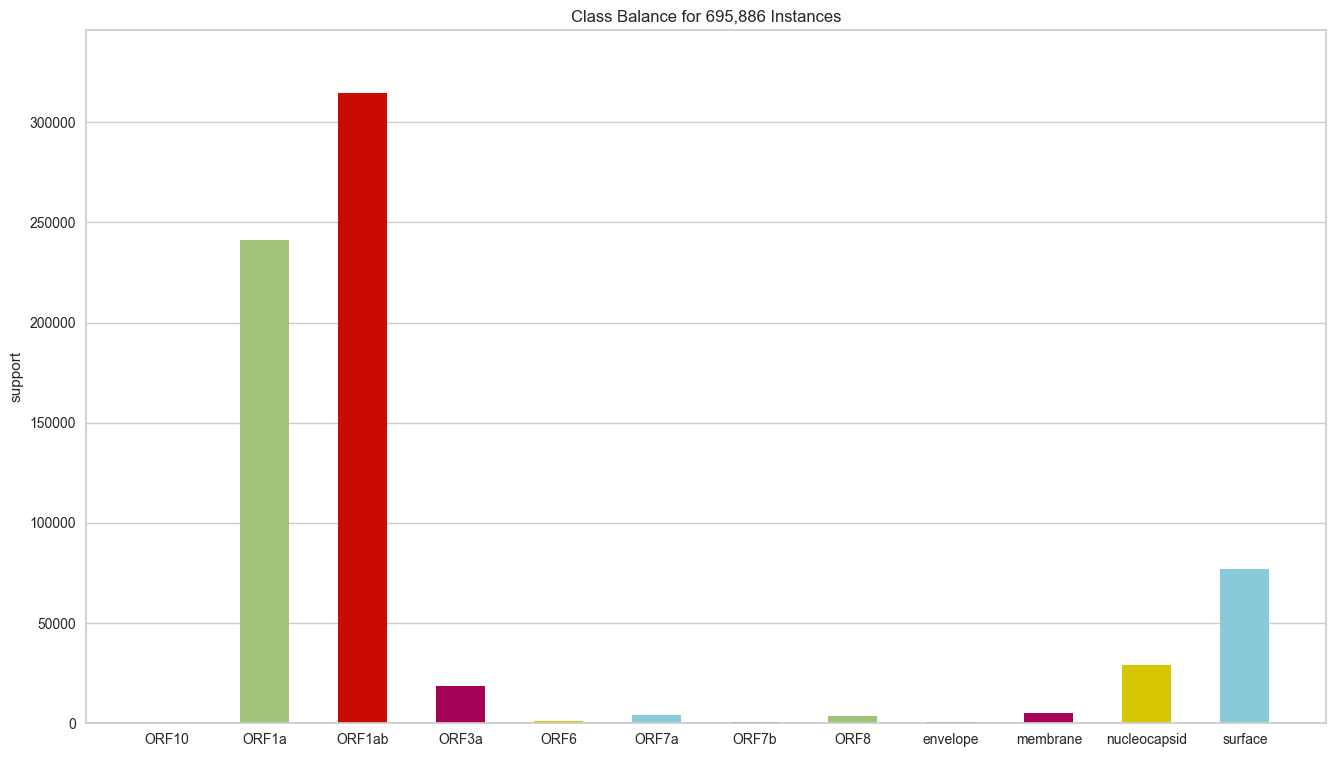

In [21]:
_ = plt.figure(figsize=(16, 9))

_ = class_balance(y_train,
                  labels=[a.split()[0] for a in enc.classes_])

### Stats for target and features

We will look at correlations between target variable and the features to see if there are any variables that stand out.

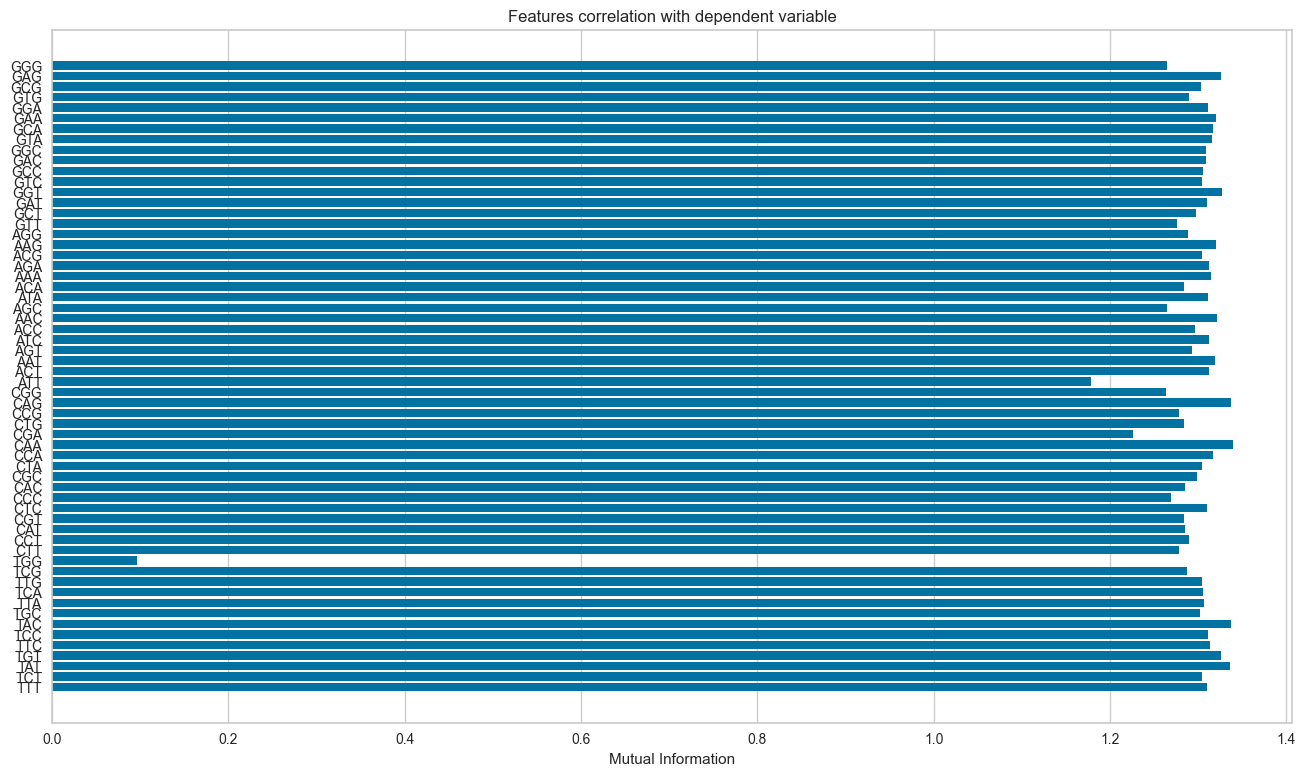

In [22]:
_ = plt.figure(figsize=(16, 9))

_ = feature_correlation(X=X_train,
                        y=y_train,
                        method='mutual_info-classification')

### Parallel Coordinates

Certainly this is an interesting looking plot.
Its usefulness leaves some doubts, though.

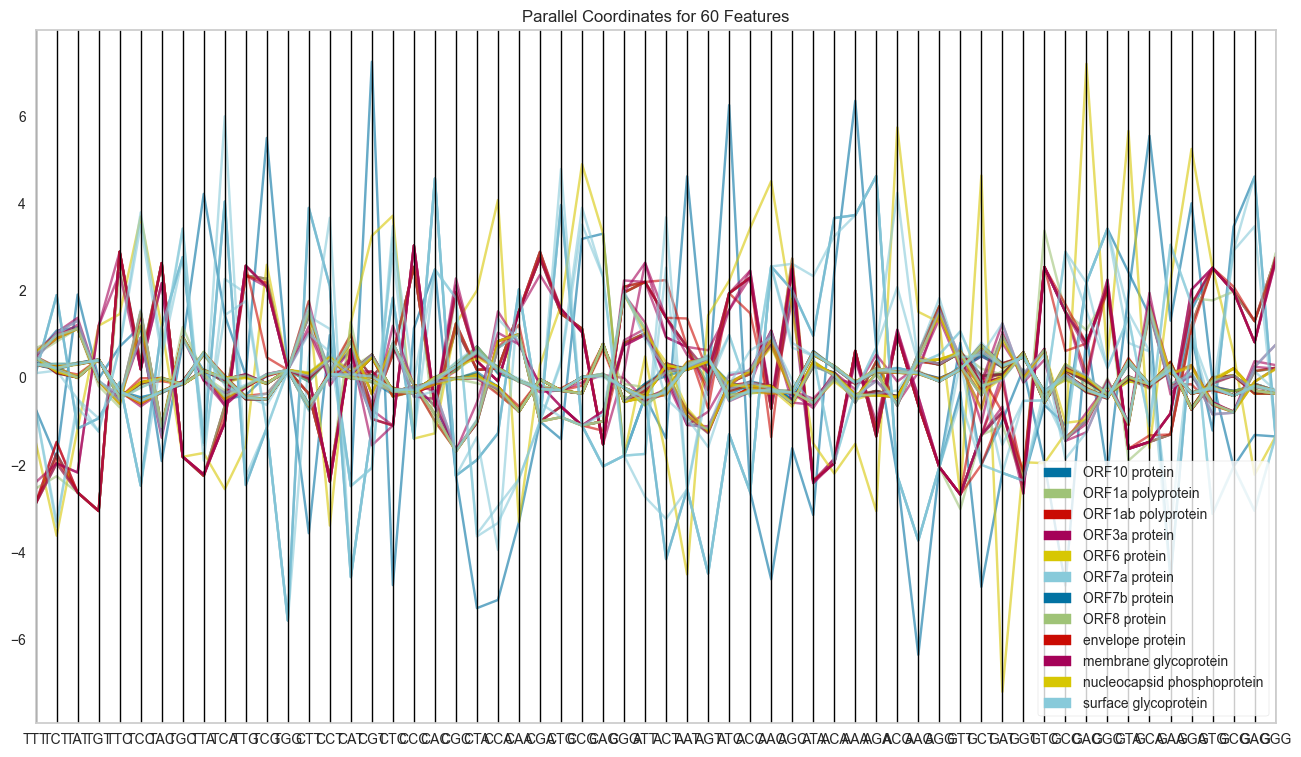

In [23]:
_ = plt.figure(figsize=(16, 9))

_ = parallel_coordinates(X=X_train_sample,
                         y=y_train_sample,
                         alpha=0.6,
                         normalize='standard')

### Radar Chart

Just like parallel coordinates, but a bit different.
Abstract art.
Although there are some overlappings, classes appear to be separable.

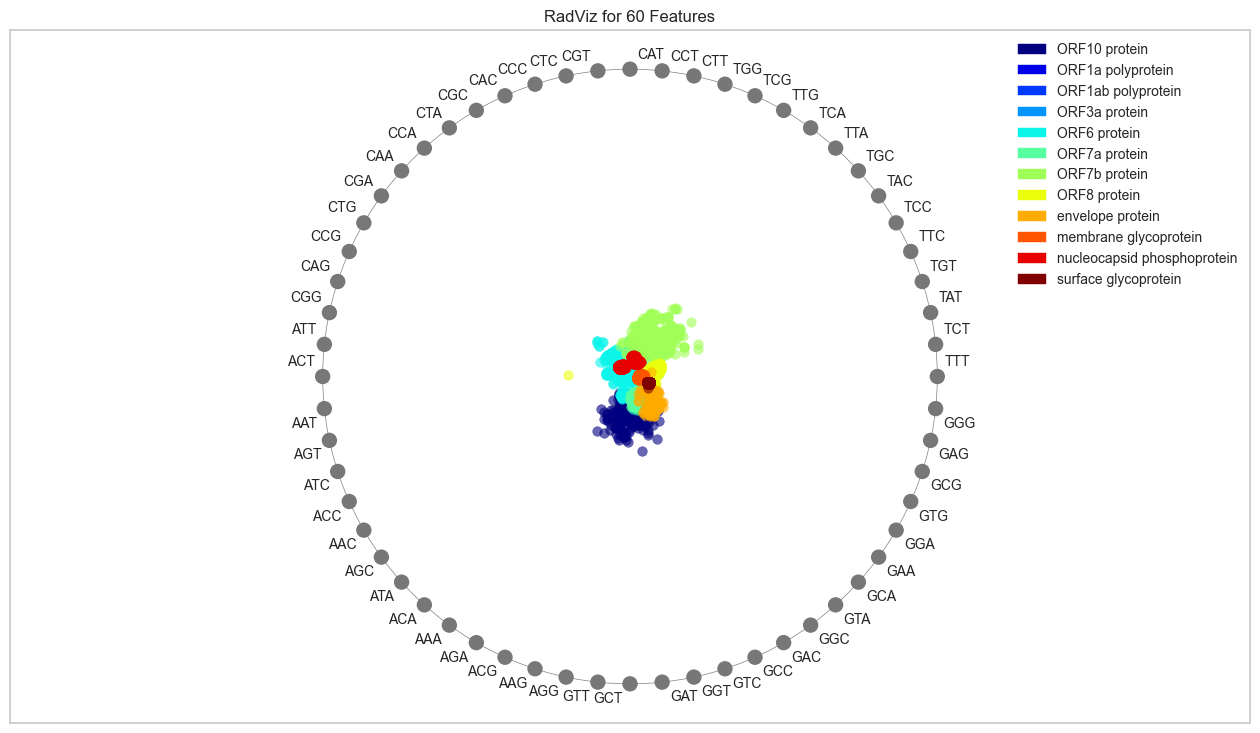

In [24]:
_ = plt.figure(figsize=(16, 9))

_ = radviz(X=X_train,
       y=enc.transform(y_train),
       classes=enc.classes_,
       alpha=0.6,
       colormap='jet')

### t-SNE

T-distributed stochastic neighbor embedding, shorter t-SNE, is nonlinear algorithm for dimensionality reduction.
Due to its stochastic nature, this algorithm is suitable only for data visualization.

In [25]:
tsne = TSNE(n_components=2,
            perplexity=48,
            exaggeration=4,
            n_iter=8192,
            early_exaggeration_iter=1024,
            n_jobs=-1, metric='manhattan',
            learning_rate='auto',
            initialization='random',
            random_state=seed)

X_train_tsne = tsne.fit(X_train.to_numpy())

Classes separate without overlapping, which is a good result, and promisses good classification.

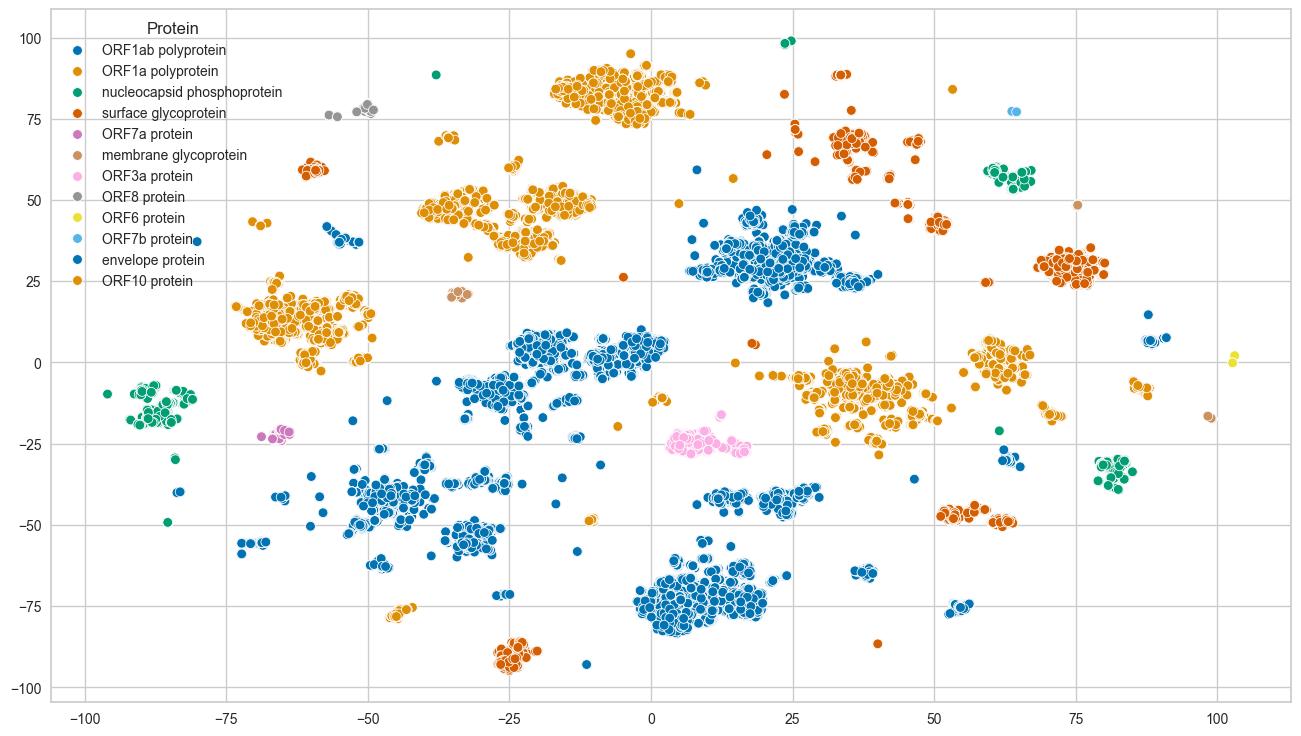

In [26]:
_ = plt.figure(figsize=(16, 9))

ax = sns.scatterplot(x=X_train_tsne[:, 0],
                     y=X_train_tsne[:, 1],
                     hue=y_train,
                     palette='colorblind')

plt.show()

## Training and evaluation

For parameter tuning we will use cross-validation.
For cross-validation *balanced accuracy* metric will be used.

During the evaluation we will observe model performance on training and test datasets.
Aside from classification report with metrics, we will look at confusion matrices and precision-recall curves.
Finally, we will take a look at feature importances.

First, let us write some utilities.

In [27]:
labels2display = np.array([a.split(' ', 1)[0] for a in enc.classes_])

In [28]:
mutation_adapter = ExponentialAdapter(initial_value=c_prob,
                                      end_value=m_prob,
                                      adaptive_rate=a_rate)

In [29]:
crossover_adapter = ExponentialAdapter(initial_value=m_prob,
                                       end_value=c_prob,
                                       adaptive_rate=a_rate)

In [30]:
stopping_condition = DeltaThreshold(threshold=t_stop,
                                    generations=stop,
                                    metric='fitness_max')

In [31]:
early_stopping = EarlyStopping(monitor='loss',
                               min_delta=t_stop,
                               patience=stop,
                               start_from_epoch=start,
                               restore_best_weights=True)

In [32]:
cross_validation_generator = RandomHoldoutSplit(valid_size=0.2,
                                                random_seed=seed,
                                                stratify=True)

In [33]:
def display_best_parameters(estimator):
    print(', '.join([f'{a}: {b}' for a, b in estimator.best_params_.items()]))

### Complement Naive Bayes Classifier

Parameters for cross-validation.

In [34]:
params = {'alpha': Continuous(1e-3, 1e3, random_state=seed)}

Applying genetic search cross-validation algorithm.

In [35]:
clf = GASearchCV(ComplementNB(),
                 param_grid=params,
                 scoring='balanced_accuracy',
                 population_size=pops,
                 generations=maxiter,
                 tournament_size=tous,
                 elitism=True,
                 crossover_probability=crossover_adapter,
                 mutation_probability=mutation_adapter,
                 cv=cross_validation_generator,
                 algorithm='eaSimple',
                 n_jobs=-1,
                 verbose=False)

_ = clf.fit(X_train,
            y_train,
            callbacks=stopping_condition)

INFO: DeltaThreshold callback met its criteria
INFO: Stopping the algorithm


Parameters of the best model.

In [36]:
display_best_parameters(clf)

alpha: 6.492641141944923


Classification report for training data.

In [37]:
print(classification_report(y_true=y_train,
                            y_pred=clf.predict(X_train),
                            digits=5,
                            zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    0.00000   0.00000   0.00000       364
          ORF1a polyprotein    0.99994   1.00000   0.99997    241372
         ORF1ab polyprotein    0.99518   1.00000   0.99758    314439
              ORF3a protein    0.93516   1.00000   0.96649     18476
               ORF6 protein    0.00000   0.00000   0.00000      1098
              ORF7a protein    1.00000   0.87122   0.93118      3937
              ORF7b protein    0.00000   0.00000   0.00000       743
               ORF8 protein    1.00000   0.61107   0.75859      3831
           envelope protein    0.00000   0.00000   0.00000       658
      membrane glycoprotein    0.00000   0.00000   0.00000      5083
nucleocapsid phosphoprotein    0.82900   1.00000   0.90651     29103
       surface glycoprotein    0.98561   1.00000   0.99275     76782

                   accuracy                        0.98571    695886
                  macro avg    0

Confusion matrix for training data.

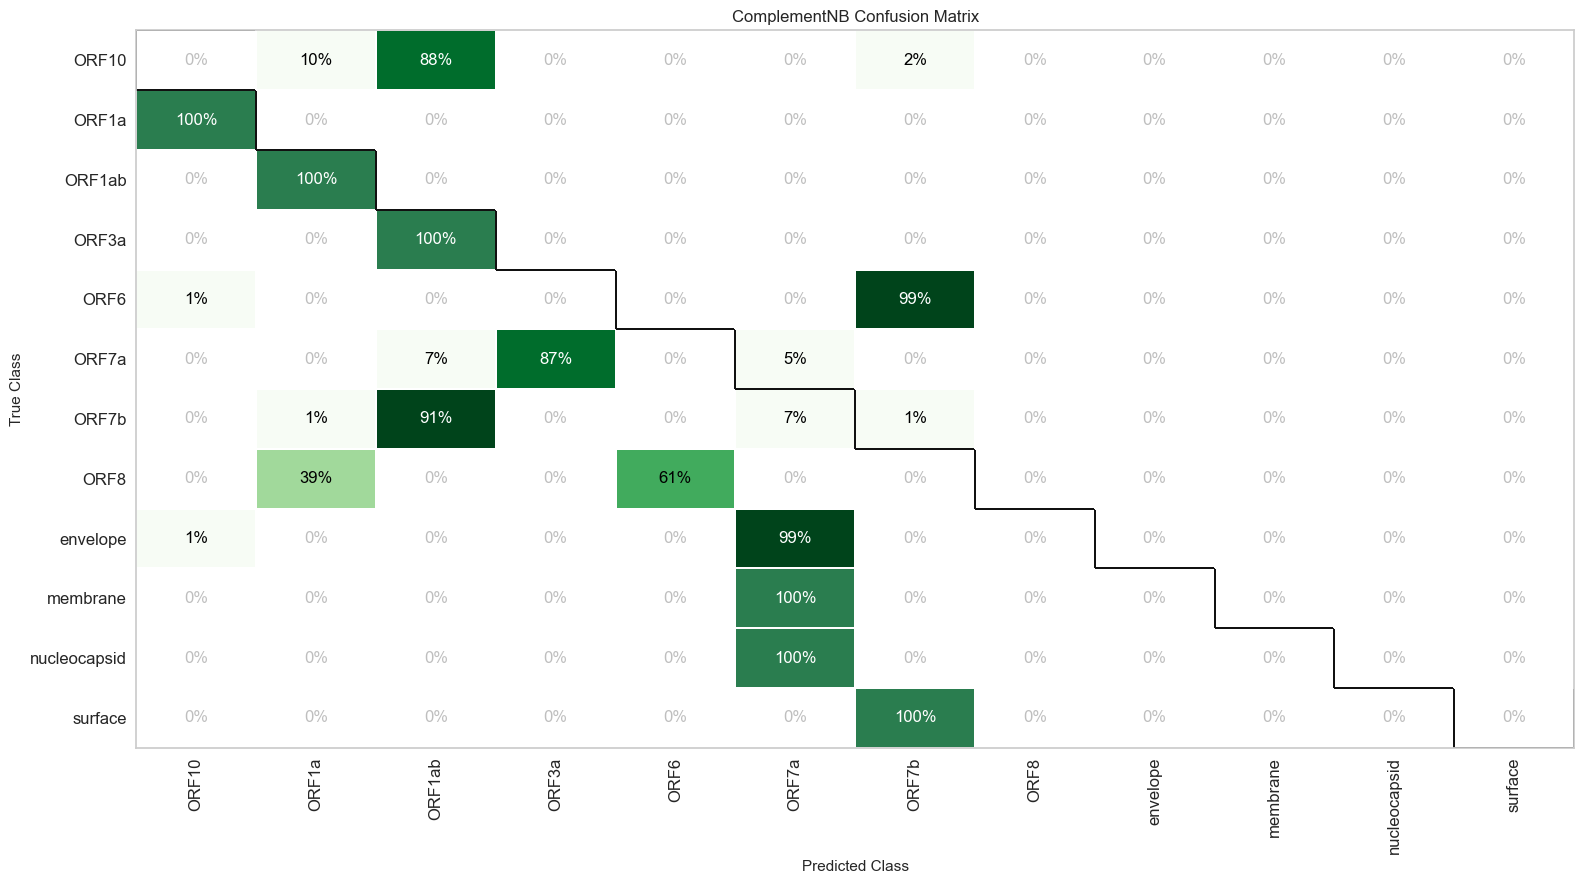

In [38]:
_ = plt.figure(figsize=(16, 9))

_ = confusion_matrix(clf.best_estimator_,
                     X_train,
                     y_train,
                     classes=labels2display,
                     cmap='Greens',
                     percent=True,
                     is_fitted=True)

Precision-recall curves for training data.

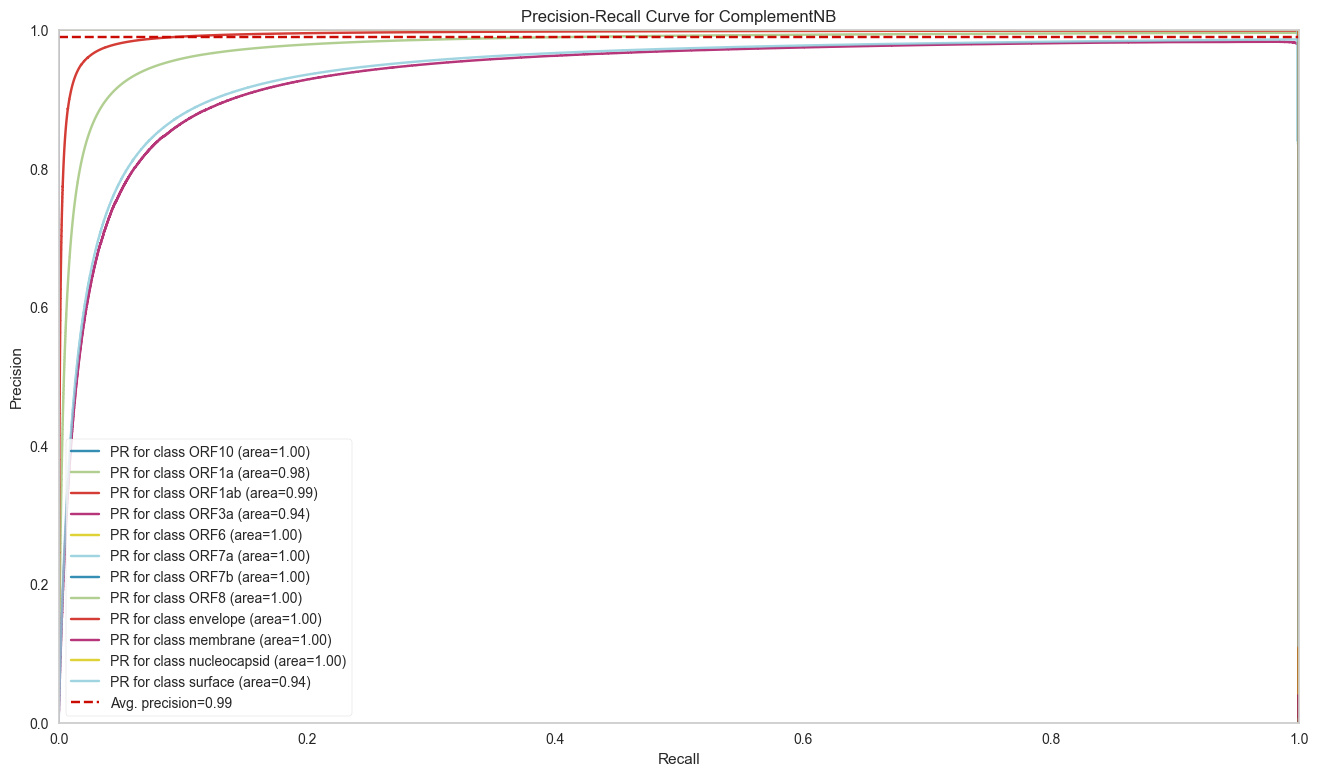

In [39]:
_ = plt.figure(figsize=(16, 9))

_ = precision_recall_curve(clf.best_estimator_,
                           X_train,
                           y_train,
                           per_class=True,
                           classes=labels2display)

Classification report for test data.

In [40]:
print(classification_report(y_true=y_test,
                            y_pred=clf.predict(X_test),
                            digits=5,
                            zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    0.00000   0.00000   0.00000        91
          ORF1a polyprotein    0.99992   1.00000   0.99996     60343
         ORF1ab polyprotein    0.99481   1.00000   0.99740     78610
              ORF3a protein    0.93502   1.00000   0.96642      4619
               ORF6 protein    0.00000   0.00000   0.00000       274
              ORF7a protein    1.00000   0.86687   0.92869       984
              ORF7b protein    0.00000   0.00000   0.00000       186
               ORF8 protein    1.00000   0.58559   0.73864       958
           envelope protein    0.00000   0.00000   0.00000       164
      membrane glycoprotein    0.00000   0.00000   0.00000      1271
nucleocapsid phosphoprotein    0.82955   1.00000   0.90684      7276
       surface glycoprotein    0.98547   1.00000   0.99268     19196

                   accuracy                        0.98555    173972
                  macro avg    0

Confusion matrix for test data.

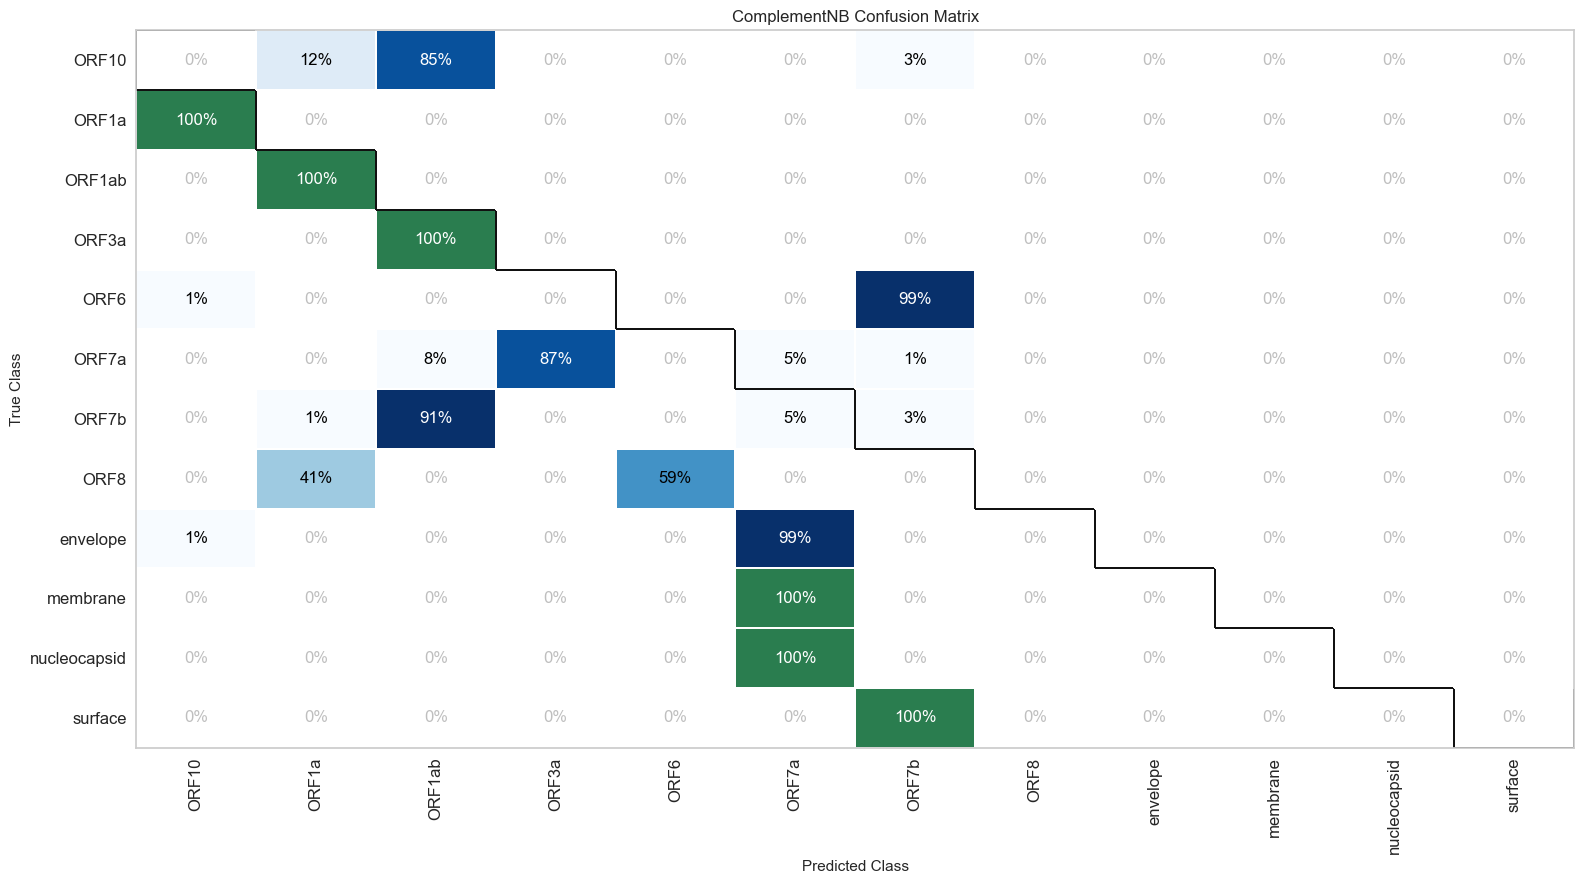

In [41]:
_ = plt.figure(figsize=(16, 9))

_ = confusion_matrix(clf.best_estimator_,
                     X_test,
                     y_test,
                     classes=labels2display,
                     cmap='Blues',
                     percent=True,
                     is_fitted=True)

Precision-recall curves for test data.

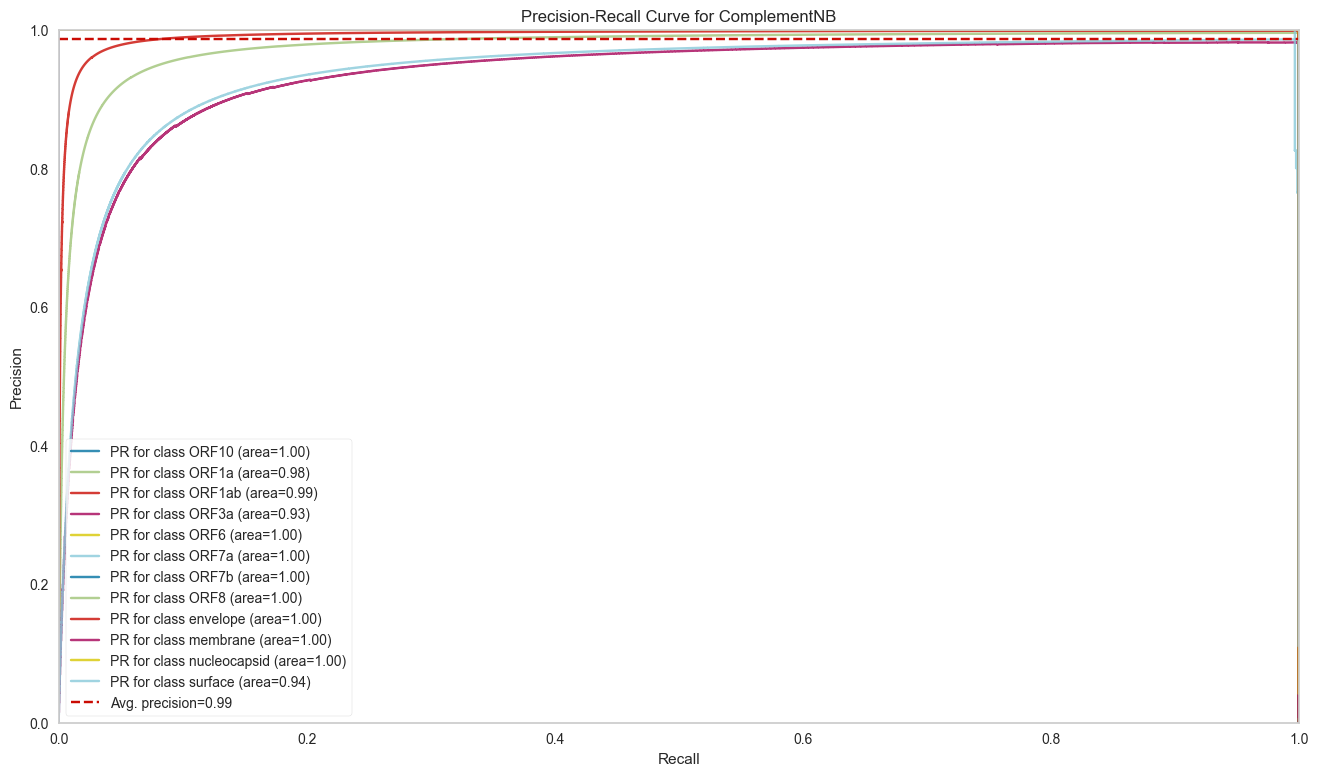

In [42]:
_ = plt.figure(figsize=(16, 9))

_ = precision_recall_curve(clf.best_estimator_,
                           X_test,
                           y_test,
                           per_class=True,
                           classes=labels2display)

Važnost atributa za test skup.

In [43]:
explainer = dx.Explainer(clf.best_estimator_,
                         X_train_sample,
                         enc.transform(y_train_sample),
                         predict_function=lambda a, b: enc.transform(a.predict(b)),
                         model_type='classification',
                         label='Variable importance measures for ComplementNB',
                         verbose=False)

In [44]:
mp_clf = explainer.model_parts(N=sample,
                               B=start,
                               type='shap_wrapper',
                               shap_explainer_type='KernelExplainer',
                               loss_function=lambda a, b: 1-balanced_accuracy_score(a, b),
                               processes=-1,
                               random_state=seed,
                               data=X_test,
                               silent=True)

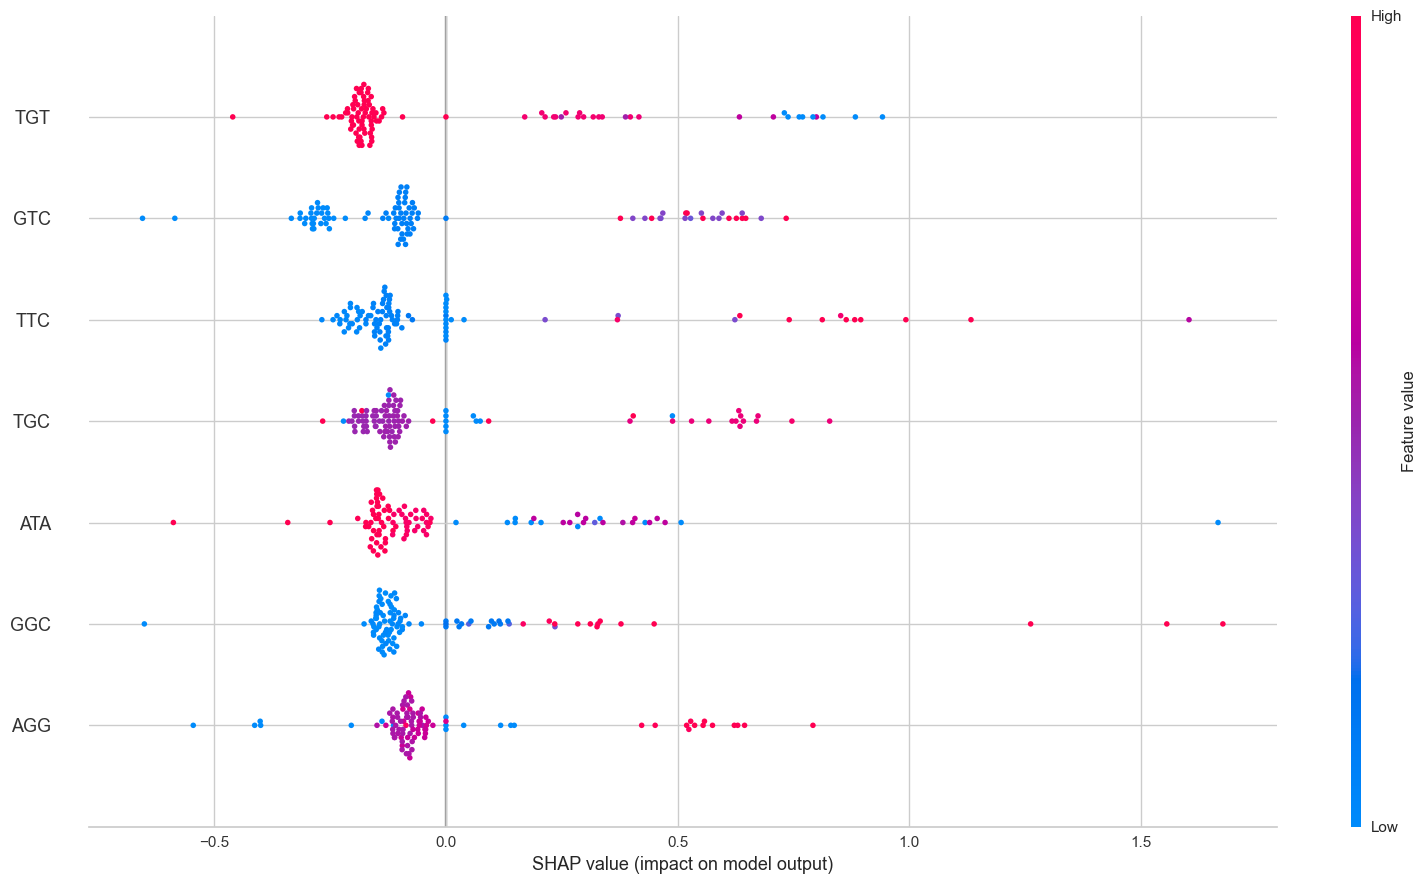

In [45]:
mp_clf.plot(max_display=n_features,
            plot_size=(16, 9),
            title='Variable importance measures for ComplementNB')

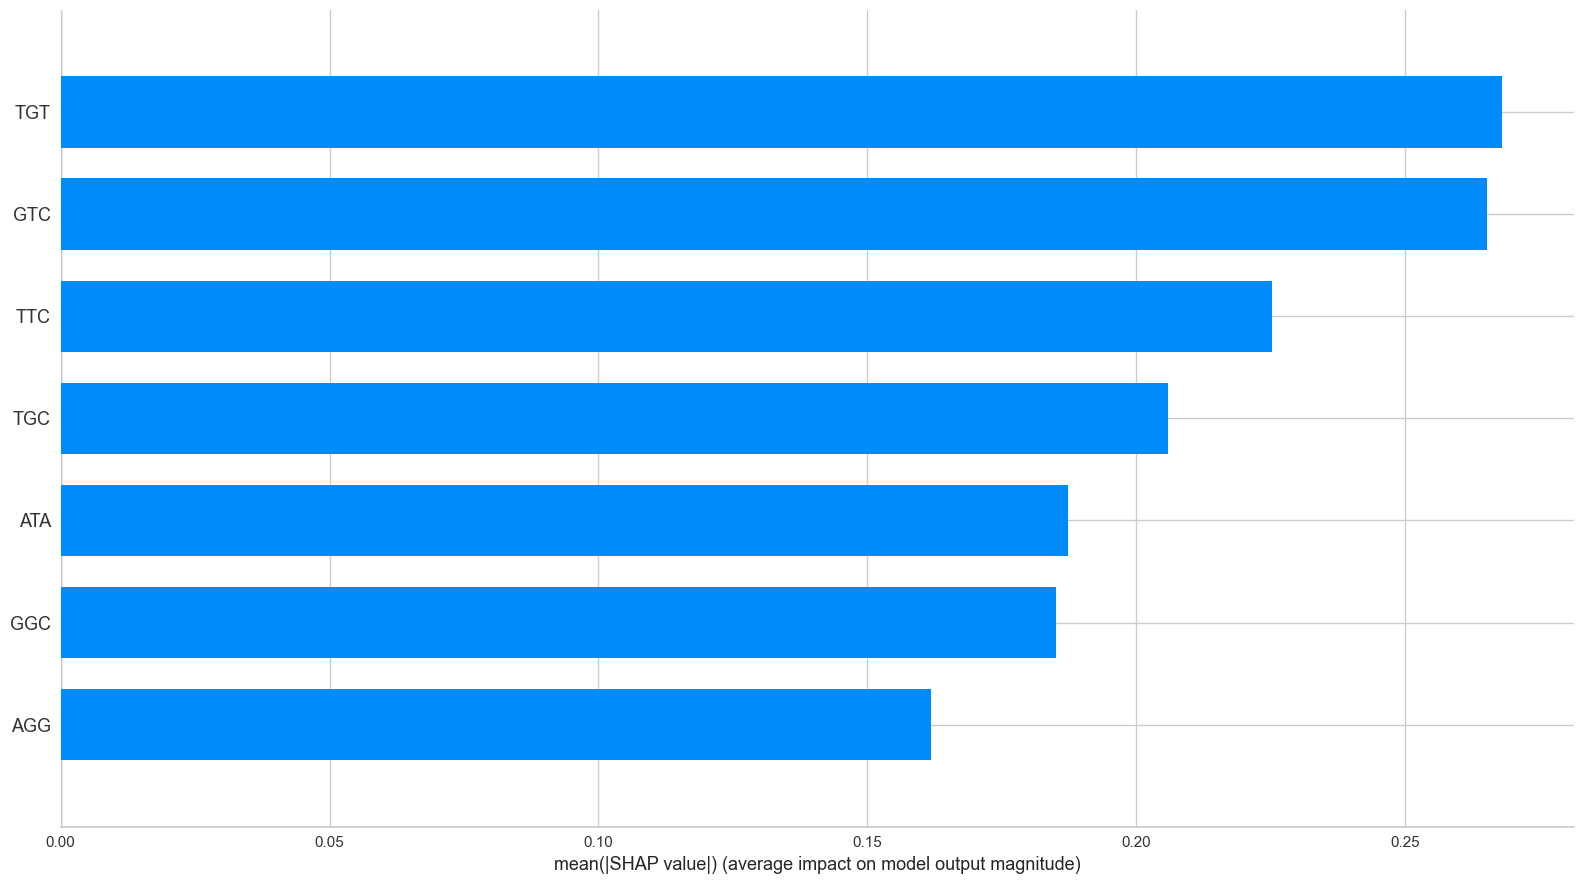

In [46]:
_ = plt.figure(figsize=(16, 9))

mp_clf.plot(plot_type='bar',
            max_display=n_features,
            plot_size=(16, 9),
            title='Variable importance measures for ComplementNB')

### Decision Tree

Parameters for cross-validation.

In [47]:
params = {'criterion': Categorical(['gini', 'entropy'], random_state=seed),
          'max_depth': Integer(4, 32, random_state=seed),
          'min_samples_split': Integer(128, 256, random_state=seed),
          'min_samples_leaf': Integer(32, 64, random_state=seed),
          'min_impurity_decrease': Continuous(0, 1, random_state=seed),
          'ccp_alpha': Continuous(0, 2, random_state=seed)}

Applying genetic search cross-validation algorithm.

In [48]:
clf = GASearchCV(DecisionTreeClassifier(class_weight='balanced',
                                        random_state=seed),
                 param_grid=params,
                 scoring='balanced_accuracy',
                 population_size=pops,
                 generations=maxiter,
                 tournament_size=tous,
                 elitism=True,
                 crossover_probability=crossover_adapter,
                 mutation_probability=mutation_adapter,
                 cv=cross_validation_generator,
                 algorithm='eaSimple',
                 n_jobs=-1,
                 verbose=False)

_ = clf.fit(X_train,
            enc.transform(y_train),
            callbacks=stopping_condition)

INFO: DeltaThreshold callback met its criteria
INFO: Stopping the algorithm


Parameters of the best model.

In [49]:
display_best_parameters(clf)

criterion: gini, max_depth: 21, min_samples_split: 203, min_samples_leaf: 34, min_impurity_decrease: 0.03934151359421478, ccp_alpha: 0.07868302718842957


Classification report for training data.

In [50]:
print(classification_report(y_true=y_train,
                            y_pred=enc.inverse_transform(clf.predict(X_train)),
                            digits=5,
                            zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    1.00000   1.00000   1.00000       364
          ORF1a polyprotein    1.00000   1.00000   1.00000    241372
         ORF1ab polyprotein    1.00000   1.00000   1.00000    314439
              ORF3a protein    0.99984   0.99989   0.99986     18476
               ORF6 protein    0.99909   0.99727   0.99818      1098
              ORF7a protein    0.99949   0.99721   0.99835      3937
              ORF7b protein    1.00000   0.99865   0.99933       743
               ORF8 protein    0.99662   1.00000   0.99831      3831
           envelope protein    0.99847   0.99392   0.99619       658
      membrane glycoprotein    0.99921   0.99980   0.99951      5083
nucleocapsid phosphoprotein    1.00000   0.99997   0.99998     29103
       surface glycoprotein    0.99997   0.99995   0.99996     76782

                   accuracy                        0.99996    695886
                  macro avg    0

Confusion matrix for training data.

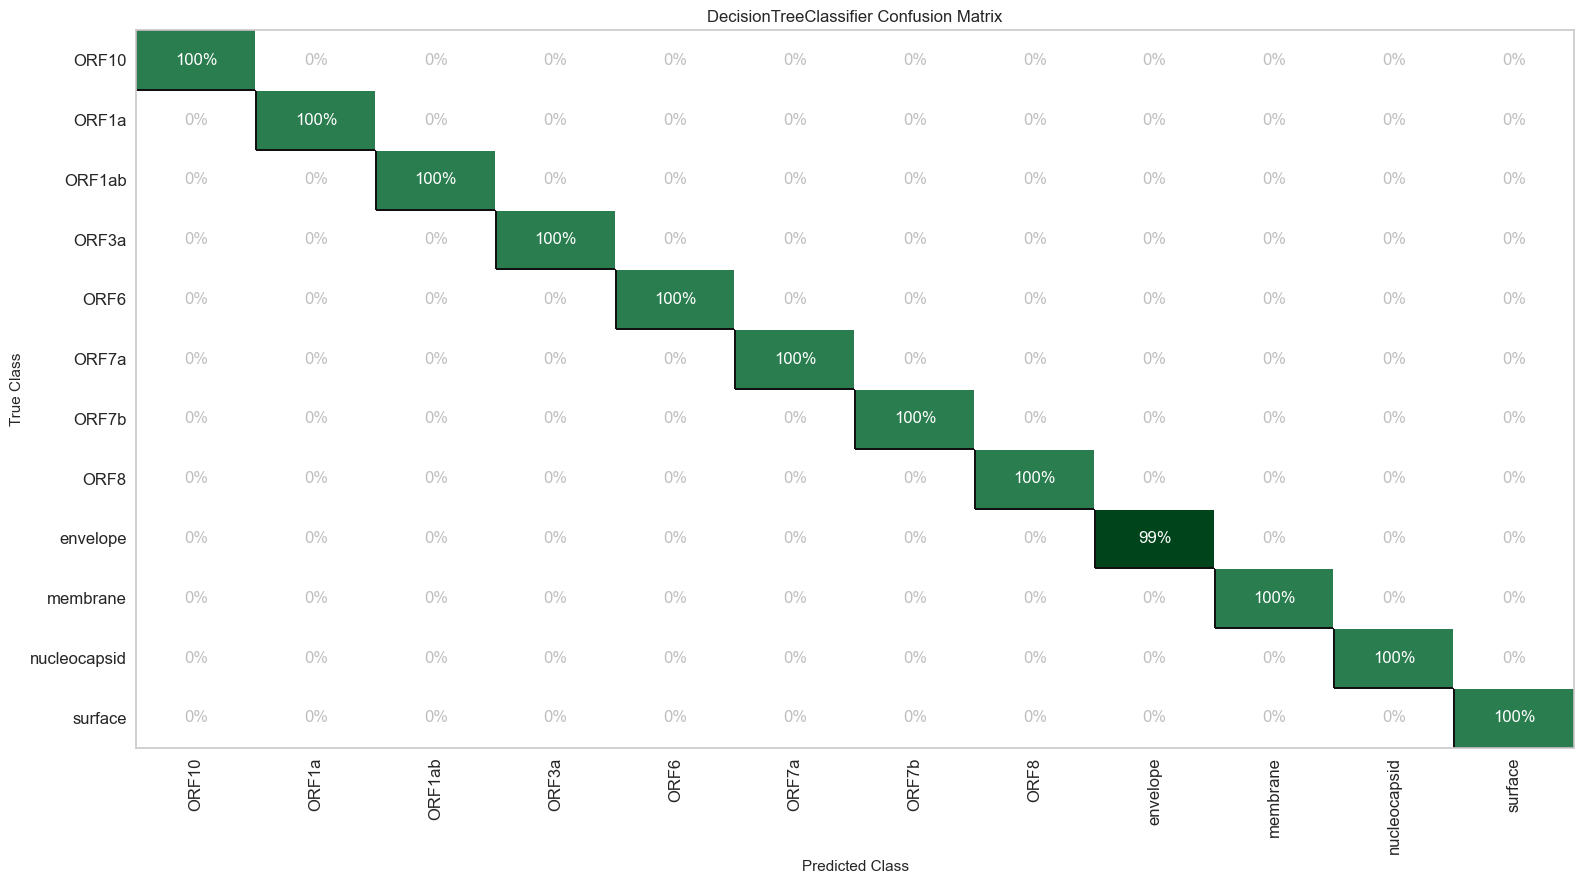

In [51]:
_ = plt.figure(figsize=(16, 9))

_ = confusion_matrix(clf.best_estimator_,
                     X_train,
                     enc.transform(y_train),
                     classes=labels2display,
                     cmap='Greens',
                     percent=True,
                     is_fitted=True)

Precision-recall curves for training data.

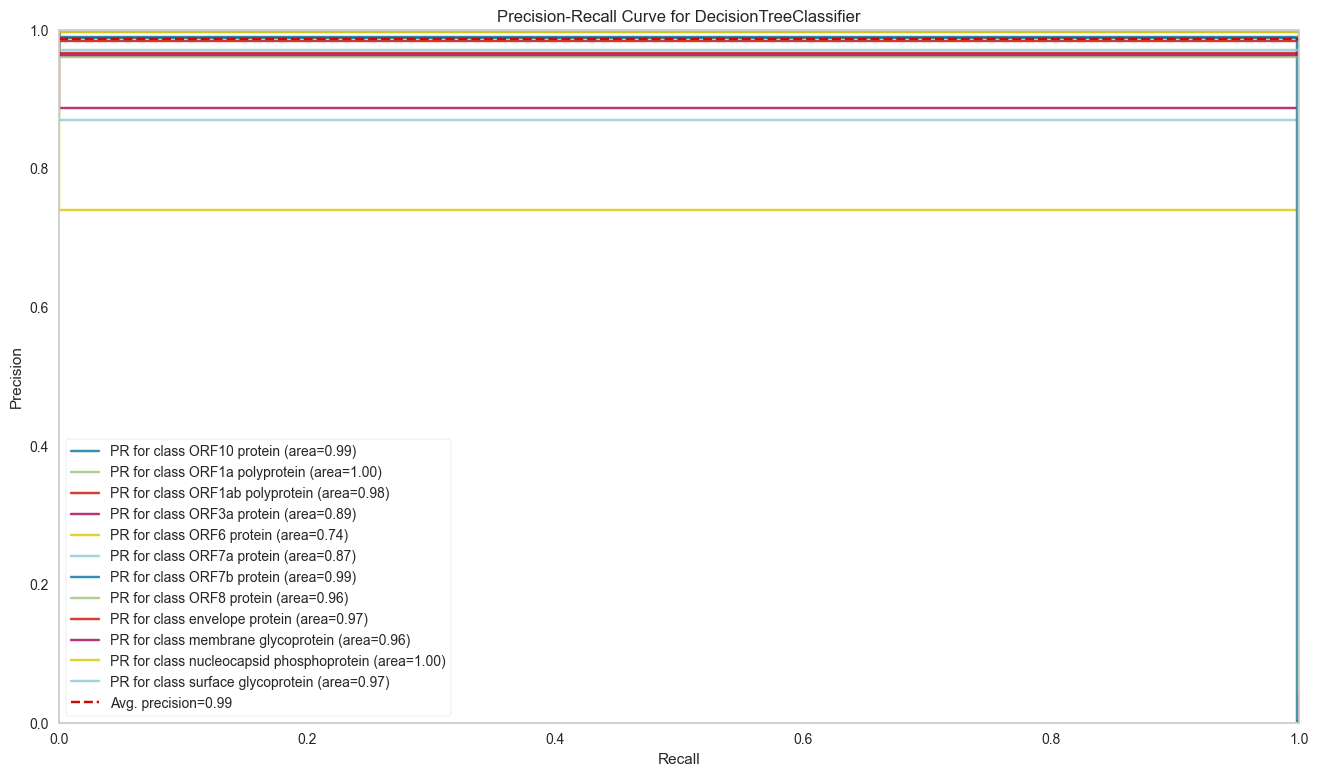

In [52]:
_ = plt.figure(figsize=(16, 9))

_ = precision_recall_curve(clf.best_estimator_,
                           X_train,
                           y_train,
                           encoder=enc,
                           per_class=True)

Classification report for test data.

In [53]:
print(classification_report(y_true=y_test,
                            y_pred=enc.inverse_transform(clf.predict(X_test)),
                            digits=5,
                            zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    1.00000   1.00000   1.00000        91
          ORF1a polyprotein    1.00000   1.00000   1.00000     60343
         ORF1ab polyprotein    1.00000   1.00000   1.00000     78610
              ORF3a protein    0.99935   1.00000   0.99968      4619
               ORF6 protein    0.99636   1.00000   0.99818       274
              ORF7a protein    0.99898   0.99492   0.99695       984
              ORF7b protein    0.99465   1.00000   0.99732       186
               ORF8 protein    0.99687   0.99896   0.99791       958
           envelope protein    1.00000   0.98780   0.99387       164
      membrane glycoprotein    1.00000   1.00000   1.00000      1271
nucleocapsid phosphoprotein    1.00000   1.00000   1.00000      7276
       surface glycoprotein    1.00000   0.99995   0.99997     19196

                   accuracy                        0.99995    173972
                  macro avg    0

Confusion matrix for test data.

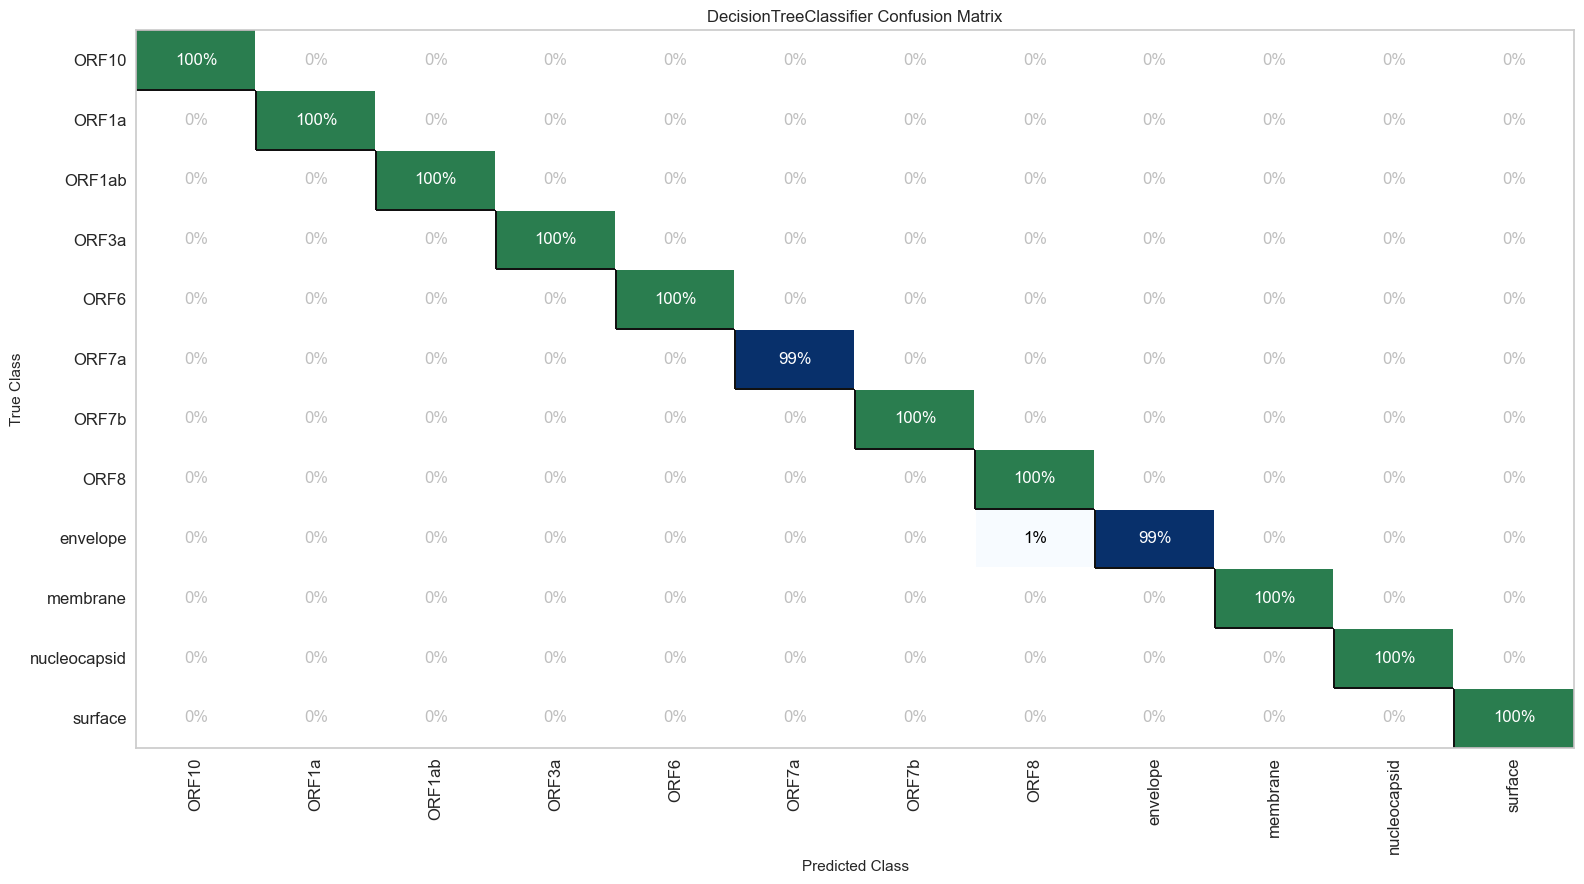

In [54]:
_ = plt.figure(figsize=(16, 9))

_ = confusion_matrix(clf.best_estimator_,
                     X_test,
                     enc.transform(y_test),
                     classes=labels2display,
                     cmap='Blues',
                     percent=True,
                     is_fitted=True)

Precision-recall curves for test data.

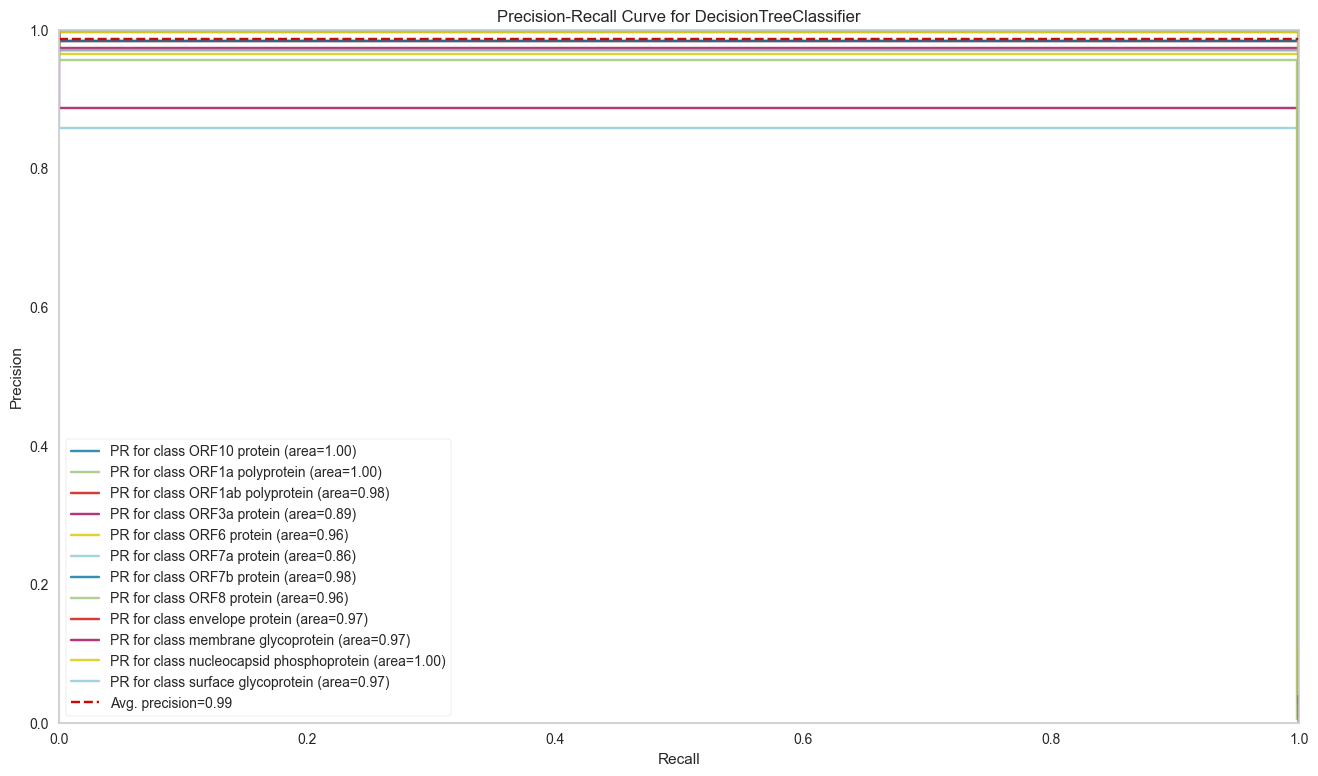

In [55]:
_ = plt.figure(figsize=(16, 9))

_ = precision_recall_curve(clf.best_estimator_,
                           X_test,
                           y_test,
                           encoder=enc,
                           per_class=True)

Graphical view of the decision tree classifier.

In [56]:
viz_model = dtreeviz.model(clf.best_estimator_,
                           X_train=X_train.values,
                           y_train=enc.transform(y_train),
                           feature_names=X_train.columns.to_list(),
                           target_name='Proteins',
                           class_names=list(enc.inverse_transform(clf.best_estimator_.classes_)))

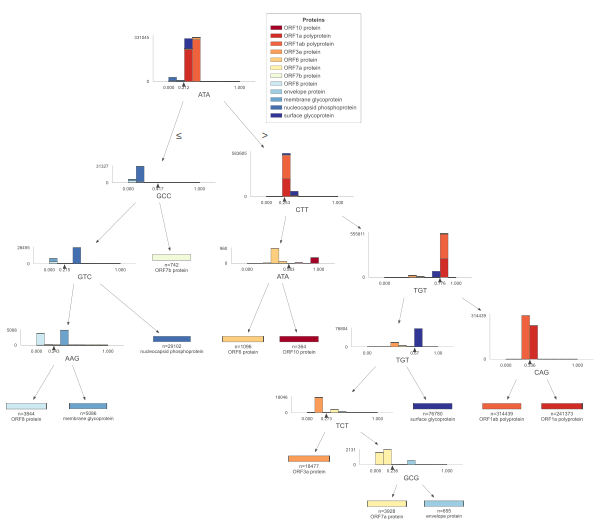

In [57]:
viz_model.view(scale=0.75,
               leaftype='barh')

Variable importances.

In [58]:
explainer = dx.Explainer(clf.best_estimator_,
                         X_train_sample,
                         enc.transform(y_train_sample),
                         model_type='classification',
                         label='Variable importance measures for DecisionTreeClassifier',
                         verbose=False)

In [59]:
mp_clf = explainer.model_parts(N=sample,
                               B=start,
                               type='shap_wrapper',
                               shap_explainer_type='KernelExplainer',
                               loss_function=lambda a, b: 1-balanced_accuracy_score(a, b),
                               processes=-1,
                               random_state=seed,
                               data=X_test,
                               silent=True)

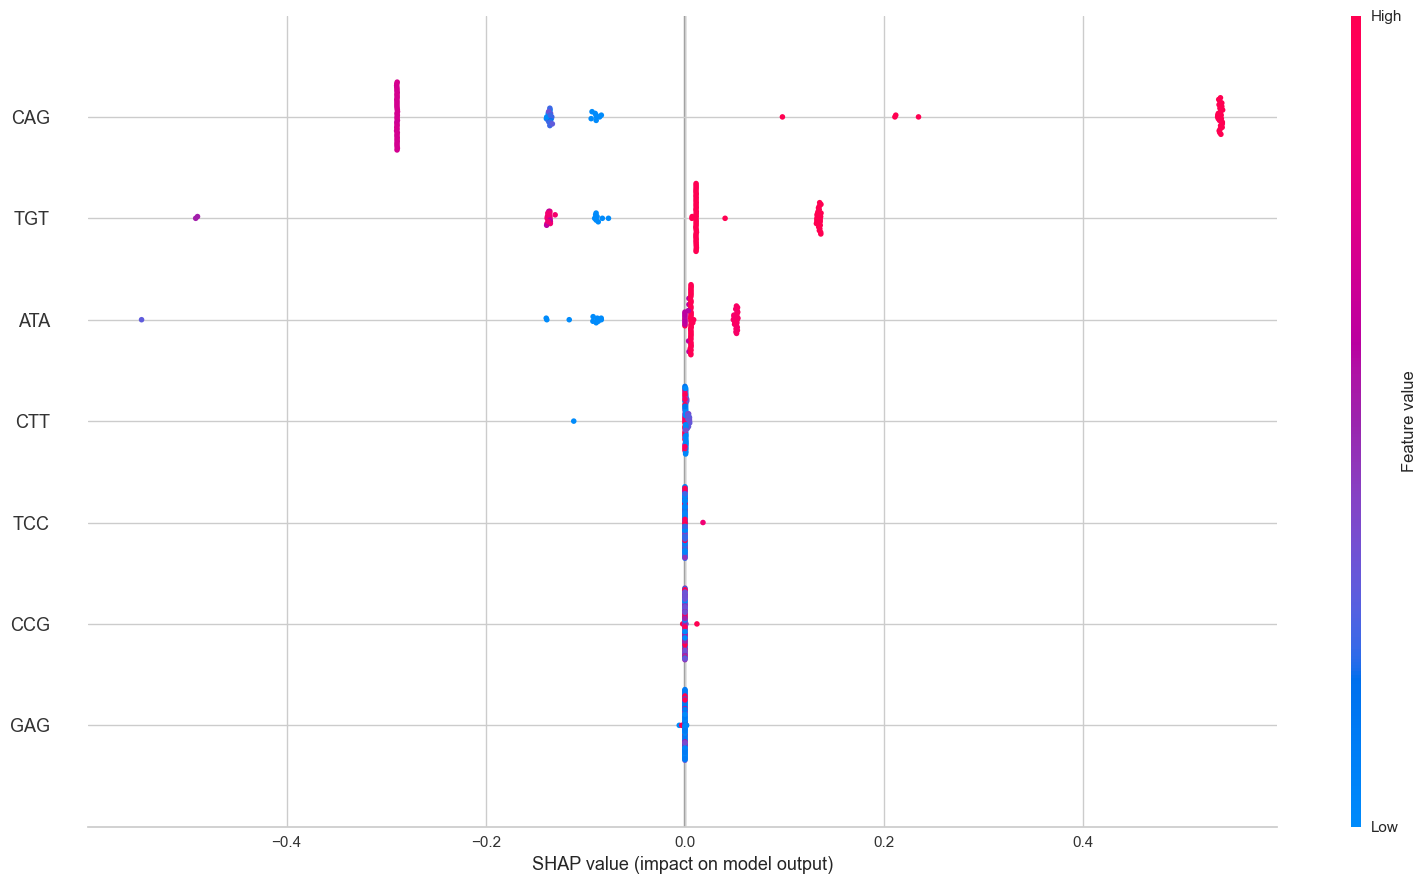

In [60]:
mp_clf.plot(max_display=n_features,
            plot_size=(16, 9),
            title='Variable importance measures for DecisionTreeClassifier')

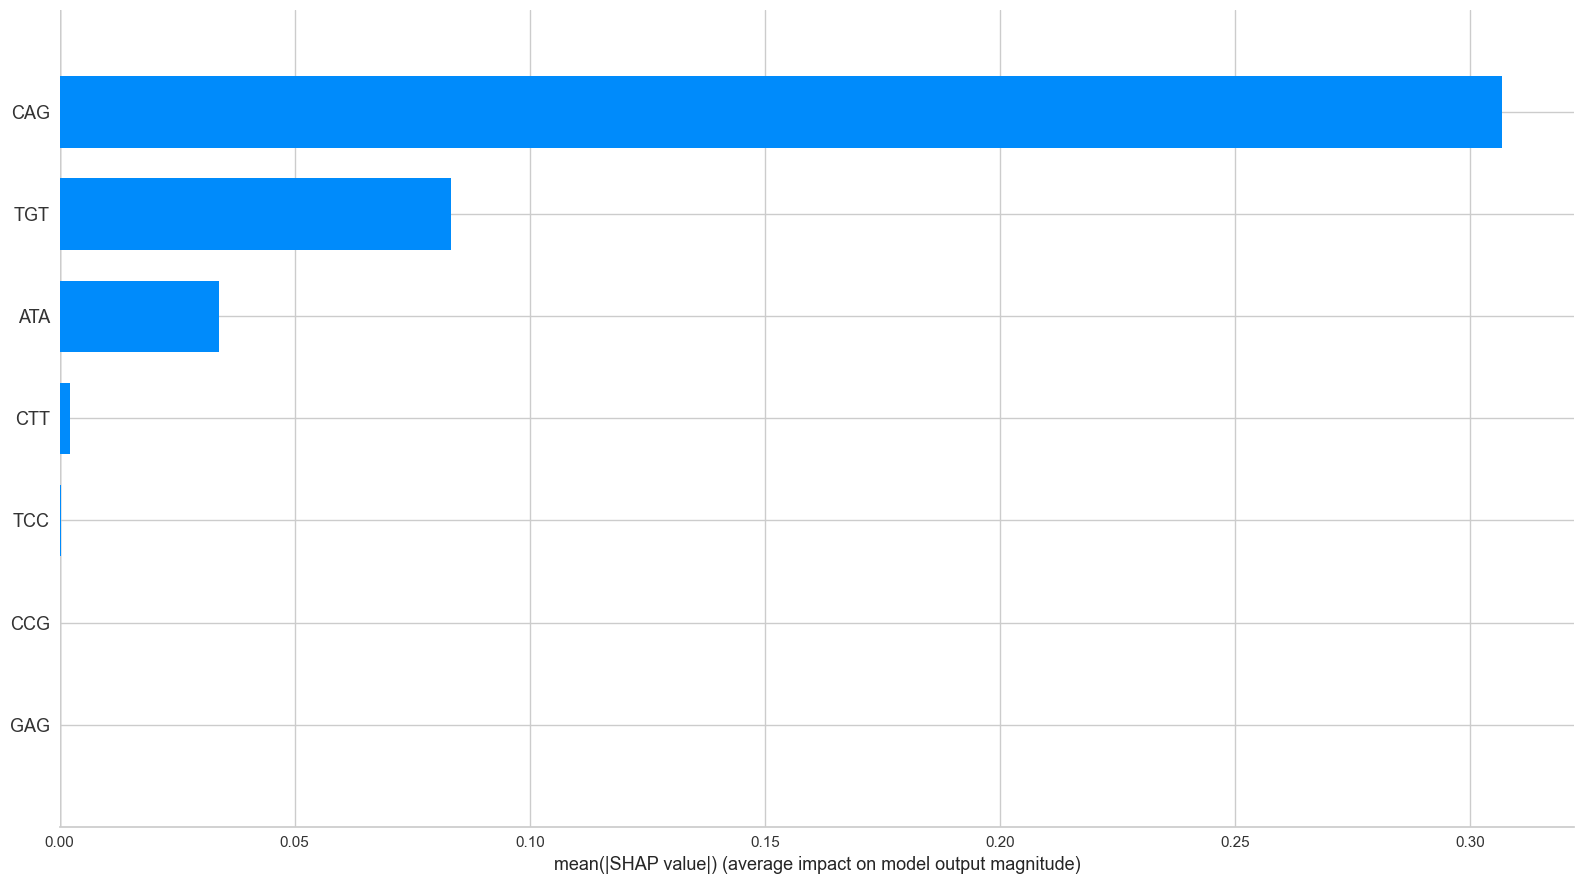

In [61]:
mp_clf.plot(plot_type='bar',
            max_display=n_features,
            plot_size=(16, 9),
            title='Variable importance measures for DecisionTreeClassifier')

### Random Forest

Cross-validation parameters.

In [62]:
params = {'n_estimators': Integer(32, 256, random_state=seed),
           'criterion': Categorical(['gini', 'entropy'], random_state=seed),
           'max_features': Continuous(0, 1, random_state=seed),
           'max_samples': Continuous(0, 1, random_state=seed)}

Applying genetic search cross-validation algorithm.

In [63]:
clf = GASearchCV(RandomForestClassifier(n_jobs=-1,
                                        random_state=seed),
                 param_grid=params,
                 scoring='balanced_accuracy',
                 population_size=pops,
                 generations=maxiter,
                 tournament_size=tous,
                 elitism=True,
                 crossover_probability=crossover_adapter,
                 mutation_probability=mutation_adapter,
                 cv=cross_validation_generator,
                 algorithm='eaSimple',
                 n_jobs=2,
                 verbose=False)

_ = clf.fit(X_train,
            y_train,
            callbacks=stopping_condition)

INFO: DeltaThreshold callback met its criteria
INFO: Stopping the algorithm


Parameters of the best model.

In [64]:
display_best_parameters(clf)

n_estimators: 231, criterion: entropy, max_features: 0.010946358993686456, max_samples: 0.010946358993686456


Classification report for training data.

In [65]:
print(classification_report(y_true=y_train,
                            y_pred=clf.predict(X_train),
                            digits=5,
                            zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    1.00000   1.00000   1.00000       364
          ORF1a polyprotein    1.00000   1.00000   1.00000    241372
         ORF1ab polyprotein    1.00000   1.00000   1.00000    314439
              ORF3a protein    1.00000   1.00000   1.00000     18476
               ORF6 protein    1.00000   1.00000   1.00000      1098
              ORF7a protein    1.00000   1.00000   1.00000      3937
              ORF7b protein    0.99866   1.00000   0.99933       743
               ORF8 protein    1.00000   0.99974   0.99987      3831
           envelope protein    1.00000   1.00000   1.00000       658
      membrane glycoprotein    1.00000   1.00000   1.00000      5083
nucleocapsid phosphoprotein    1.00000   1.00000   1.00000     29103
       surface glycoprotein    1.00000   1.00000   1.00000     76782

                   accuracy                        1.00000    695886
                  macro avg    0

Confusion matrix for training data.

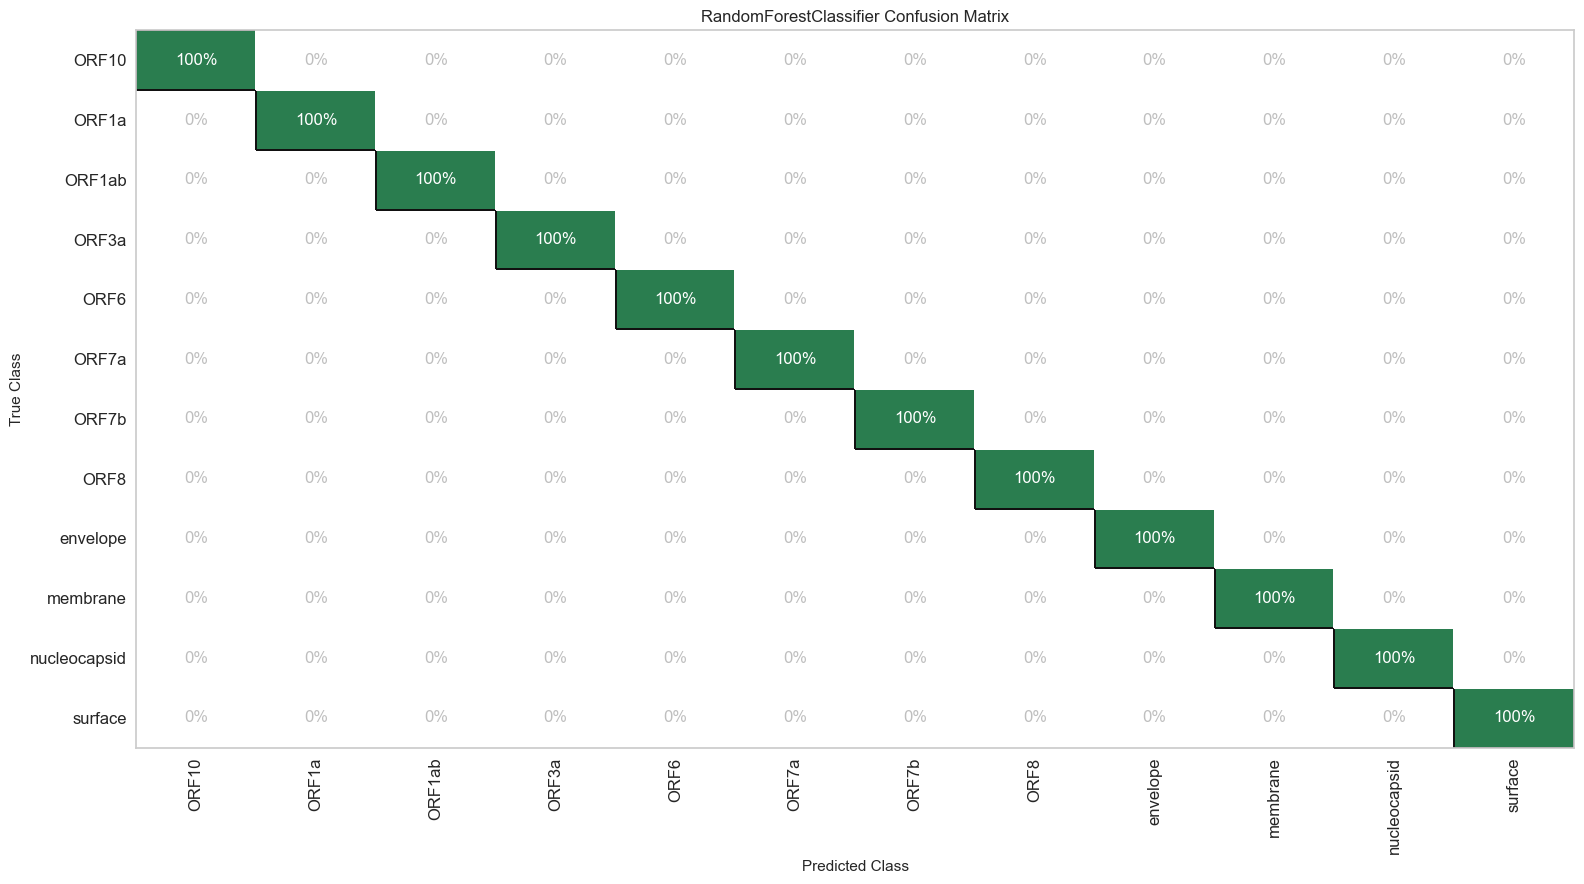

In [66]:
_ = plt.figure(figsize=(16, 9))

_ = confusion_matrix(clf.best_estimator_,
                     X_train,
                     y_train,
                     classes=labels2display,
                     cmap='Greens',
                     percent=True,
                     is_fitted=True)

Precision-recall curves for training data.

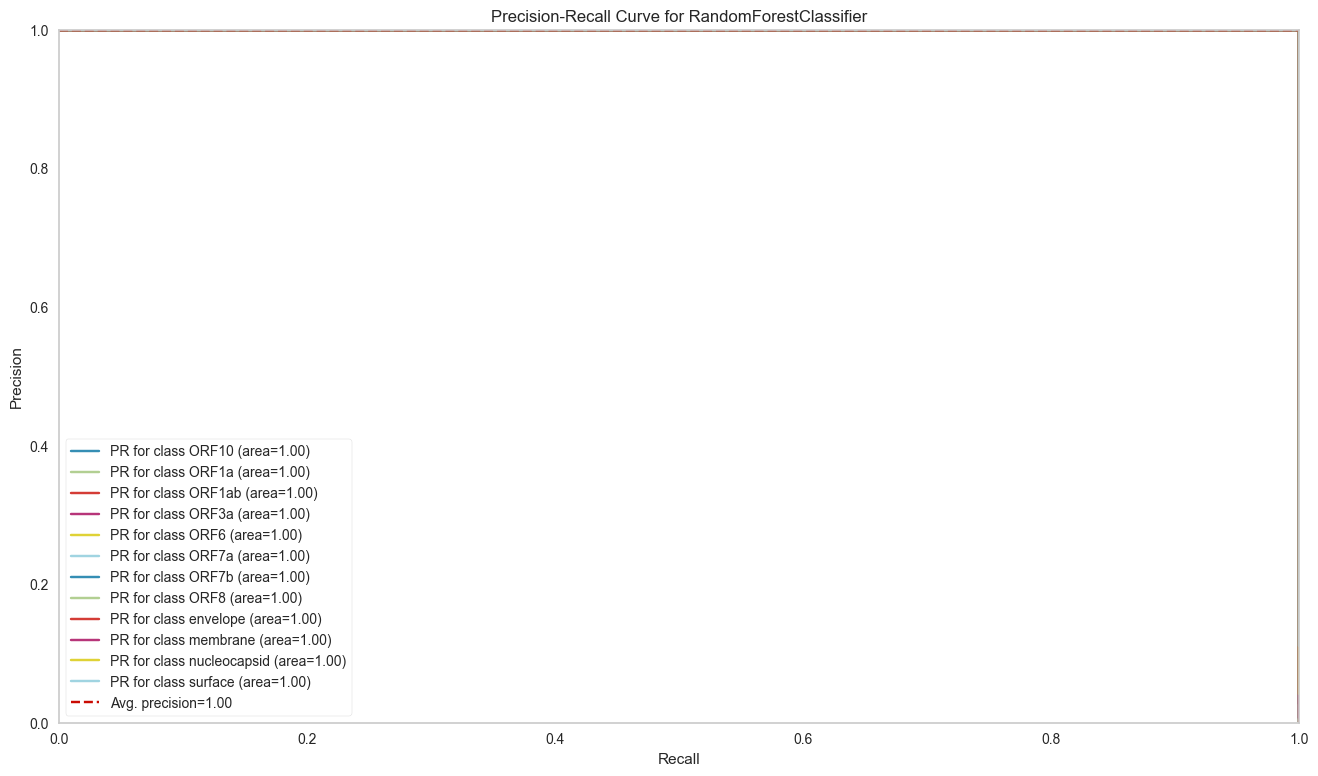

In [67]:
_ = plt.figure(figsize=(16, 9))

_ = precision_recall_curve(clf.best_estimator_,
                           X_train,
                           y_train,
                           classes=labels2display,
                           per_class=True)

Classification report for test data.

In [68]:
print(classification_report(y_true=y_test,
                            y_pred=clf.predict(X_test),
                            digits=5,
                            zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    1.00000   1.00000   1.00000        91
          ORF1a polyprotein    1.00000   1.00000   1.00000     60343
         ORF1ab polyprotein    1.00000   1.00000   1.00000     78610
              ORF3a protein    1.00000   1.00000   1.00000      4619
               ORF6 protein    1.00000   1.00000   1.00000       274
              ORF7a protein    1.00000   1.00000   1.00000       984
              ORF7b protein    1.00000   1.00000   1.00000       186
               ORF8 protein    1.00000   1.00000   1.00000       958
           envelope protein    1.00000   1.00000   1.00000       164
      membrane glycoprotein    1.00000   1.00000   1.00000      1271
nucleocapsid phosphoprotein    1.00000   1.00000   1.00000      7276
       surface glycoprotein    1.00000   1.00000   1.00000     19196

                   accuracy                        1.00000    173972
                  macro avg    1

Confusion matrix for test data.

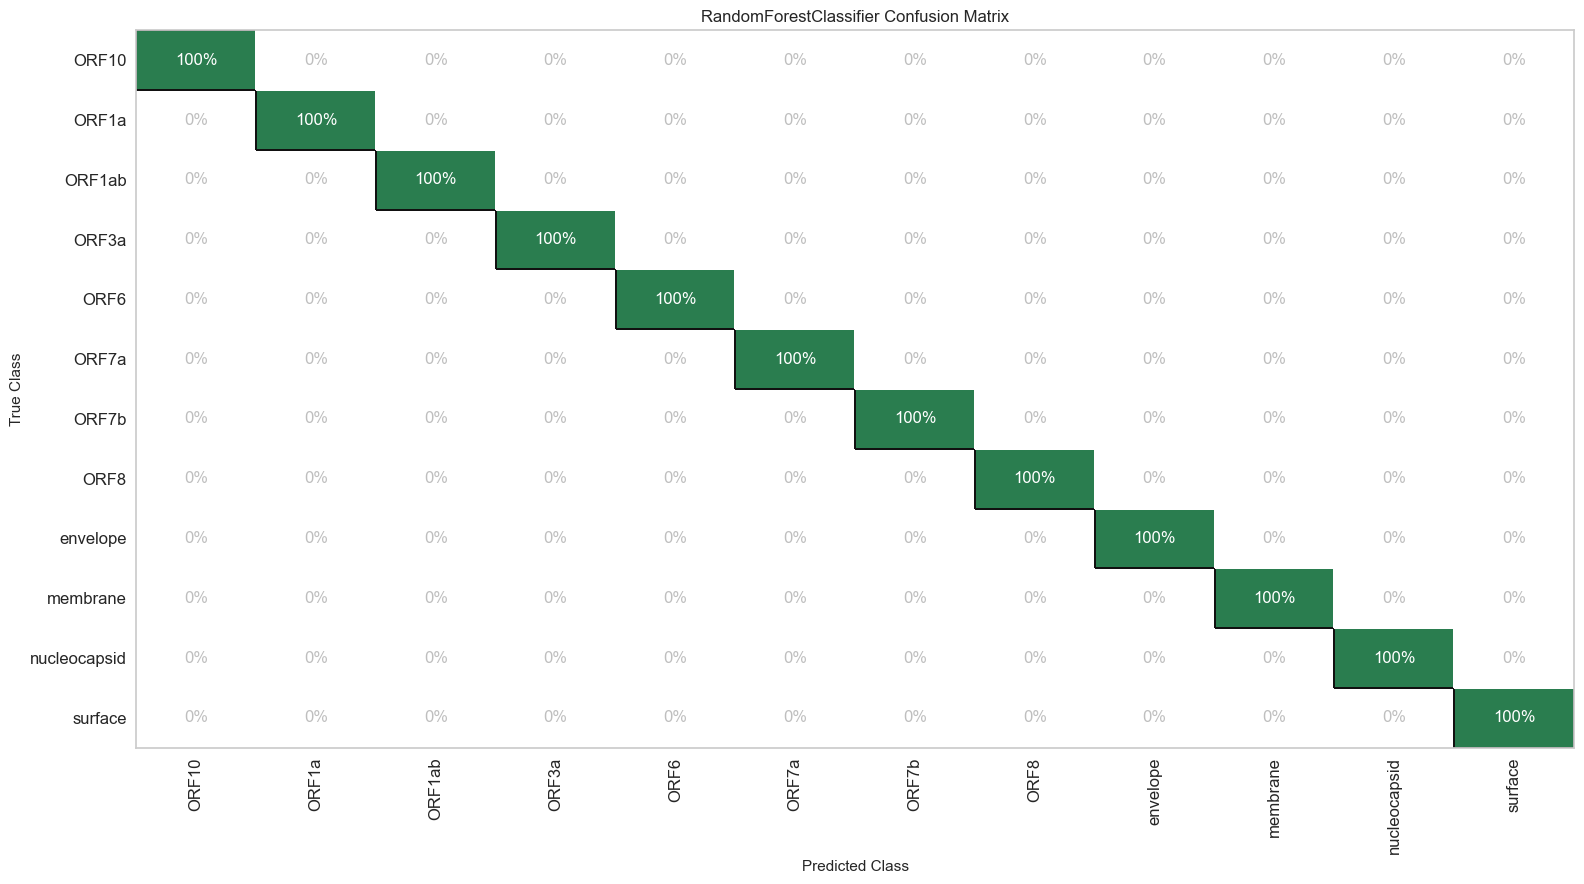

In [69]:
_ = plt.figure(figsize=(16, 9))

_ = confusion_matrix(clf.best_estimator_,
                     X_test,
                     y_test,
                     classes=labels2display,
                     cmap='Blues',
                     percent=True,
                     is_fitted=True)

Precision-recall curves for test data.

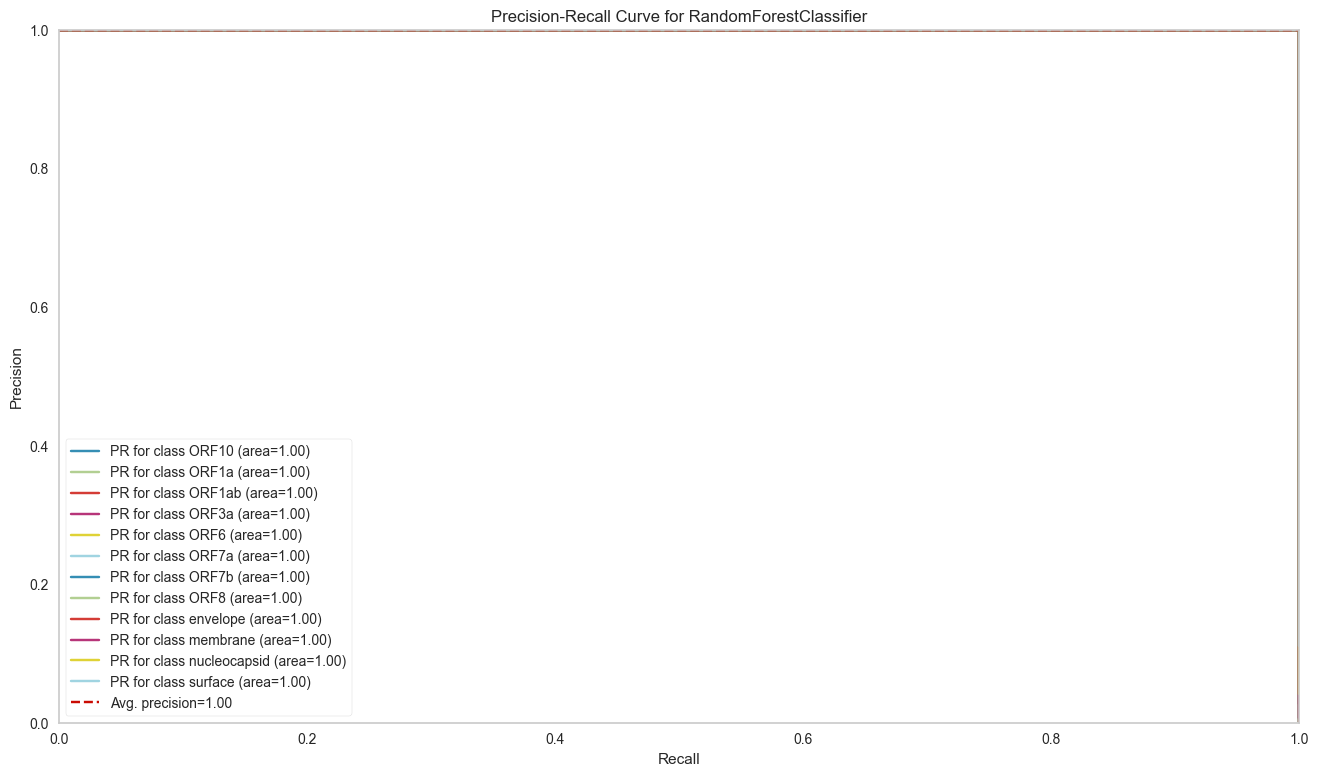

In [70]:
_ = plt.figure(figsize=(16, 9))

_ = precision_recall_curve(clf.best_estimator_,
                           X_test,
                           y_test,
                           classes=labels2display,
                           per_class=True)

Važnost atributa za test skup podataka.

In [71]:
explainer = dx.Explainer(clf.best_estimator_,
                         X_train_sample,
                         enc.transform(y_train_sample),
                         predict_function=lambda a, b: enc.transform(a.predict(b)),
                         model_type='classification',
                         label='Variable importance measures for RandomForestClassifier',
                         verbose=False)

In [72]:
mp_clf = explainer.model_parts(N=sample,
                               B=start,
                               type='shap_wrapper',
                               shap_explainer_type='KernelExplainer',
                               loss_function=lambda a, b: 1-balanced_accuracy_score(a, b),
                               processes=-1,
                               random_state=seed,
                               data=X_test,
                               silent=True)

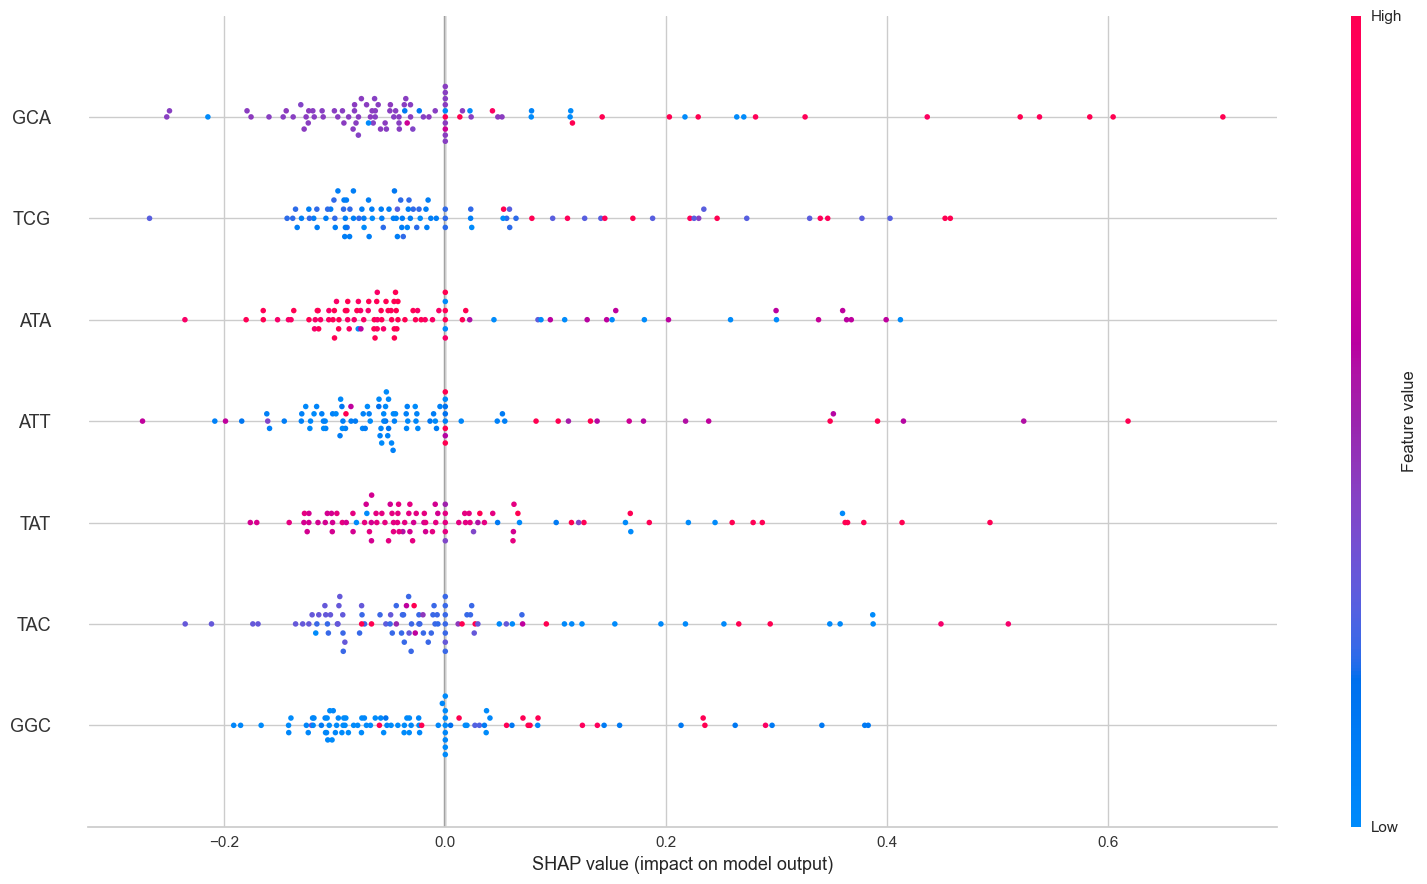

In [73]:
mp_clf.plot(max_display=n_features,
            plot_size=(16, 9),
            title='Variable importance measures for SVC')

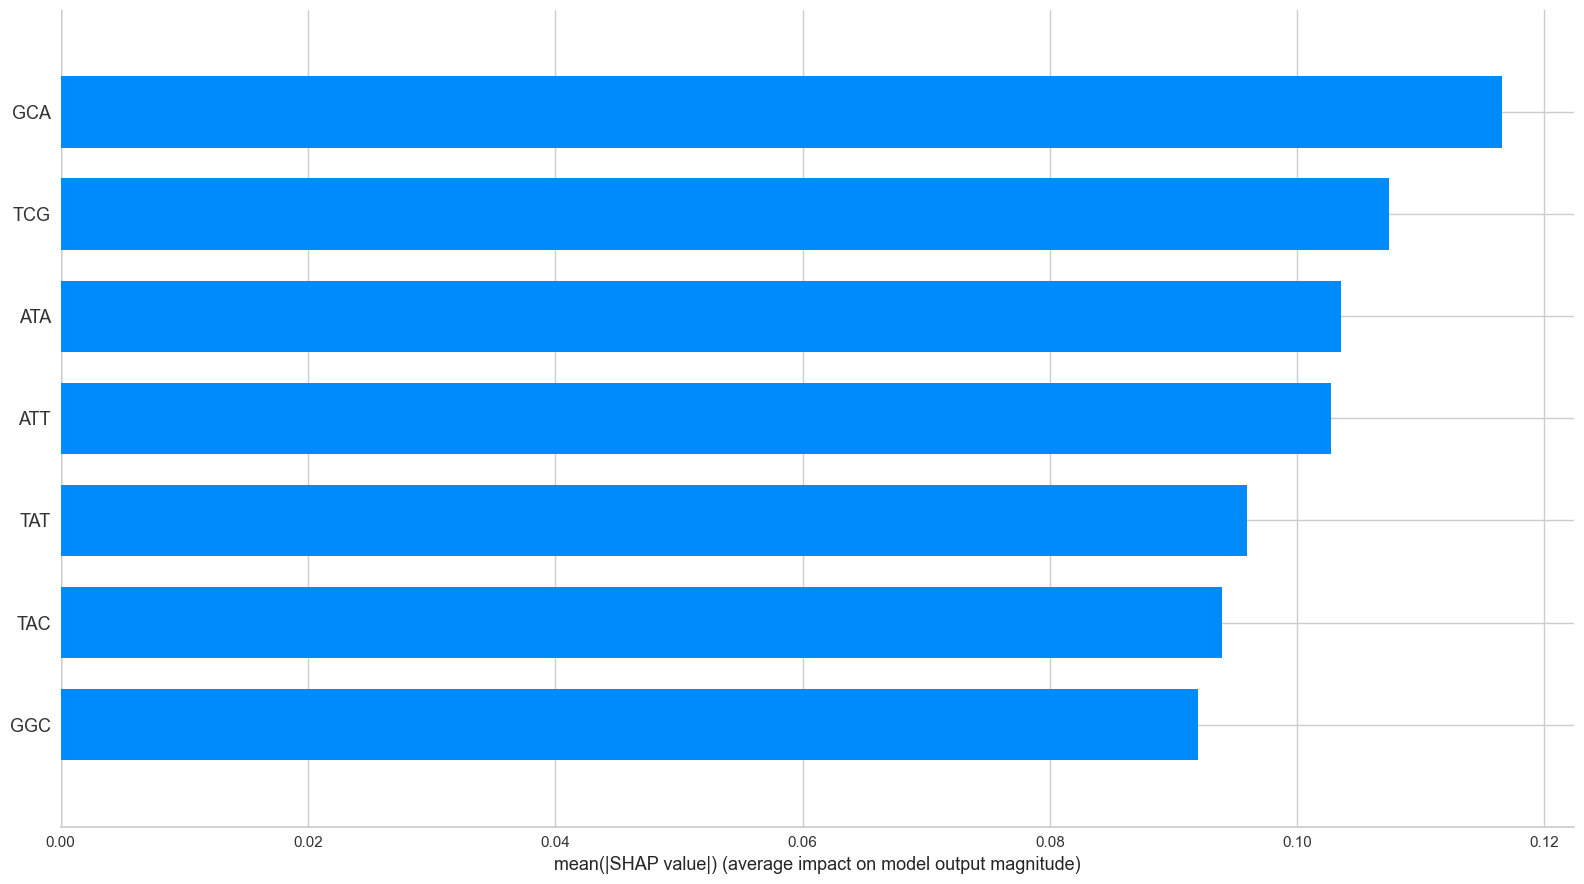

In [74]:
mp_clf.plot(plot_type='bar',
            max_display=n_features,
            plot_size=(16, 9),
            title='Variable importance measures for SVC')

### Extreme Gradient Boosting

Cross-validation parameters.

In [75]:
params = {'n_estimators': Integer(4, 96, random_state=seed),
           'max_depth': Integer(1, 4, random_state=seed),
           'grow_policy': Categorical(['depthwise',
                                       'lossguide'], random_state=seed),
           'gamma': Continuous(0, 1, random_state=seed),
           'learning_rate': Continuous(0, 1, random_state=seed),
           'objective': Categorical(['reg:linear',
                                     'reg:logistic',
                                     'multi:softmax',
                                     'multi:softprob'], random_state=seed)}

Applying genetic search cross-validation algorithm.

In [76]:
clf = GASearchCV(XGBClassifier(nthread=-1,
                               random_state=seed),
                 param_grid=params,
                 scoring='balanced_accuracy',
                 population_size=pops,
                 generations=maxiter,
                 tournament_size=tous,
                 elitism=True,
                 crossover_probability=crossover_adapter,
                 mutation_probability=mutation_adapter,
                 cv=cross_validation_generator,
                 algorithm='eaSimple',
                 n_jobs=2,
                 verbose=False)

_ = clf.fit(X_train,
            enc.transform(y_train),
            callbacks=stopping_condition)

INFO: DeltaThreshold callback met its criteria
INFO: Stopping the algorithm


Parameters of the best model.

In [77]:
display_best_parameters(clf)

n_estimators: 79, max_depth: 4, grow_policy: lossguide, gamma: 0.913849415202624, learning_rate: 0.913849415202624, objective: multi:softprob


Classification report for training data.

In [78]:
print(classification_report(y_true=y_train,
                            y_pred=enc.inverse_transform(clf.predict(X_train)),
                            digits=5,
                            zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    1.00000   1.00000   1.00000       364
          ORF1a polyprotein    1.00000   1.00000   1.00000    241372
         ORF1ab polyprotein    1.00000   1.00000   1.00000    314439
              ORF3a protein    1.00000   1.00000   1.00000     18476
               ORF6 protein    1.00000   1.00000   1.00000      1098
              ORF7a protein    1.00000   1.00000   1.00000      3937
              ORF7b protein    1.00000   1.00000   1.00000       743
               ORF8 protein    1.00000   1.00000   1.00000      3831
           envelope protein    1.00000   1.00000   1.00000       658
      membrane glycoprotein    1.00000   1.00000   1.00000      5083
nucleocapsid phosphoprotein    1.00000   1.00000   1.00000     29103
       surface glycoprotein    1.00000   1.00000   1.00000     76782

                   accuracy                        1.00000    695886
                  macro avg    1

Confusion matrix for training data.

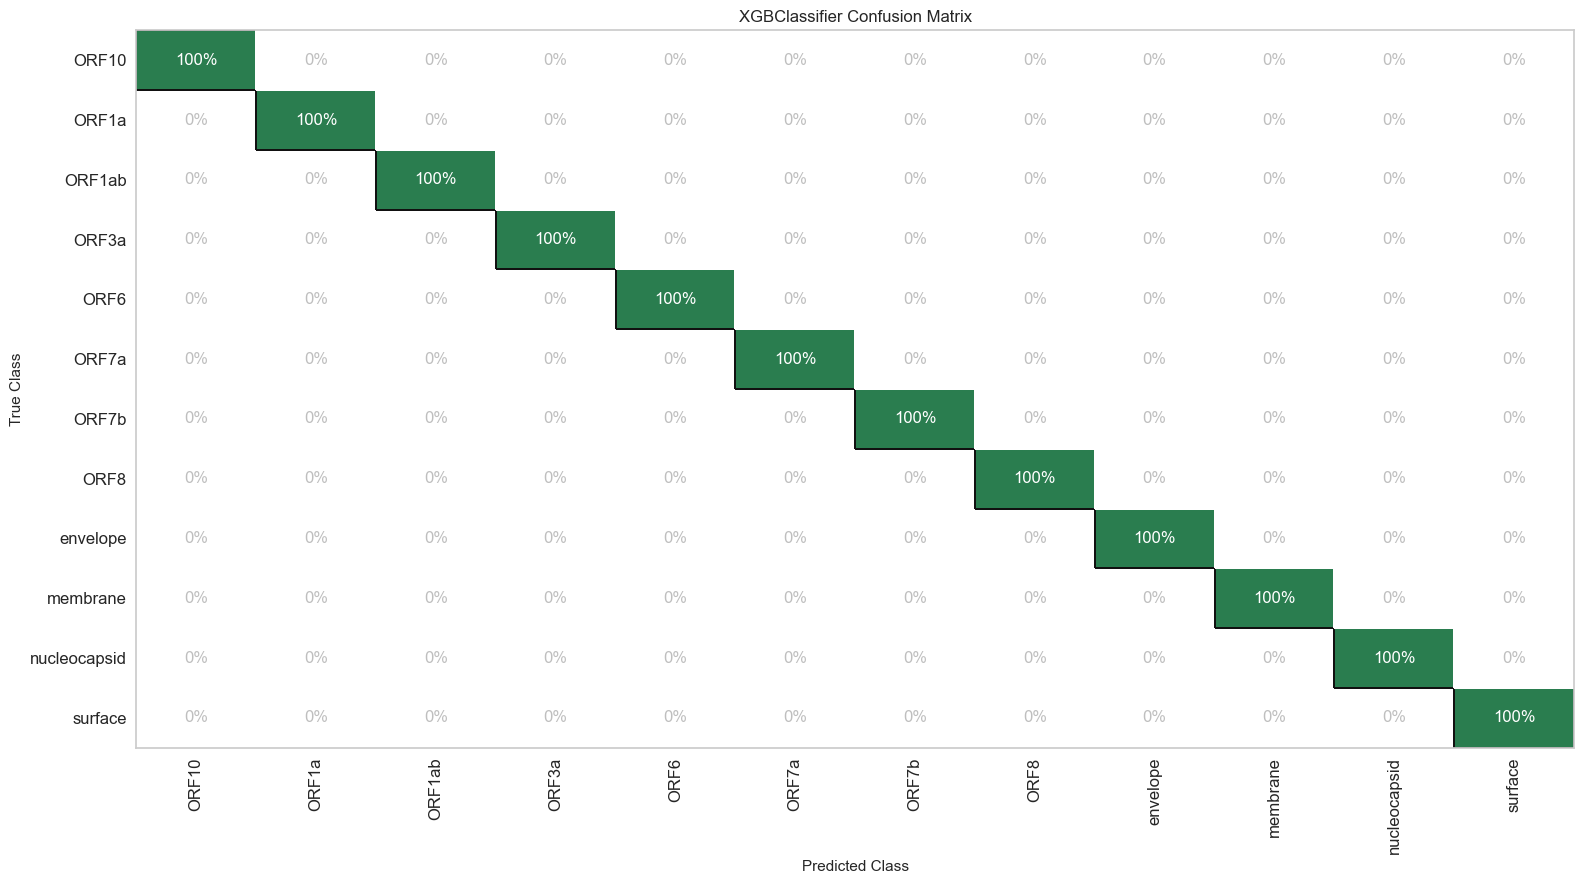

In [79]:
_ = plt.figure(figsize=(16, 9))

_ = confusion_matrix(clf.best_estimator_,
                     X_train,
                     enc.transform(y_train),
                     classes=labels2display,
                     cmap='Greens',
                     percent=True,
                     is_fitted=True)

Precision-recall curves for training data.

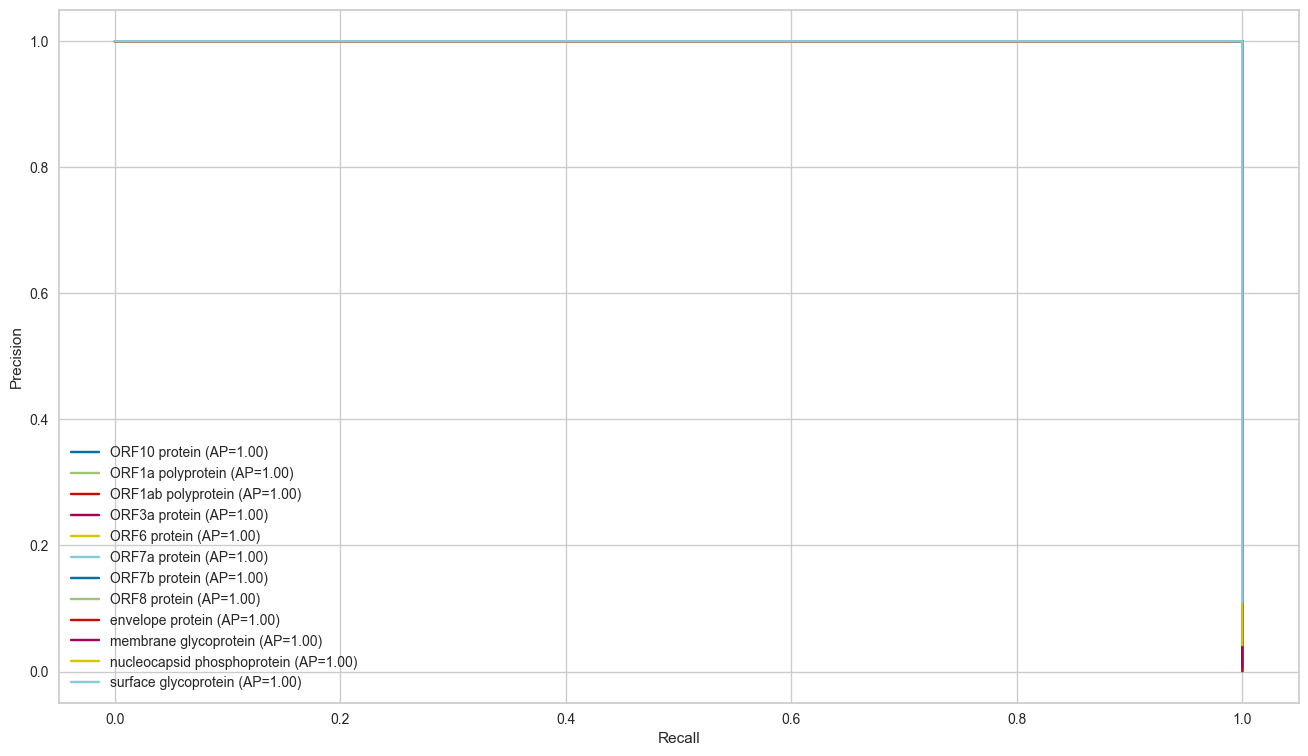

In [80]:
y_scores = clf.predict_proba(X_train)
y_onehot = pd.DataFrame(ohe.transform(y_train), columns=ohe.classes_)

_ = plt.figure(figsize=(16, 9))

for i in range(y_scores.shape[1]):
    y_true = y_onehot.iloc[:, i]
    y_score = y_scores[:, i]

    precision, recall, _ = prec_rec_crve(y_true, y_score)
    ap_score = average_precision_score(y_true, y_score)
    name = f'{y_onehot.columns[i]} (AP={ap_score:.2f})'

    name = f'{y_onehot.columns[i]} (AP={ap_score:.2f})'
    plt.plot(recall, precision, label=name)
    
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend()
plt.show()

Classification report for test data.

In [81]:
print(classification_report(y_true=y_test,
                            y_pred=enc.inverse_transform(clf.predict(X_test)),
                            digits=5,
                            zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    1.00000   1.00000   1.00000        91
          ORF1a polyprotein    1.00000   1.00000   1.00000     60343
         ORF1ab polyprotein    1.00000   1.00000   1.00000     78610
              ORF3a protein    1.00000   1.00000   1.00000      4619
               ORF6 protein    1.00000   1.00000   1.00000       274
              ORF7a protein    1.00000   1.00000   1.00000       984
              ORF7b protein    1.00000   1.00000   1.00000       186
               ORF8 protein    1.00000   1.00000   1.00000       958
           envelope protein    1.00000   1.00000   1.00000       164
      membrane glycoprotein    1.00000   1.00000   1.00000      1271
nucleocapsid phosphoprotein    1.00000   1.00000   1.00000      7276
       surface glycoprotein    1.00000   1.00000   1.00000     19196

                   accuracy                        1.00000    173972
                  macro avg    1

Confusion matrix for test data.

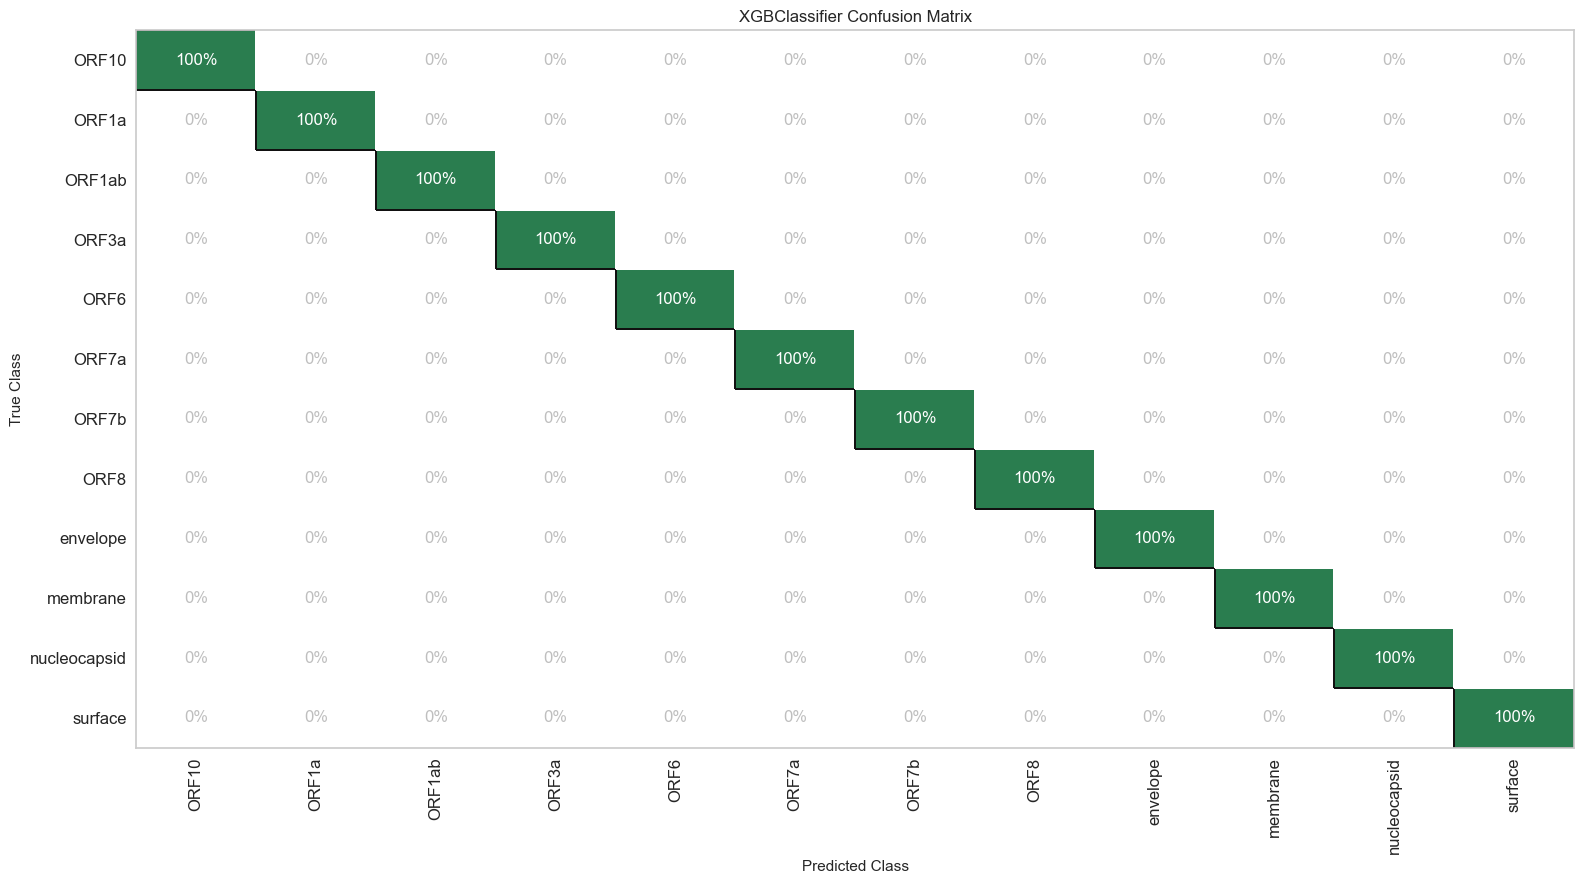

In [82]:
_ = plt.figure(figsize=(16, 9))

_ = confusion_matrix(clf.best_estimator_,
                     X_test,
                     enc.transform(y_test),
                     classes=labels2display,
                     cmap='Blues',
                     percent=True,
                     is_fitted=True)

Precision-recall curves for test data.

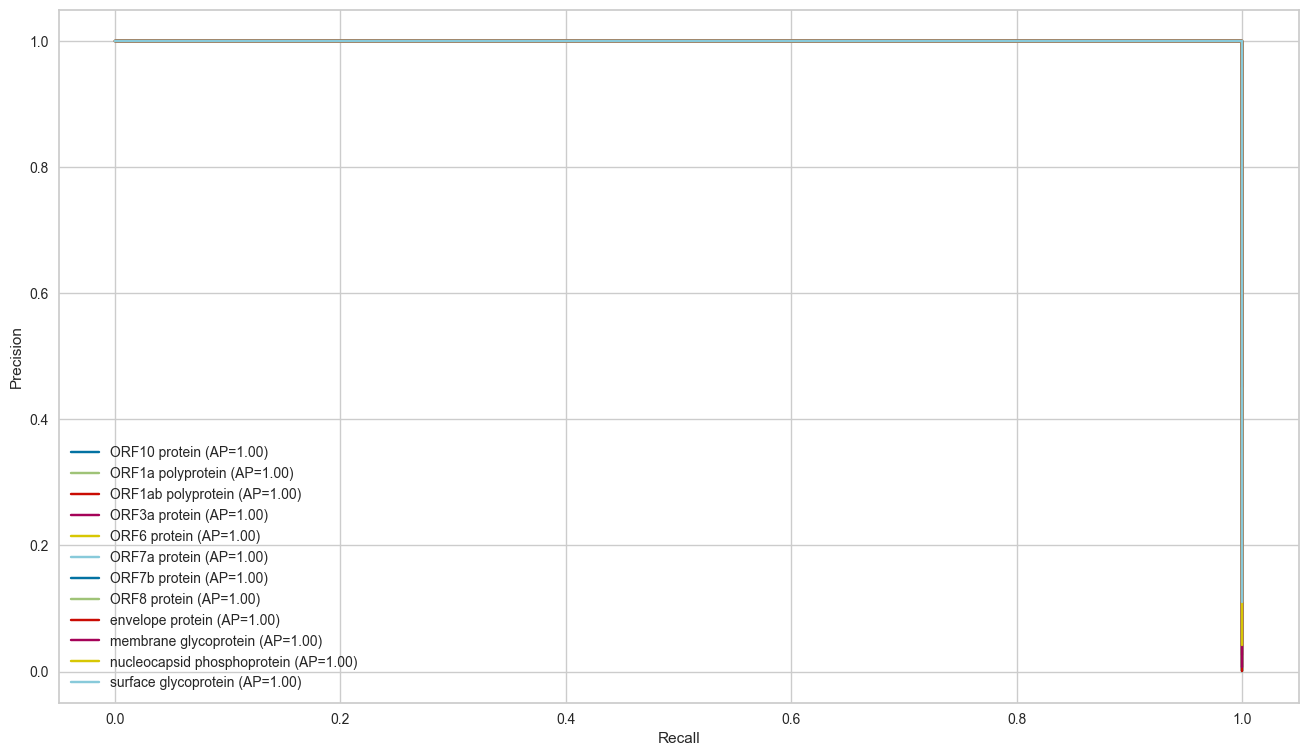

In [83]:
y_scores = clf.predict_proba(X_test)
y_onehot = pd.DataFrame(ohe.transform(y_test), columns=ohe.classes_)

_ = plt.figure(figsize=(16, 9))

for i in range(y_scores.shape[1]):
    y_true = y_onehot.iloc[:, i]
    y_score = y_scores[:, i]

    precision, recall, _ = prec_rec_crve(y_true, y_score)
    ap_score = average_precision_score(y_true, y_score)
    name = f'{y_onehot.columns[i]} (AP={ap_score:.2f})'

    name = f'{y_onehot.columns[i]} (AP={ap_score:.2f})'
    plt.plot(recall, precision, label=name)
    
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend()
plt.show()

Važnost atributa za test skup podataka.

In [84]:
explainer = dx.Explainer(clf.best_estimator_,
                         X_train_sample,
                         enc.transform(y_train_sample),
                         model_type='classification',
                         label='Variable importance measures for XGBClassifier',
                         verbose=False)

In [85]:
mp_clf = explainer.model_parts(N=sample,
                               B=start,
                               type='shap_wrapper',
                               shap_explainer_type='KernelExplainer',
                               loss_function=lambda a, b: 1-balanced_accuracy_score(a, b),
                               processes=-1,
                               random_state=seed,
                               data=X_test,
                               silent=True)

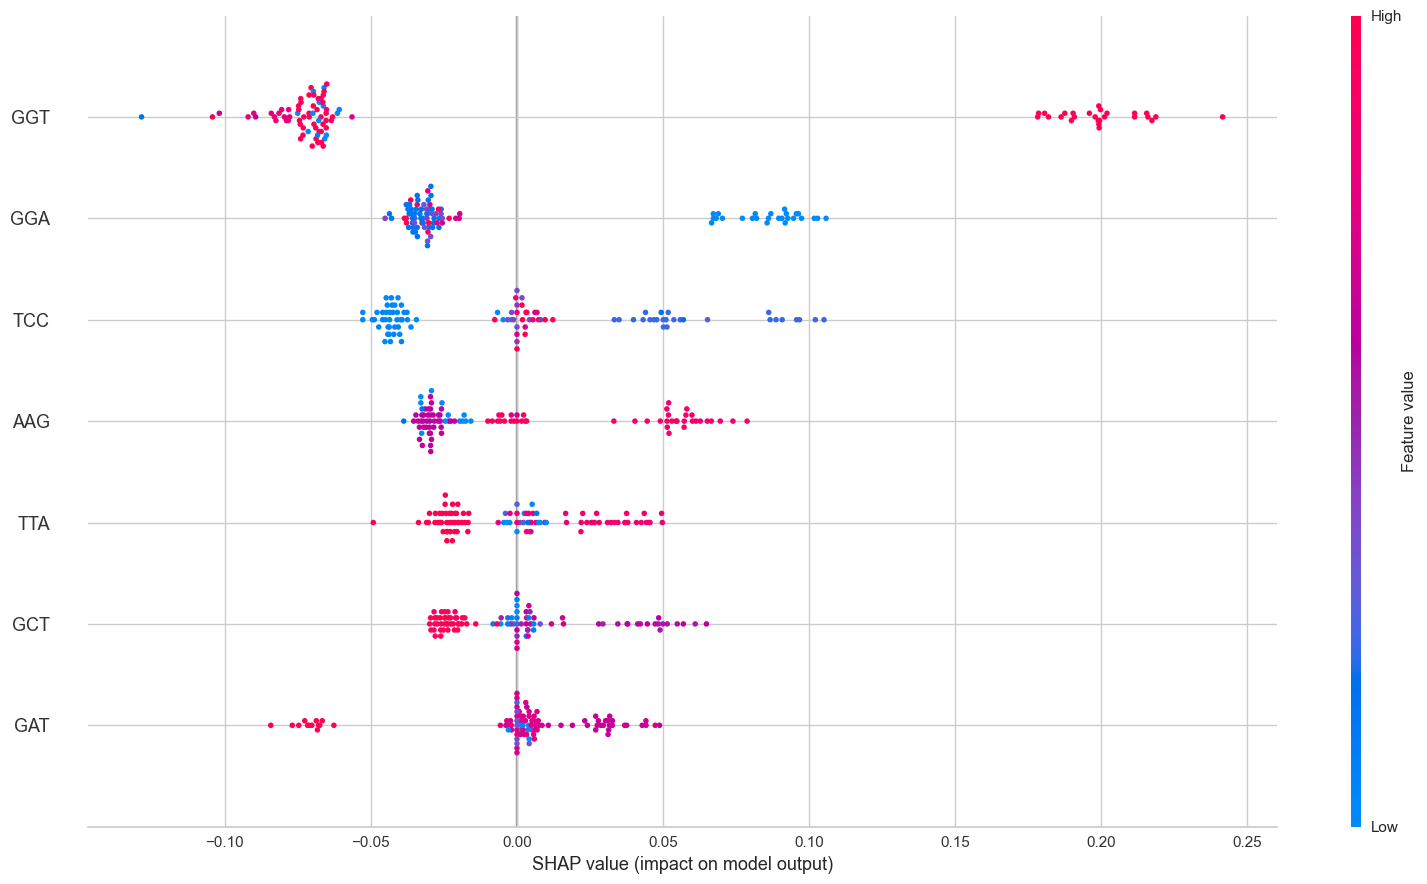

In [86]:
mp_clf.plot(max_display=n_features,
            plot_size=(16, 9),
            title='Variable importance measures for XGBClassifier')

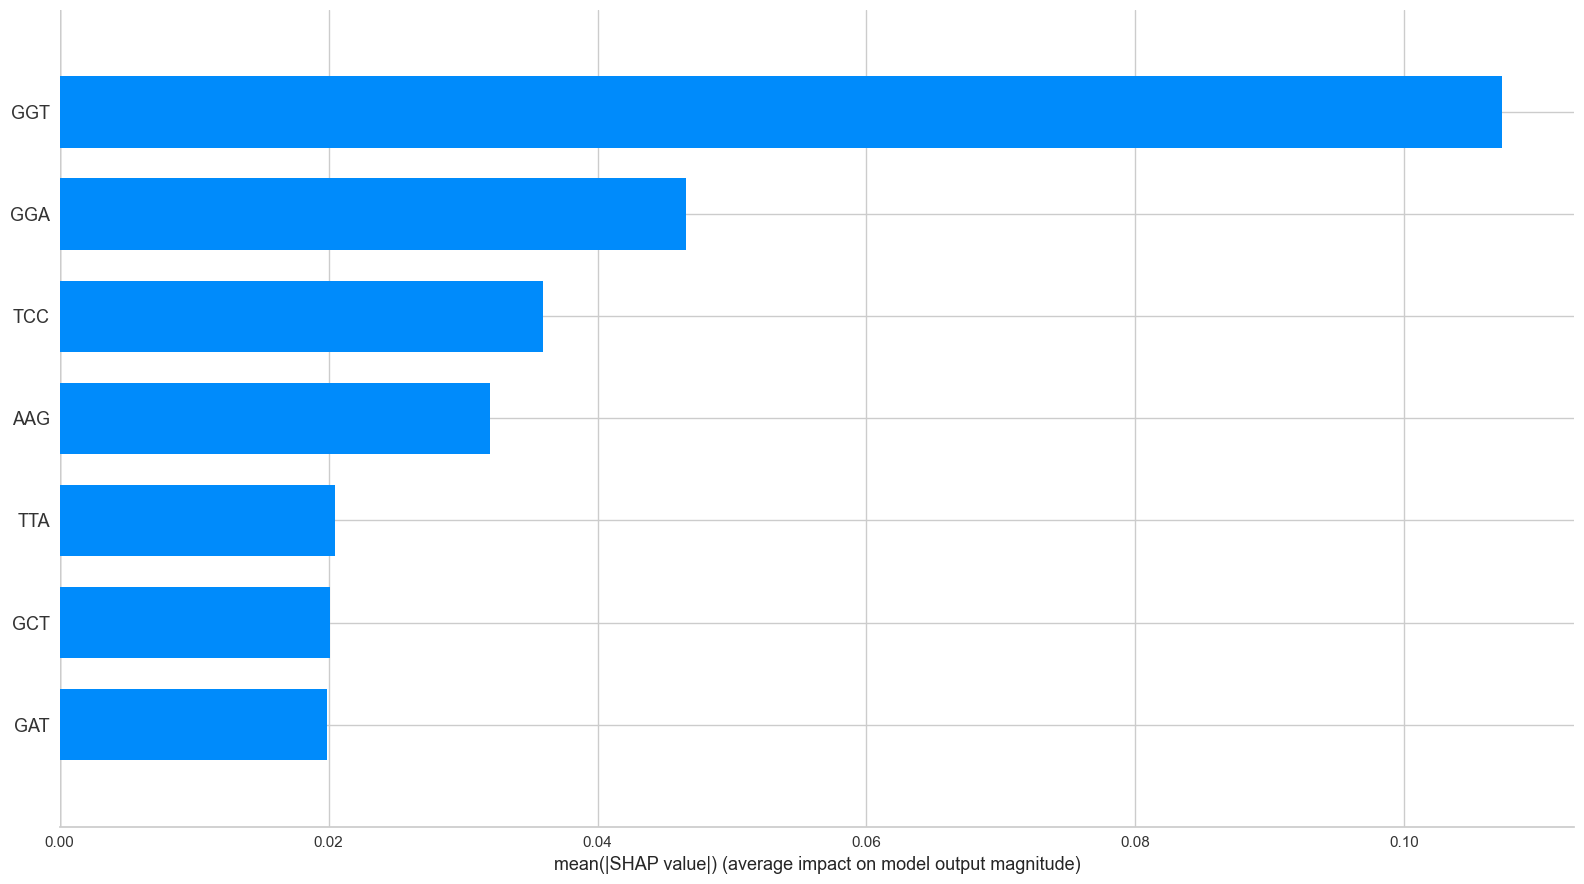

In [87]:
mp_clf.plot(plot_type='bar',
            max_display=n_features,
            plot_size=(16, 9),
            title='Variable importance measures for XGBClassifier')

### Linear Support Vector Machine

Parameters for cross-validation.

In [88]:
params = {'C': Continuous(0, 1e3, random_state=seed),
          'intercept_scaling': Continuous(0, 1e3, random_state=seed)}

Applying genetic search cross-validation algorithm.

In [89]:
clf = GASearchCV(LinearSVC(dual='auto',
                           class_weight='balanced',
                           tol=t_stop,
                           max_iter=maxiter,
                           random_state=seed),
                 param_grid=params,
                 scoring='balanced_accuracy',
                 population_size=pops,
                 generations=maxiter,
                 tournament_size=tous,
                 elitism=True,
                 crossover_probability=crossover_adapter,
                 mutation_probability=mutation_adapter,
                 cv=cross_validation_generator,
                 algorithm='eaSimple',
                 n_jobs=-1,
                 verbose=False)

_ = clf.fit(X_train,
            y_train,
            callbacks=stopping_condition)

INFO: DeltaThreshold callback met its criteria
INFO: Stopping the algorithm


Parameters for the best model.

In [90]:
display_best_parameters(clf)

C: 69.41072277695537, intercept_scaling: 6.491647633592557


Classification report for training data.

In [91]:
print(classification_report(y_true=y_train,
                            y_pred=clf.predict(X_train),
                            digits=5,
                            zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    1.00000   0.99176   0.99586       364
          ORF1a polyprotein    1.00000   1.00000   1.00000    241372
         ORF1ab polyprotein    0.99999   1.00000   1.00000    314439
              ORF3a protein    1.00000   1.00000   1.00000     18476
               ORF6 protein    1.00000   1.00000   1.00000      1098
              ORF7a protein    1.00000   1.00000   1.00000      3937
              ORF7b protein    1.00000   1.00000   1.00000       743
               ORF8 protein    1.00000   1.00000   1.00000      3831
           envelope protein    1.00000   0.99848   0.99924       658
      membrane glycoprotein    1.00000   1.00000   1.00000      5083
nucleocapsid phosphoprotein    1.00000   1.00000   1.00000     29103
       surface glycoprotein    1.00000   1.00000   1.00000     76782

                   accuracy                        0.99999    695886
                  macro avg    1

Confusion matrix for training data.

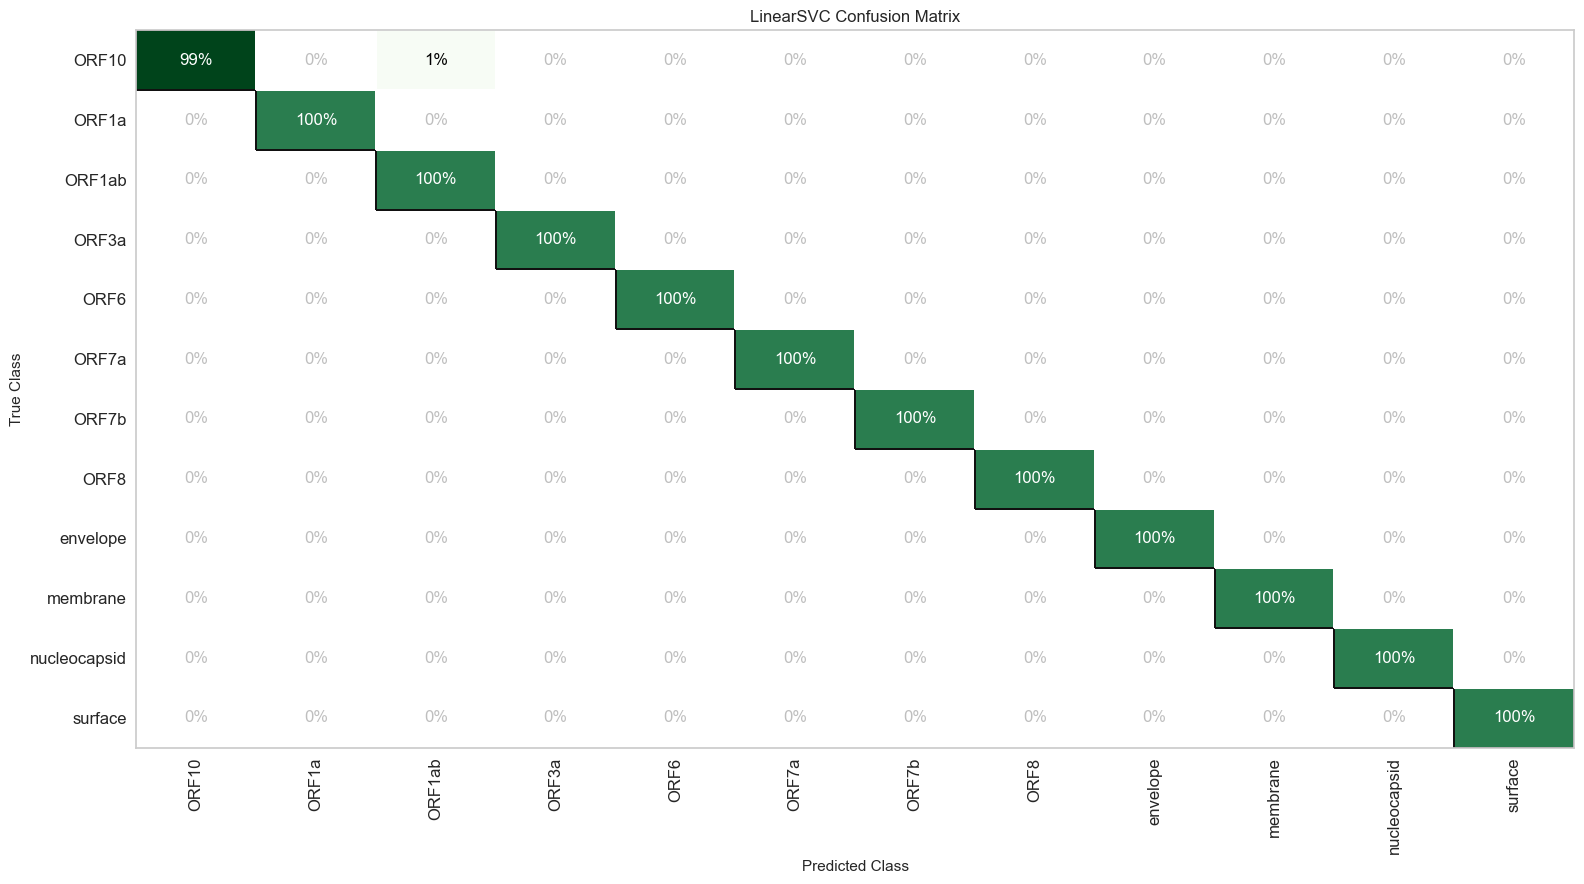

In [92]:
_ = plt.figure(figsize=(16, 9))

_ = confusion_matrix(clf.best_estimator_,
                     X_train,
                     y_train,
                     classes=labels2display,
                     cmap='Greens',
                     percent=True,
                     is_fitted=True)

Precision-recall curves for training data.

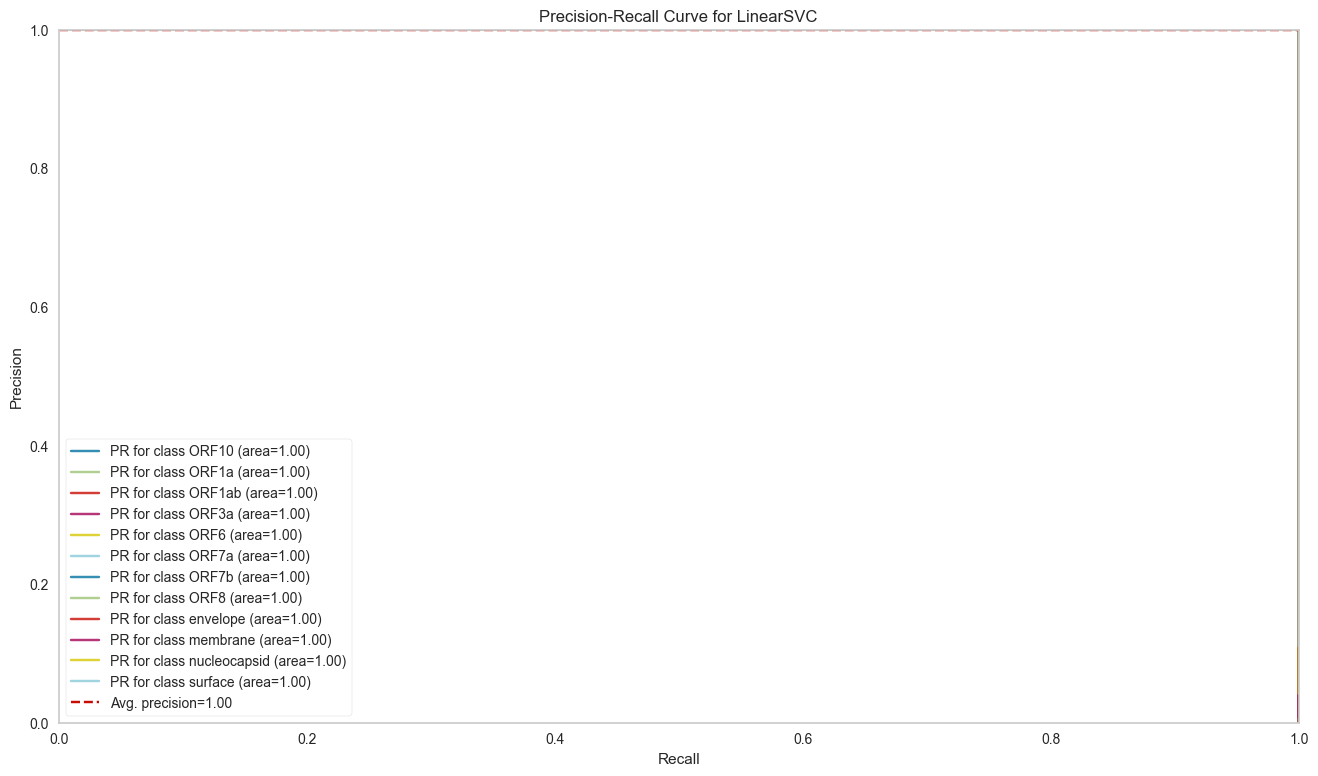

In [93]:
_ = plt.figure(figsize=(16, 9))

_ = precision_recall_curve(clf.best_estimator_,
                           X_train,
                           y_train,
                           per_class=True,
                           classes=labels2display)

Classification report for test data.

In [94]:
print(classification_report(y_true=y_test,
                            y_pred=clf.predict(X_test),
                            digits=5,
                            zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    1.00000   0.98901   0.99448        91
          ORF1a polyprotein    0.99998   1.00000   0.99999     60343
         ORF1ab polyprotein    0.99999   1.00000   0.99999     78610
              ORF3a protein    1.00000   1.00000   1.00000      4619
               ORF6 protein    1.00000   0.99635   0.99817       274
              ORF7a protein    1.00000   1.00000   1.00000       984
              ORF7b protein    1.00000   1.00000   1.00000       186
               ORF8 protein    1.00000   1.00000   1.00000       958
           envelope protein    1.00000   1.00000   1.00000       164
      membrane glycoprotein    1.00000   1.00000   1.00000      1271
nucleocapsid phosphoprotein    1.00000   1.00000   1.00000      7276
       surface glycoprotein    1.00000   1.00000   1.00000     19196

                   accuracy                        0.99999    173972
                  macro avg    1

Confusion matrix for test data.

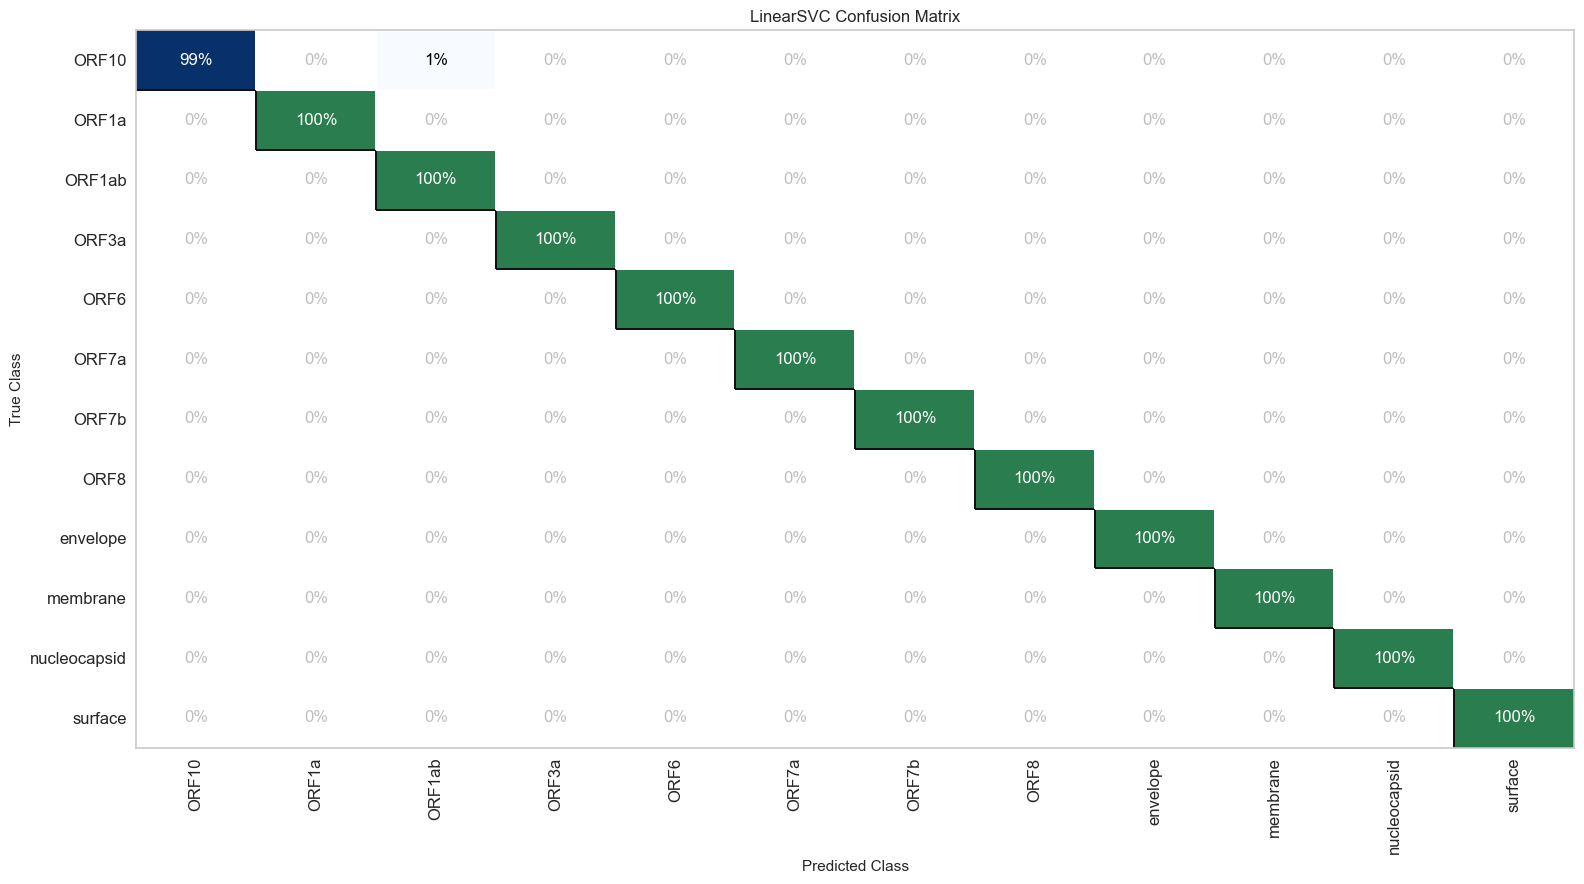

In [95]:
_ = plt.figure(figsize=(16, 9))

_ = confusion_matrix(clf.best_estimator_,
                     X_test,
                     y_test,
                     classes=labels2display,
                     cmap='Blues',
                     percent=True,
                     is_fitted=True)

Precision-recall curves for test data.

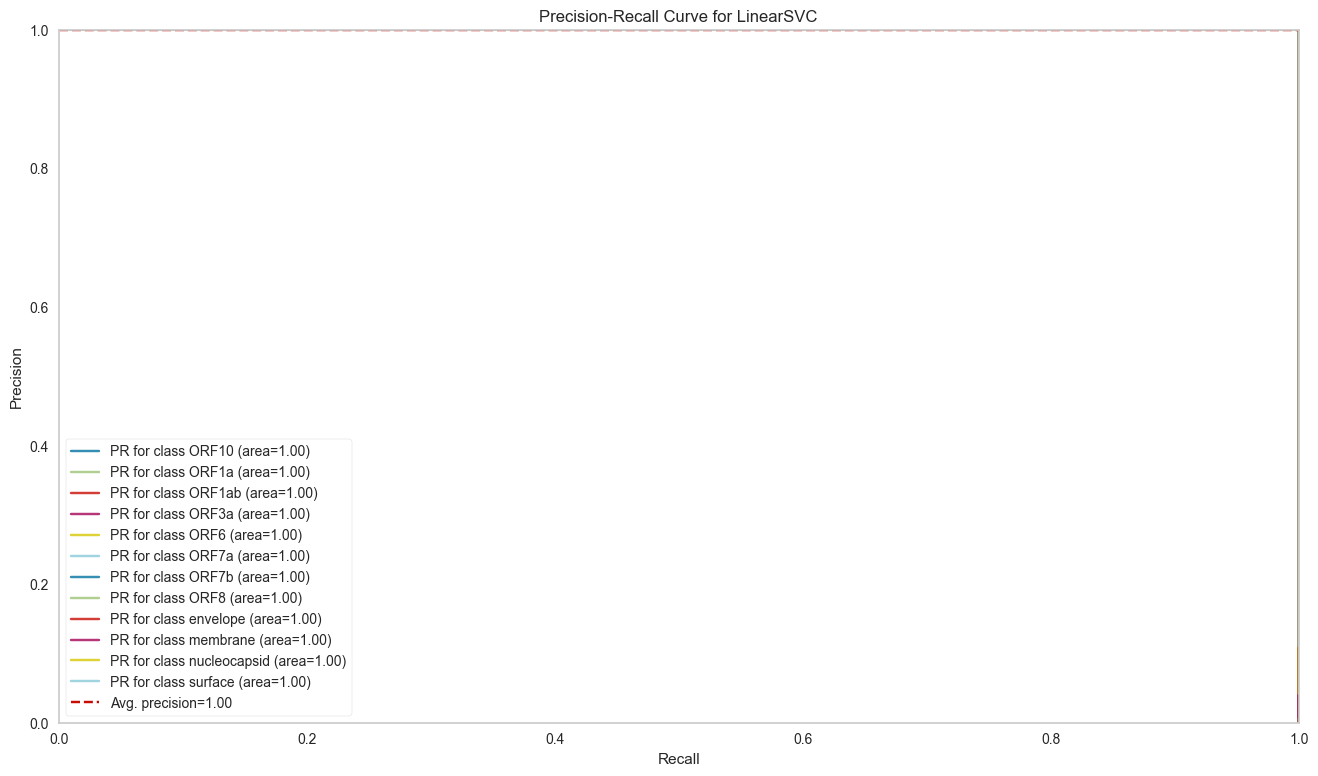

In [96]:
_ = plt.figure(figsize=(16, 9))

_ = precision_recall_curve(clf.best_estimator_,
                           X_train,
                           y_train,
                           per_class=True,
                           classes=labels2display)

Variable importances.

In [97]:
explainer = dx.Explainer(clf,
                         X_train_sample,
                         enc.transform(y_train_sample),
                         predict_function=lambda a, b: enc.transform(a.predict(b)),
                         model_type='classification',
                         label='Variable importance measures for LinearSVC',
                         verbose=False)

In [98]:
mp_clf = explainer.model_parts(N=sample,
                               B=start,
                               type='shap_wrapper',
                               shap_explainer_type='KernelExplainer',
                               loss_function=lambda a, b: 1-balanced_accuracy_score(a, b),
                               processes=-1,
                               random_state=seed,
                               data=X_test,
                               silent=True)

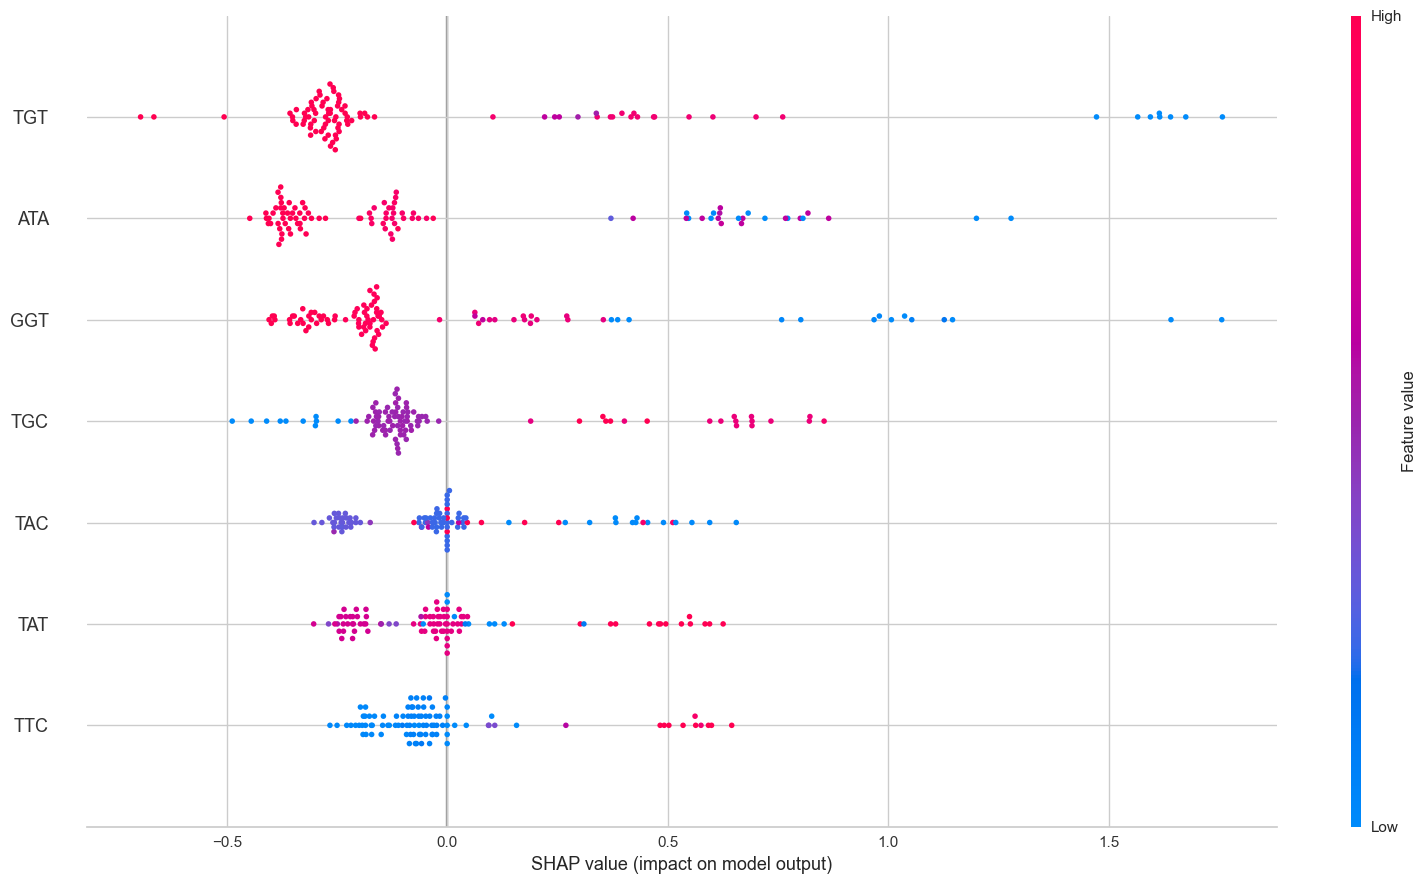

In [99]:
mp_clf.plot(max_display=n_features,
            plot_size=(16, 9),
            title='Variable importance measures for LinearSVC')

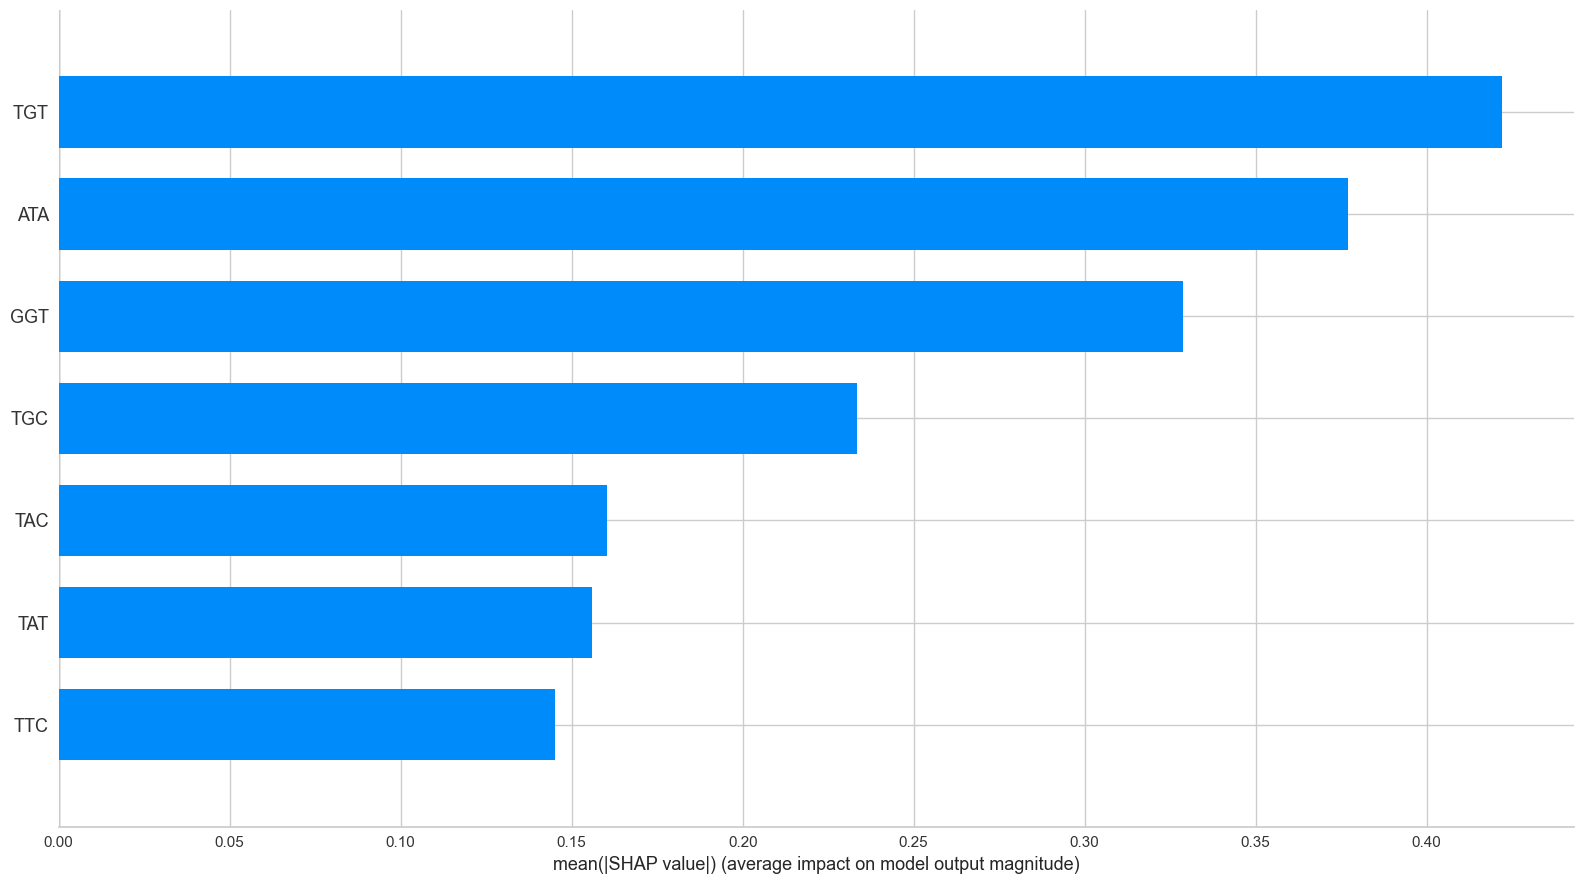

In [100]:
mp_clf.plot(plot_type='bar',
            max_display=n_features,
            plot_size=(16, 9),
            title='Variable importance measures for LinearSVC')

### Artificial Neural Networks

Wrapper library *scikeras* provides *scikit-learn* high-level API for *tensorflow*/*keras* underlying library.

In [101]:
def get_model(hidden_layer_dim,
              dropout_rate,
              activation_function,
              meta):
    model = Sequential()
    model.add(Dense(meta['n_features_in_'],
                    input_shape=meta['X_shape_'][1:],
                    activation=activation_function))
    model.add(Dropout(dropout_rate,
                      seed=seed))
    model.add(Dense(hidden_layer_dim,
                    activation=activation_function))
    model.add(Dropout(dropout_rate,
                      seed=seed))
    model.add(Dense(hidden_layer_dim,
                    activation=activation_function))
    model.add(Dropout(dropout_rate,
                      seed=seed))
    model.add(Dense(hidden_layer_dim,
                    activation=activation_function))
    model.add(Dropout(dropout_rate,
                      seed=seed))
    model.add(Dense(hidden_layer_dim,
                    activation=activation_function))
    model.add(Dropout(dropout_rate,
                      seed=seed))
    model.add(Dense(meta['n_classes_'],
                    activation='softmax'))
    
    return model

Parameters for the cross-valudation.

In [102]:
params = {'loss': ['categorical_hinge',
                   'categorical_crossentropy'],
          'activation_function': ['relu',
                                  'sigmoid']}

Applying the cross-validation algorithm.

In [103]:
clf = GridSearchCV(KerasClassifier(get_model,
                                   optimizer='adam',
                                   dropout_rate=0.2,
                                   hidden_layer_dim=757,
                                   activation_function='relu',
                                   # class_weight='balanced', # causes warnings
                                   metrics=Recall,
                                   epochs=maxiter,
                                   callbacks=early_stopping,
                                   validation_split=0.2,
                                   batch_size=-1,
                                   verbose=0,
                                   random_state=seed),
                   param_grid=params,
                   scoring=lambda a, b: balanced_accuracy_score(ohe.inverse_transform(a),
                                                                ohe.inverse_transform(b)),
                   cv=cross_validation_generator,
                   n_jobs=2)

_ = clf.fit(X_train,
            ohe.transform(y_train))

Parameters for the best model.

In [104]:
display_best_parameters(clf)

activation_function: relu, loss: categorical_hinge


Classification report for training data.

In [105]:
print(classification_report(y_true=y_train,
                            y_pred=ohe.inverse_transform(clf.predict(X_train)),
                            digits=5,
                            zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    0.99452   0.99725   0.99588       364
          ORF1a polyprotein    1.00000   1.00000   1.00000    241372
         ORF1ab polyprotein    1.00000   1.00000   1.00000    314439
              ORF3a protein    1.00000   1.00000   1.00000     18476
               ORF6 protein    1.00000   0.99909   0.99954      1098
              ORF7a protein    0.99975   1.00000   0.99987      3937
              ORF7b protein    1.00000   1.00000   1.00000       743
               ORF8 protein    1.00000   0.99974   0.99987      3831
           envelope protein    1.00000   1.00000   1.00000       658
      membrane glycoprotein    1.00000   1.00000   1.00000      5083
nucleocapsid phosphoprotein    1.00000   1.00000   1.00000     29103
       surface glycoprotein    1.00000   1.00000   1.00000     76782

                   accuracy                        1.00000    695886
                  macro avg    0

Confusion matrix for training data.

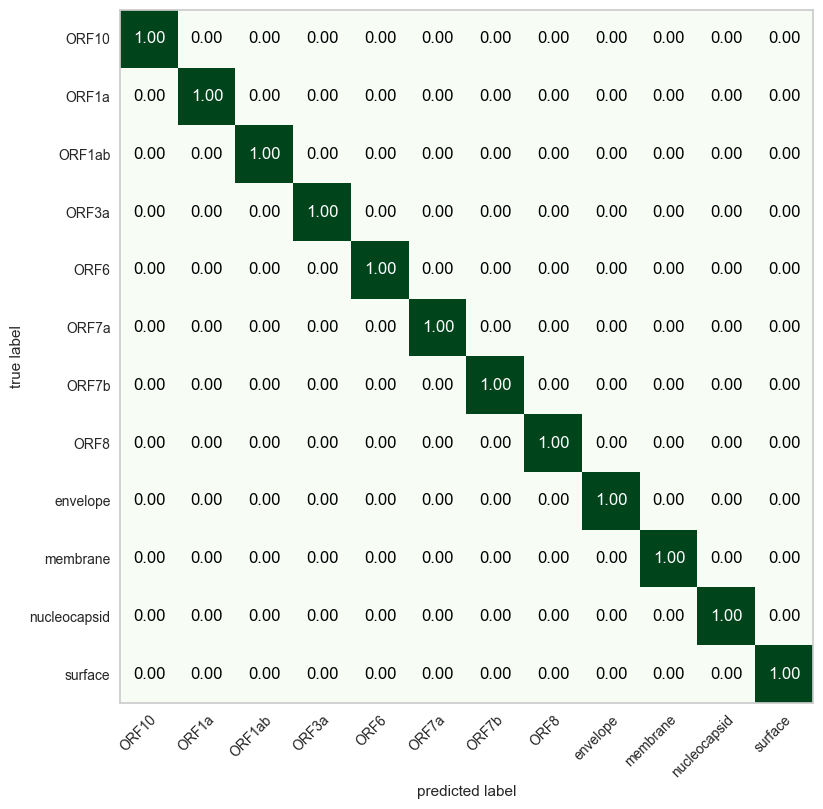

In [106]:
_ = plot_confusion_matrix(conf_mat=conf_matrx(y_target=y_train,
                                              y_predicted=ohe.inverse_transform(clf.predict(X_train))),
                          figsize=(16, 9),
                          cmap='Greens',
                          show_absolute=False,
                          show_normed=True,
                          class_names=labels2display)

Precision-recall curves for training data.

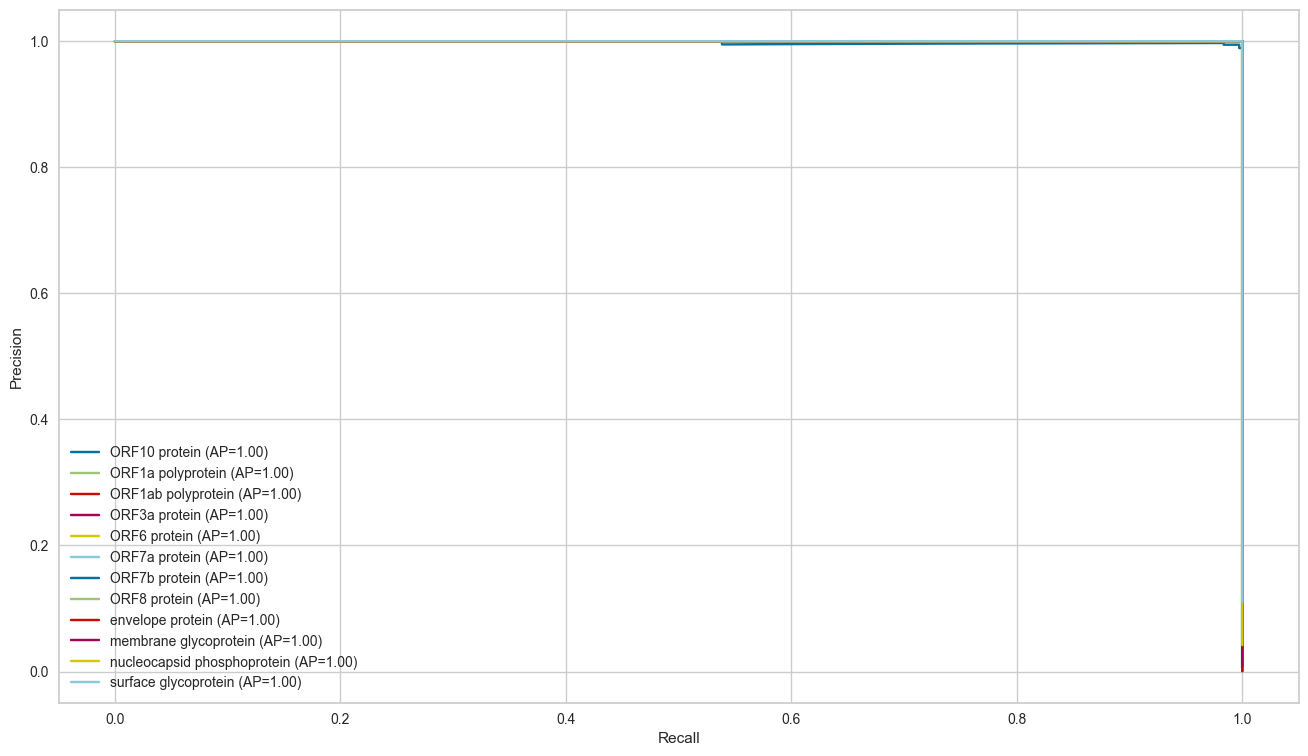

In [107]:
y_scores = clf.predict_proba(X_train)
y_onehot = pd.DataFrame(ohe.transform(y_train), columns=ohe.classes_)

_ = plt.figure(figsize=(16, 9))

for i in range(y_scores.shape[1]):
    y_true = y_onehot.iloc[:, i]
    y_score = y_scores[:, i]

    precision, recall, _ = prec_rec_crve(y_true, y_score)
    ap_score = average_precision_score(y_true, y_score)
    name = f'{y_onehot.columns[i]} (AP={ap_score:.2f})'

    name = f'{y_onehot.columns[i]} (AP={ap_score:.2f})'
    plt.plot(recall, precision, label=name)
    
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend()
plt.show()

Classification report for test data.

In [108]:
print(classification_report(y_true=y_test,
                            y_pred=ohe.inverse_transform(clf.predict(X_test)),
                            digits=5,
                            zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    1.00000   0.98901   0.99448        91
          ORF1a polyprotein    1.00000   1.00000   1.00000     60343
         ORF1ab polyprotein    1.00000   1.00000   1.00000     78610
              ORF3a protein    1.00000   1.00000   1.00000      4619
               ORF6 protein    1.00000   1.00000   1.00000       274
              ORF7a protein    0.99898   1.00000   0.99949       984
              ORF7b protein    1.00000   1.00000   1.00000       186
               ORF8 protein    1.00000   1.00000   1.00000       958
           envelope protein    1.00000   1.00000   1.00000       164
      membrane glycoprotein    1.00000   1.00000   1.00000      1271
nucleocapsid phosphoprotein    1.00000   1.00000   1.00000      7276
       surface glycoprotein    1.00000   1.00000   1.00000     19196

                   accuracy                        0.99999    173972
                  macro avg    0

Confusion matrix for test data.

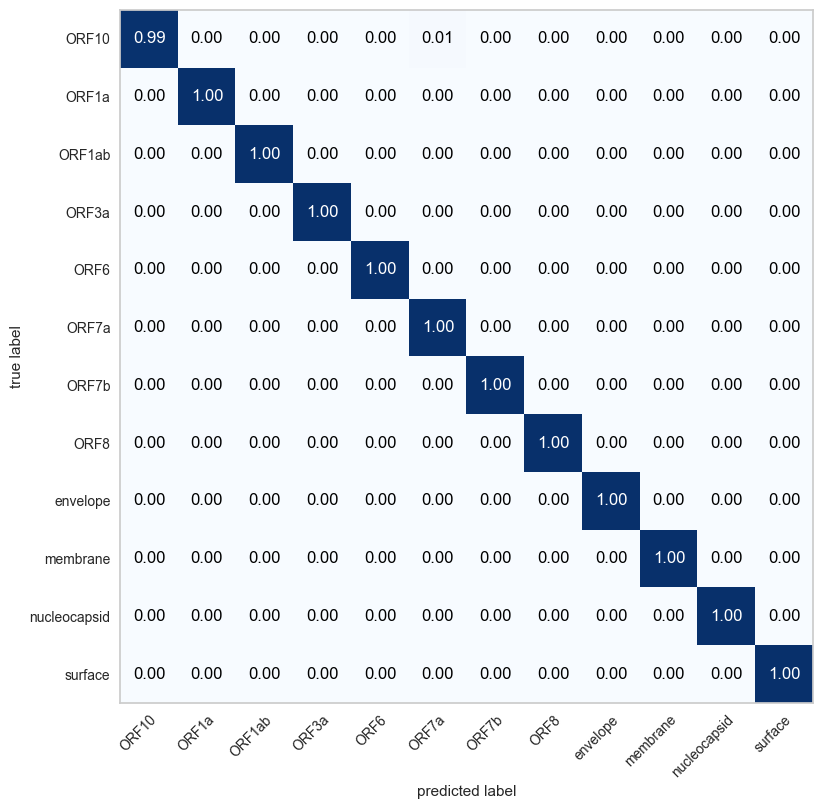

In [109]:
_ = plot_confusion_matrix(conf_mat=conf_matrx(y_target=y_test,
                                              y_predicted=ohe.inverse_transform(clf.predict(X_test))),
                          figsize=(16, 9),
                          cmap='Blues',
                          show_absolute=False,
                          show_normed=True,
                          class_names=labels2display)

Precision-recall curves for test data.

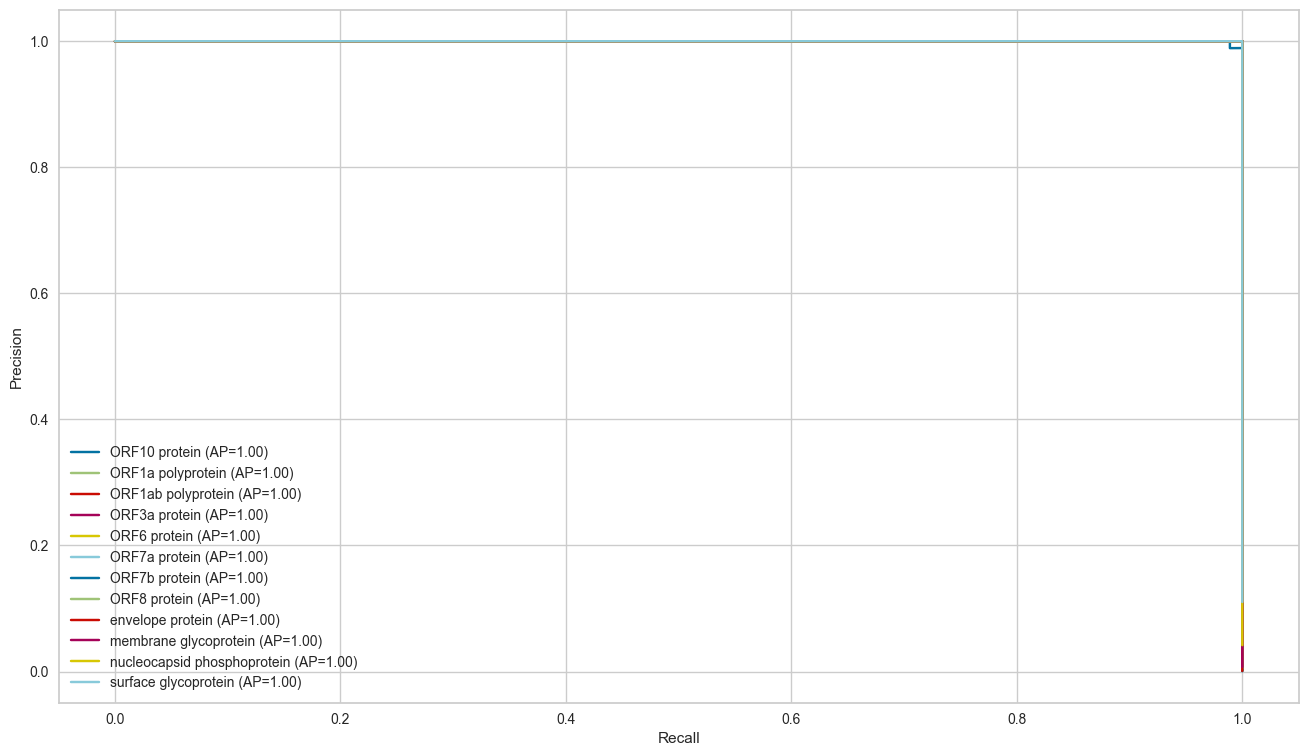

In [110]:
y_scores = clf.predict_proba(X_test)
y_onehot = pd.DataFrame(ohe.transform(y_test), columns=ohe.classes_)

_ = plt.figure(figsize=(16, 9))

for i in range(y_scores.shape[1]):
    y_true = y_onehot.iloc[:, i]
    y_score = y_scores[:, i]

    precision, recall, _ = prec_rec_crve(y_true, y_score)
    ap_score = average_precision_score(y_true, y_score)
    name = f'{y_onehot.columns[i]} (AP={ap_score:.2f})'

    name = f'{y_onehot.columns[i]} (AP={ap_score:.2f})'
    plt.plot(recall, precision, label=name)
    
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend()
plt.show()

Feature importances.

In [111]:
explainer = dx.Explainer(clf.best_estimator_,
                         X_train_sample,
                         enc.transform(y_train_sample),
                         predict_function=lambda a, b: enc.transform(ohe.inverse_transform(a.predict(b))),
                         model_type='classification',
                         label='Variable importance measures for KerasClassifier',
                         verbose=False)

In [112]:
mp_clf = explainer.model_parts(N=sample,
                               B=start,
                               type='shap_wrapper',
                               shap_explainer_type='KernelExplainer',
                               loss_function=lambda a, b: 1-balanced_accuracy_score(a, b),
                               processes=-1,
                               random_state=seed,
                               data=X_test,
                               silent=True)

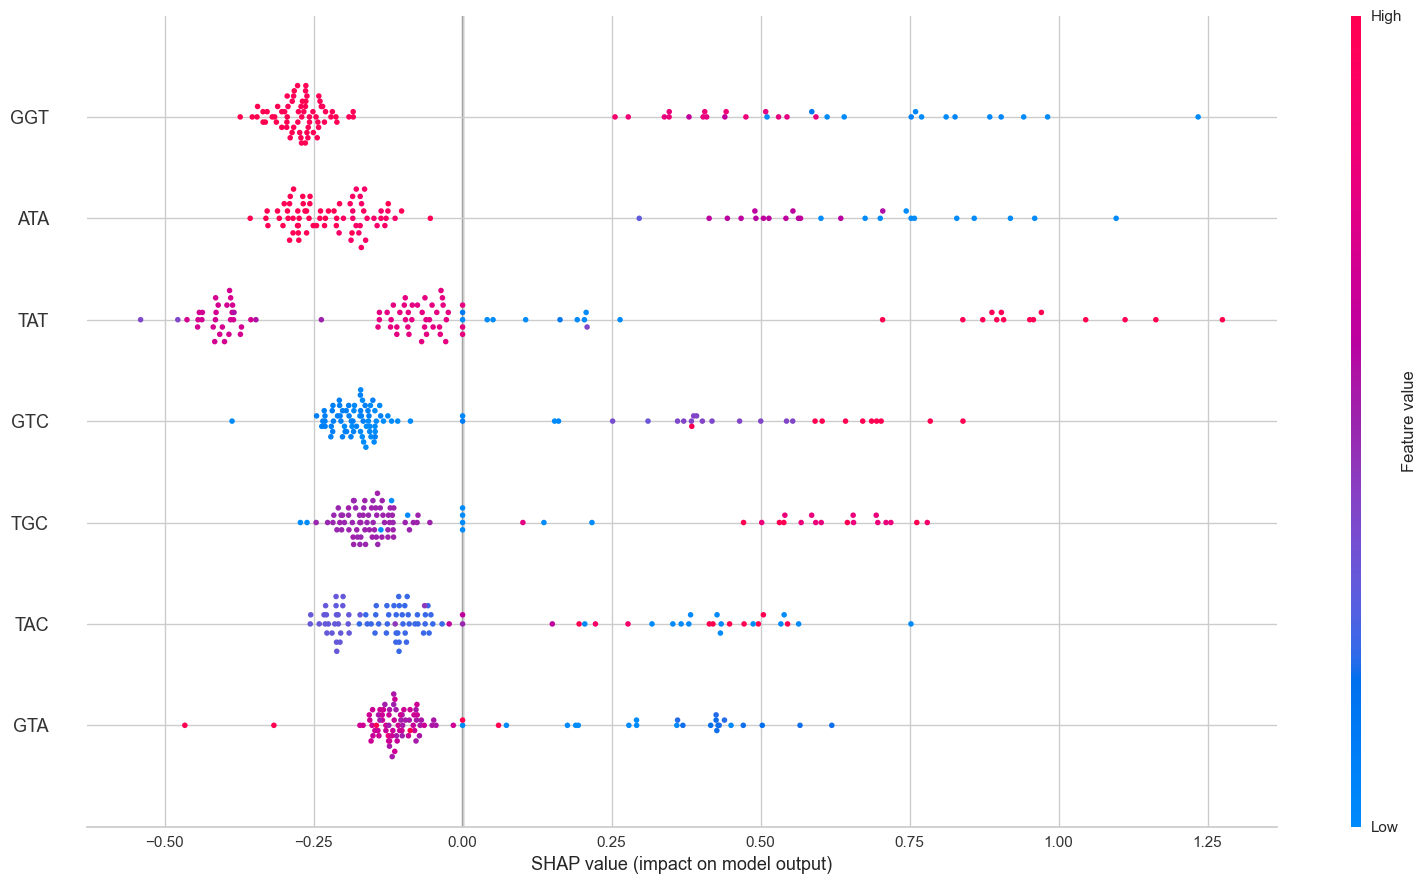

In [113]:
mp_clf.plot(max_display=n_features,
            plot_size=(16, 9),
            title='Variable importance measures for KerasClassifier')

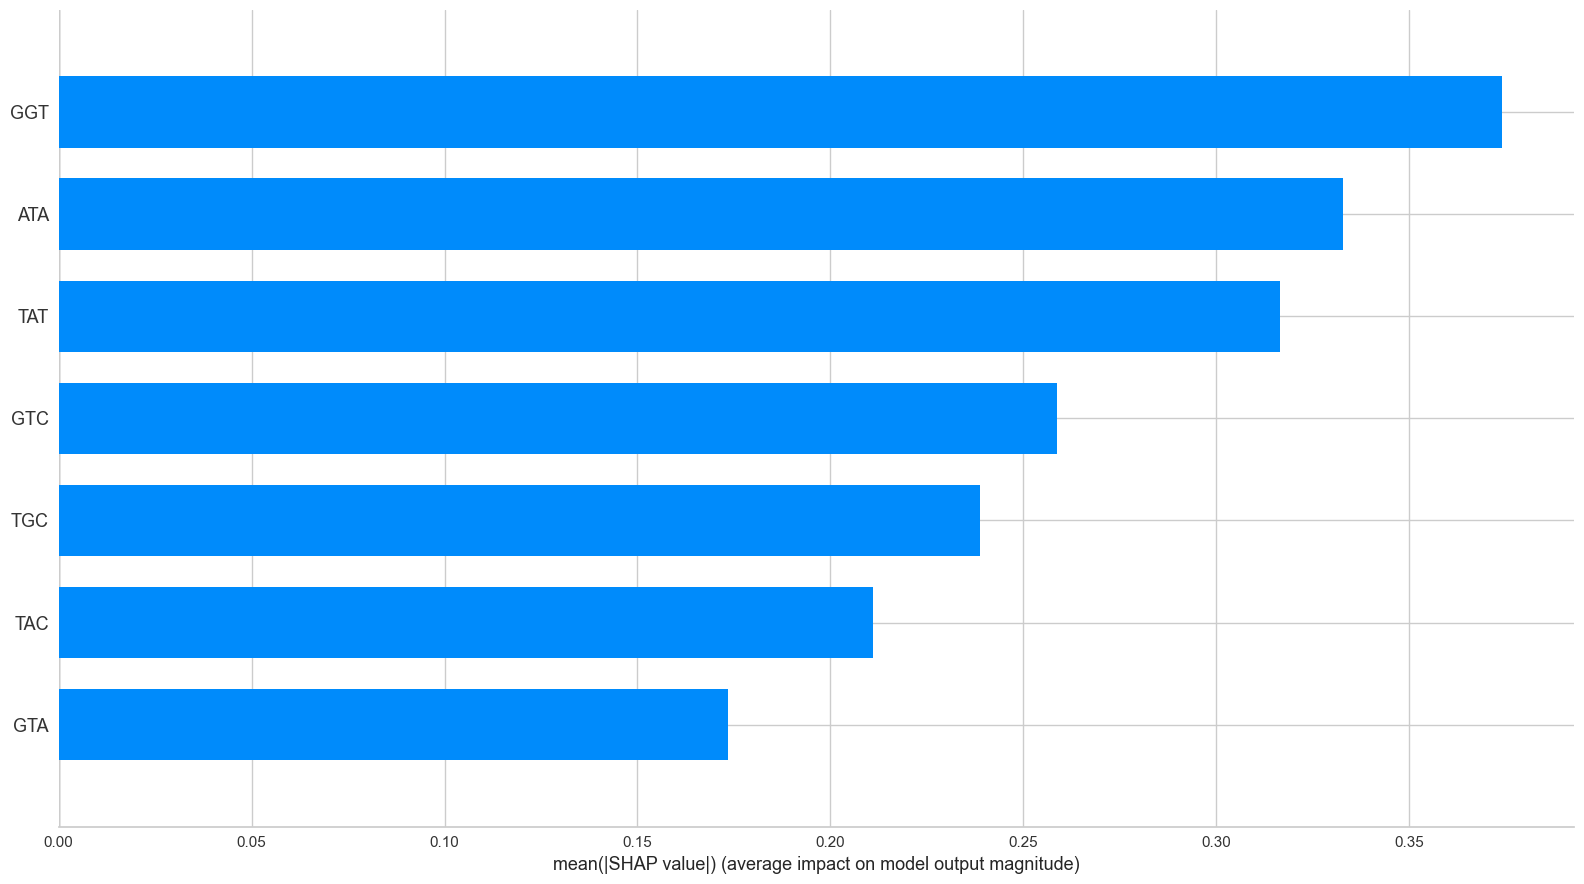

In [114]:
mp_clf.plot(plot_type='bar',
            max_display=n_features,
            plot_size=(16, 9),
            title='Variable importance measures for KerasClassifier')

### Aproximate k-Nearest Neighbors

A more efficient implementation of k-Nearest Neighbors search than the one given in *scikit-learn*.
Initially, I tried various implementations based on HSNW search, but I could not find a library that builds indexer deterministically.
*Annoy* indexer might be a bit slower, but at least every time I retrain the classifier, with the same set of parameters, I get the same result.

In [115]:
class AnnoyKNN:
    _estimator_type = "classifier"
    
    def __init__(self,
                 weighted=False,
                 metric='manhattan',
                 k=5,
                 n_trees=128,
                 n_jobs=1,
                 random_state=None):
        assert isinstance(weighted, bool), 'weighted has to be bool'
        assert metric in ('angular',
                          'euclidean',
                          'manhattan',
                          'hamming',
                          'dot'), 'metric can be "angular", "euclidean", "manhattan", "hamming", or "dot"'
        assert isinstance(k, int), 'k has to be int'
        assert isinstance(n_trees, int), 'n_trees has to be int'
        assert isinstance(n_jobs, int), 'n_jobs has to be int'
        assert isinstance(random_state, (int, type(None))), 'random_state has to be int or None'
        
        self.index = None
        self.X = pd.DataFrame()
        self.y = None
        self.classes_ = None
        self.k = k
        self.metric = metric
        self.n_trees = n_trees
        self.n_jobs = n_jobs
        self.weighted = weighted
        self.random_state = random_state

    def __sklearn_clone__(self):
        clone = AnnoyKNN(self.weighted,
                         self.metric,
                         self.k,
                         self.n_trees,
                         self.n_jobs,
                         self.random_state)
        clone.X = self.X
        clone.index = self.index
        
        return clone
    
    def get_params(self, deep=True):
        return {'index': self.index,
                'y': self.y,
                'k': self.k,
                'classes_': self.classes_,
                'metric': self.metric,
                'n_trees': self.n_trees,
                'n_jobs': self.n_jobs,
                'weighted': self.weighted,
                'random_state': self.random_state}
    
    def set_params(self, **params):
        for key, val in params.items():
            if key in ('metric',
                       'n_trees',
                       'random_state'):
                self.index = None
            self.__dict__[key] = val

        assert isinstance(self.weighted, bool), 'weighted has to be bool'
        assert self.metric in ('angular',
                               'euclidean',
                               'manhattan',
                               'hamming',
                               'dot'), 'metric can be "angular", "euclidean", "manhattan", "hamming", or "dot"'
        assert isinstance(self.k, int), 'k has to be int'
        assert isinstance(self.n_trees, int), 'n_trees has to be int'
        assert isinstance(self.n_jobs, int), 'n_jobs has to be int'
        assert isinstance(self.random_state, (int, type(None))), 'random_state has to be int or None'
        assert isinstance(self.X, (pd.DataFrame, np.ndarray)), 'X has to be pandas DataFrame or numpy array object'
        self.X = self.X if isinstance(self.X, pd.DataFrame) else pd.DataFrame(self.X)
        
        return self

    def fit(self, X, y):
        assert isinstance(X, (pd.DataFrame, np.ndarray)), 'X has to be pandas DataFrame or numpy array object'
        X = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        
        if self.index is None or not X.equals(self.X):
            self.X = X
            
            self.index = AnnoyIndex(X.shape[1], self.metric)
            self.index.set_seed(self.random_state)
            
            for i, v in enumerate(X.to_numpy()):
                self.index.add_item(i, v)
            self.index.build(self.n_trees, self.n_jobs)
            
        assert isinstance(y, (pd.Series, np.ndarray)), 'y has to be pandas Series object'
        self.y = y.to_numpy() if isinstance(y, pd.Series) else y
        self.classes_ = np.unique(self.y)
        
        return self

    def score(self, X, y, sample_weight=None):
        assert self.index is not None, 'first to fit the model you have'
        assert isinstance(X, (pd.DataFrame, np.ndarray)), 'X has to be pandas DataFrame or numpy array object'
        assert isinstance(y, (pd.Series, np.ndarray)), 'y has to be pandas Series or numpy array object'
        
        return balanced_accuracy_score(y_true=y,
                                       y_pred=self.predict(X),
                                       sample_weight=sample_weight)

    def __get_weighted_votes(self, X):
        indices = np.empty((X.shape[0], self.k),
                           dtype=np.int32)
        distances = np.empty((X.shape[0], self.k),
                             dtype=np.float64)
        
        # Annoy is annoying for not having batch query ...
        for i, v in enumerate(X.to_numpy()):
            tmp_i, tmp_d = self.index.get_nns_by_vector(v,
                                                        self.k,
                                                        include_distances=self.weighted)
            indices[i] = np.array(tmp_i,
                                  dtype=np.int32)
            distances[i] = np.array(tmp_d,
                                    dtype=np.float64)
        
        vote = self.y[indices]
        weight = np.reciprocal(distances,
                               where=distances!=0,
                               out=np.zeros_like(distances))
        weighted_votes = [(vote[a], weight[a]) for a in range(indices.shape[0])]
        
        return weighted_votes
    
    def __get_unweighted_votes(self, X):        
        indices = np.empty((X.shape[0], self.k),
                           dtype=np.int32)
        
        # Annoy is annoying for not having batch query ...
        for i, v in enumerate(X.to_numpy()):
            tmp_i = self.index.get_nns_by_vector(v,
                                                 self.k,
                                                 include_distances=self.weighted)
            indices[i] = np.array(tmp_i,
                                  dtype=np.int32)
        
        unweighted_votes = self.y[indices]
        
        return unweighted_votes

    def predict(self, X):
        assert isinstance(X, (pd.DataFrame, np.ndarray)), 'X has to be pandas DataFrame or numpy array object'
        X = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        predictions = None
        
        if self.weighted:
            votes = self.__get_weighted_votes(X)
            
            predictions = np.array([np.argmax(np.bincount(a,
                                                          weights=b)) for a, b in votes],
                                   dtype=np.int32)
        else:
            votes = self.__get_unweighted_votes(X)
            
            predictions = np.array([np.argmax(np.bincount(a)) for a in votes],
                                   dtype=np.int32)
            
        return pd.Series(predictions)
    
    def predict_proba(self, X):
        assert isinstance(X, (pd.DataFrame, np.ndarray)), 'X has to be pandas DataFrame or numpy array object'
        X = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        probabilities = None
        
        if self.weighted:
            votes = self.__get_weighted_votes(X)
            
            numerator = np.array([np.bincount(a,
                                              weights=b,
                                              minlength=self.classes_.shape[0]) for a, b in votes])
            denominator = np.array([a.sum() for a in numerator])
            probabilities = np.array([a / b for a, b in zip(numerator, denominator)])
        else:
            votes = self.__get_unweighted_votes(X)

            numerator = np.array([np.bincount(a,
                                              minlength=self.classes_.shape[0]) for a in votes])
            denominator = self.k
            probabilities = numerator / denominator
            
        return probabilities

Parameters for cross-validation.

In [116]:
params = [{'k': [5, 13, 23, 31],
          'weighted': [True, False]}]

Applying genetic search cross-validation algorithm.

In [117]:
clf = GridSearchCV(AnnoyKNN(n_jobs=-1,
                            random_state=seed),
                   param_grid=params,
                   scoring='balanced_accuracy',
                   cv=cross_validation_generator)

_ = clf.fit(X_train,
            enc.transform(y_train))

Parameters of the best model.

In [118]:
display_best_parameters(clf)

k: 5, weighted: False


Classification report for training data.

In [119]:
print(classification_report(y_true=y_train,
                            y_pred=enc.inverse_transform(clf.predict(X_train)),
                            digits=5,
                            zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    1.00000   1.00000   1.00000       364
          ORF1a polyprotein    1.00000   1.00000   1.00000    241372
         ORF1ab polyprotein    1.00000   1.00000   1.00000    314439
              ORF3a protein    1.00000   1.00000   1.00000     18476
               ORF6 protein    1.00000   1.00000   1.00000      1098
              ORF7a protein    1.00000   1.00000   1.00000      3937
              ORF7b protein    0.99866   1.00000   0.99933       743
               ORF8 protein    1.00000   0.99974   0.99987      3831
           envelope protein    1.00000   1.00000   1.00000       658
      membrane glycoprotein    1.00000   1.00000   1.00000      5083
nucleocapsid phosphoprotein    1.00000   1.00000   1.00000     29103
       surface glycoprotein    1.00000   1.00000   1.00000     76782

                   accuracy                        1.00000    695886
                  macro avg    0

Confusion matrix for training data.

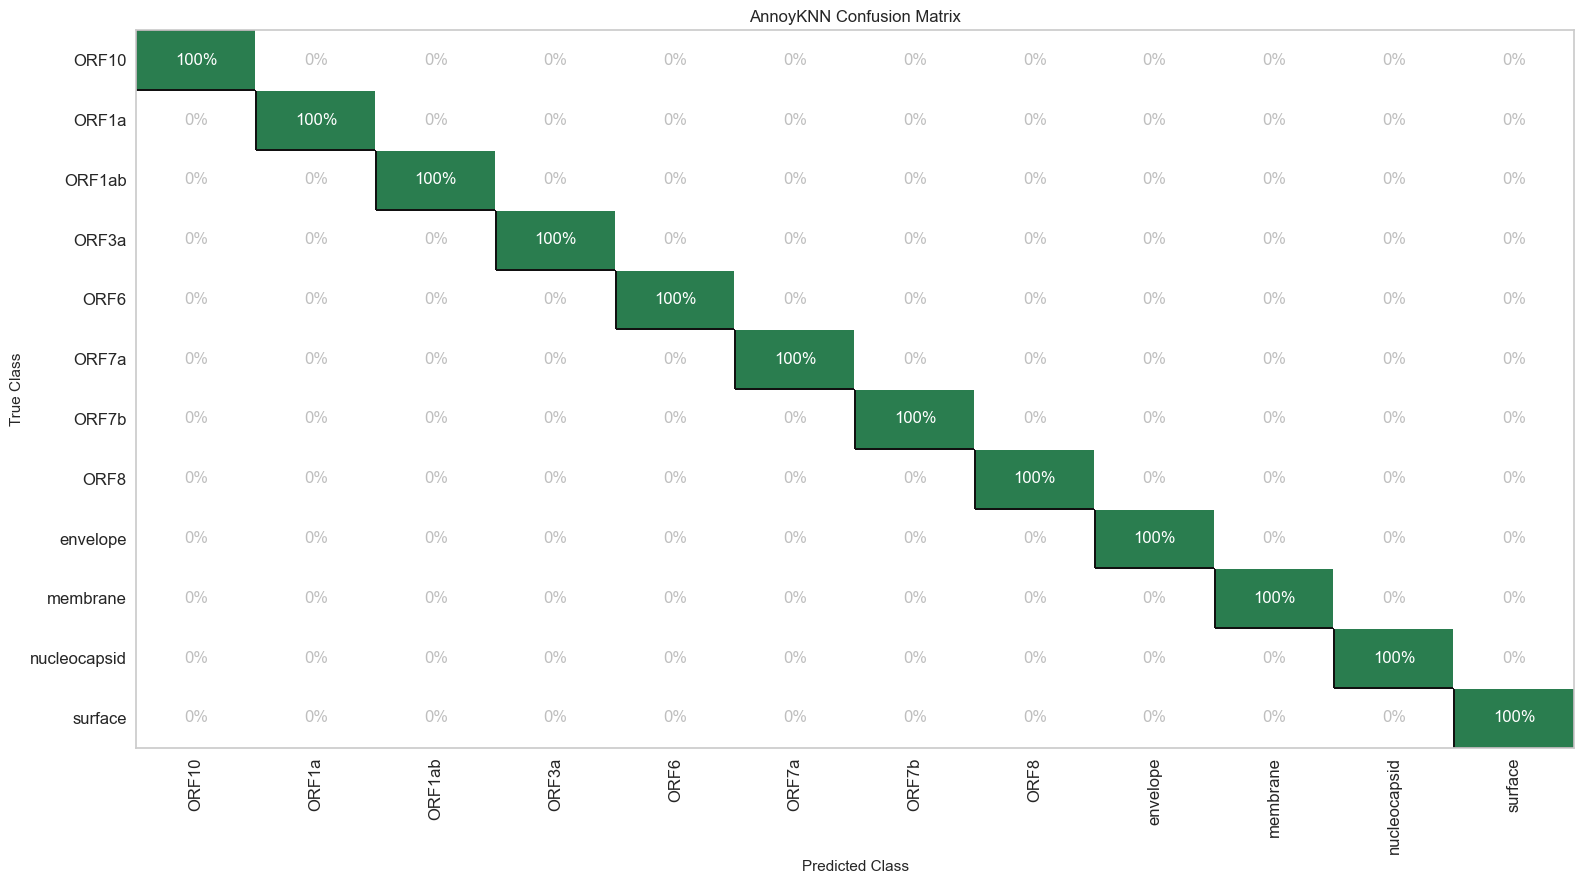

In [120]:
_ = plt.figure(figsize=(16, 9))

_ = confusion_matrix(classifier(clf.best_estimator_),
                     X_train,
                     enc.transform(y_train),
                     classes=labels2display,
                     cmap='Greens',
                     percent=True)

Precision-recall curves for training data.

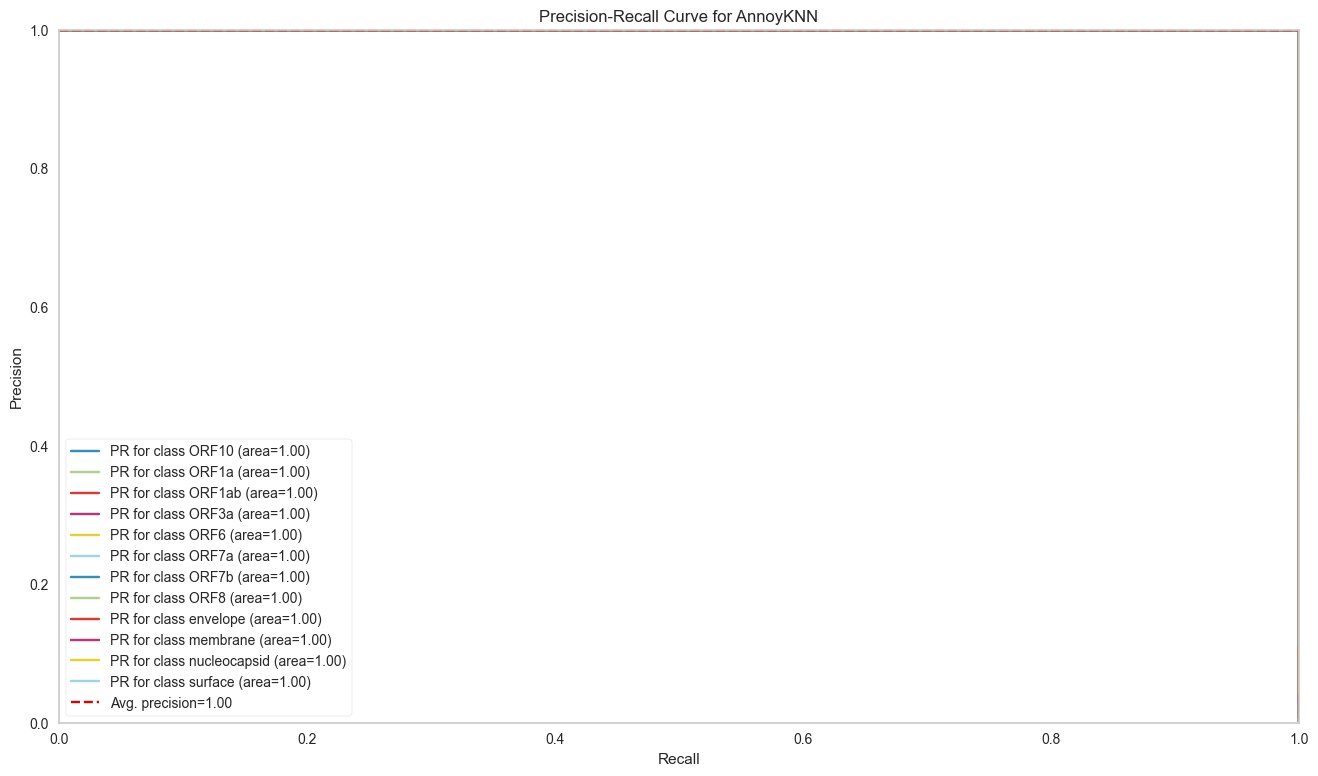

In [121]:
_ = plt.figure(figsize=(16, 9))

_ = precision_recall_curve(classifier(clf.best_estimator_),
                           X_train,
                           enc.transform(y_train),
                           classes=labels2display,
                           per_class=True)

Classification report for test data.

In [122]:
print(classification_report(y_true=y_test,
                            y_pred=enc.inverse_transform(clf.predict(X_test)),
                            digits=5,
                            zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    1.00000   1.00000   1.00000        91
          ORF1a polyprotein    1.00000   1.00000   1.00000     60343
         ORF1ab polyprotein    1.00000   1.00000   1.00000     78610
              ORF3a protein    0.99978   1.00000   0.99989      4619
               ORF6 protein    1.00000   1.00000   1.00000       274
              ORF7a protein    1.00000   0.99898   0.99949       984
              ORF7b protein    1.00000   1.00000   1.00000       186
               ORF8 protein    1.00000   1.00000   1.00000       958
           envelope protein    1.00000   1.00000   1.00000       164
      membrane glycoprotein    1.00000   1.00000   1.00000      1271
nucleocapsid phosphoprotein    1.00000   1.00000   1.00000      7276
       surface glycoprotein    1.00000   1.00000   1.00000     19196

                   accuracy                        0.99999    173972
                  macro avg    0

Confusion matrix for test data.

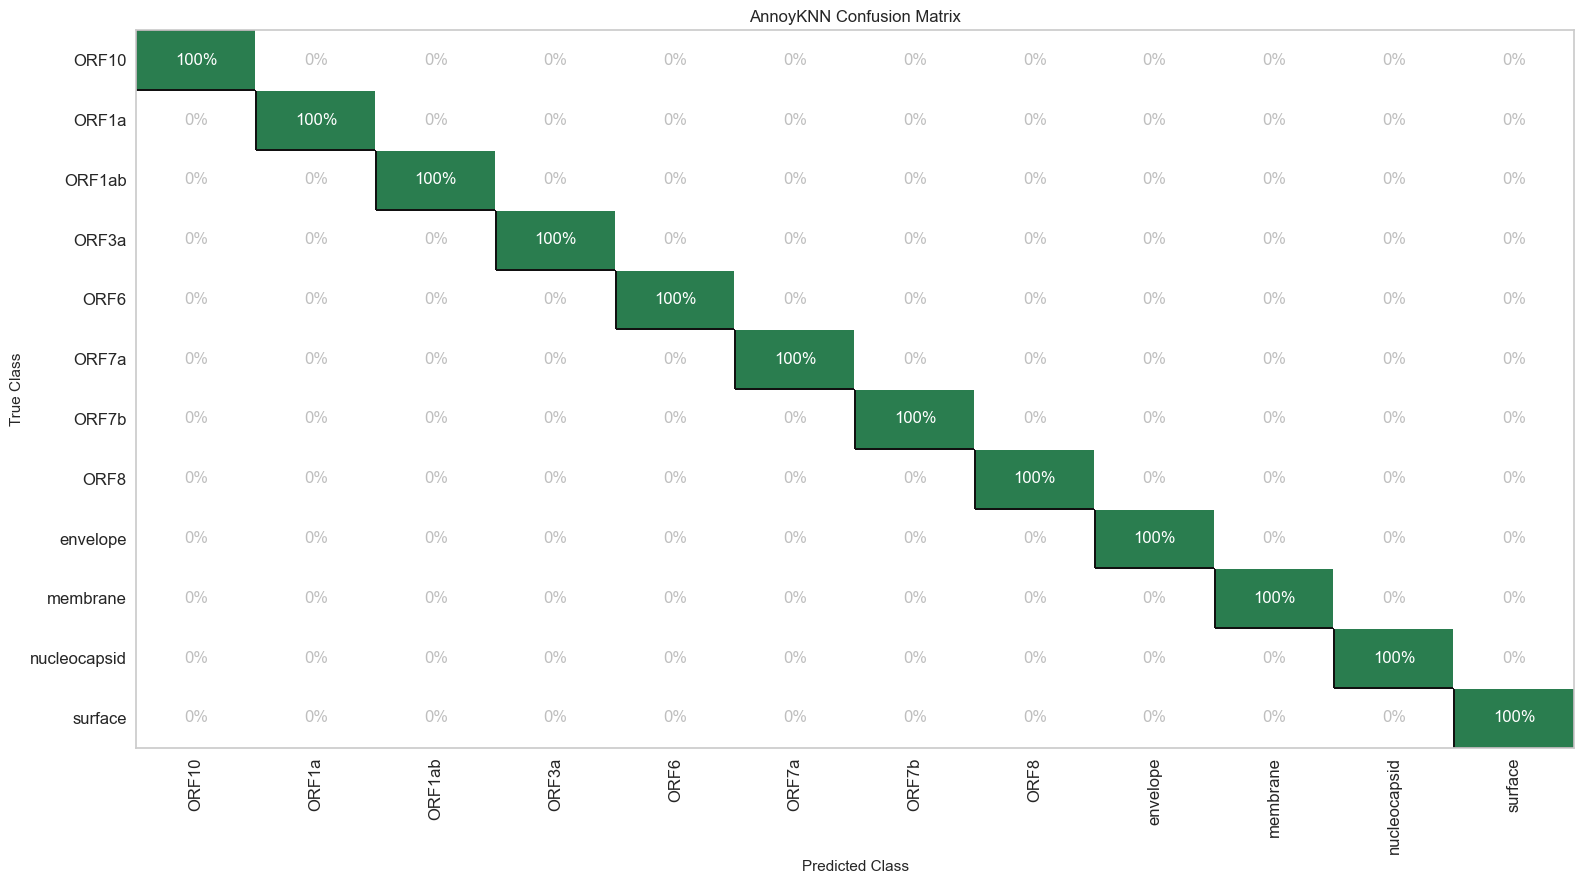

In [123]:
_ = plt.figure(figsize=(16, 9))

_ = confusion_matrix(classifier(clf.best_estimator_),
                     X_test,
                     enc.transform(y_test),
                     classes=labels2display,
                     cmap='Blues',
                     percent=True,
                     is_fitted=True)

Precision-recall curves for test data.

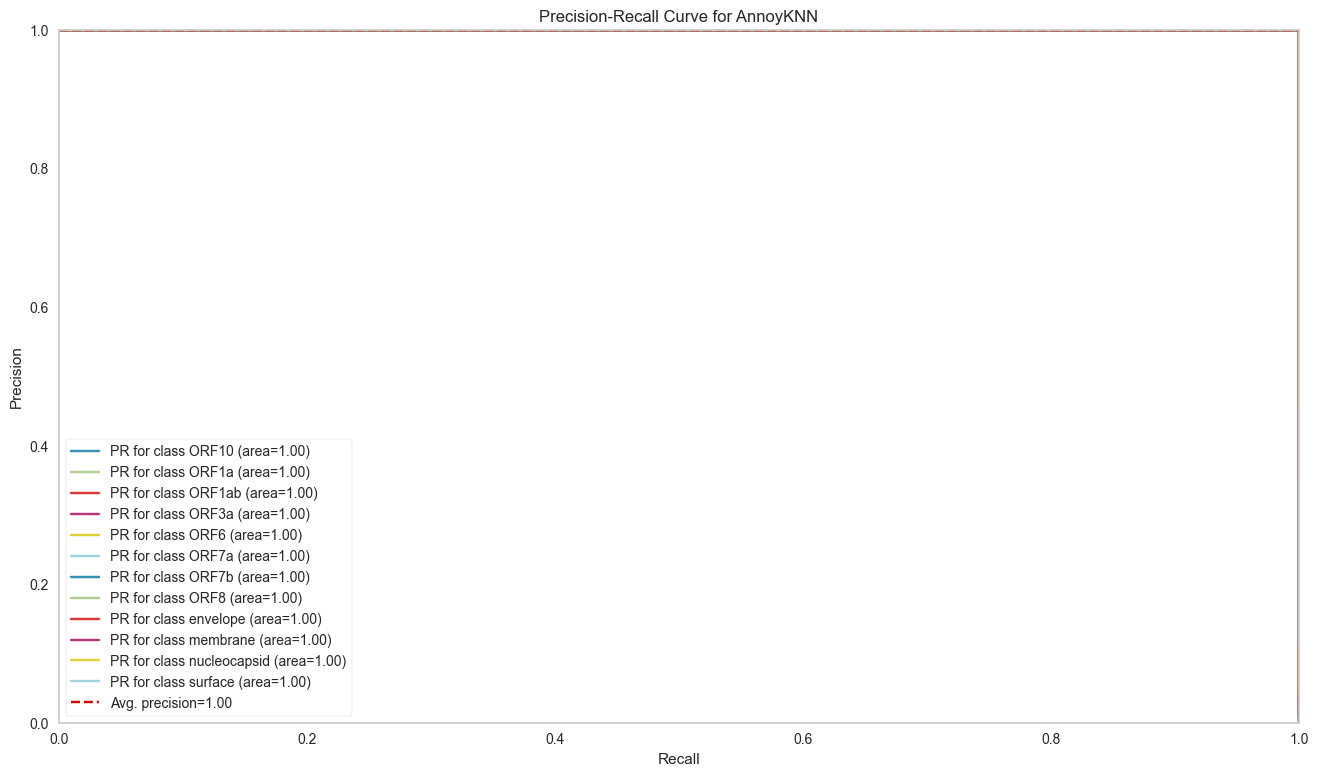

In [124]:
_ = plt.figure(figsize=(16, 9))

_ = precision_recall_curve(classifier(clf.best_estimator_),
                           X_test,
                           enc.transform(y_test),
                           classes=labels2display,
                           per_class=True)

Feature importances.
Since SHAP library dislikes my implementation of AnnoyKNN, and since it's so well documented that it makes debugging impossible, instead of using SHAP values, simple permutation importances will be calculated.

In [125]:
explainer = dx.Explainer(clf.best_estimator_,
                         X_test,
                         enc.transform(y_test),
                         precalculate=False,
                         label='Variable importance measures for AnnoyKNN',
                         verbose=False)

In [126]:
mp_clf = explainer.model_parts(keep_raw_permutations=False,
                               random_state=seed)

In [127]:
df = mp_clf.result.copy()
df = df.set_index('variable')
df = df.drop(index=['_baseline_', '_full_model_'])

df['dropout_loss'] = df['dropout_loss'] - df['dropout_loss'].min()

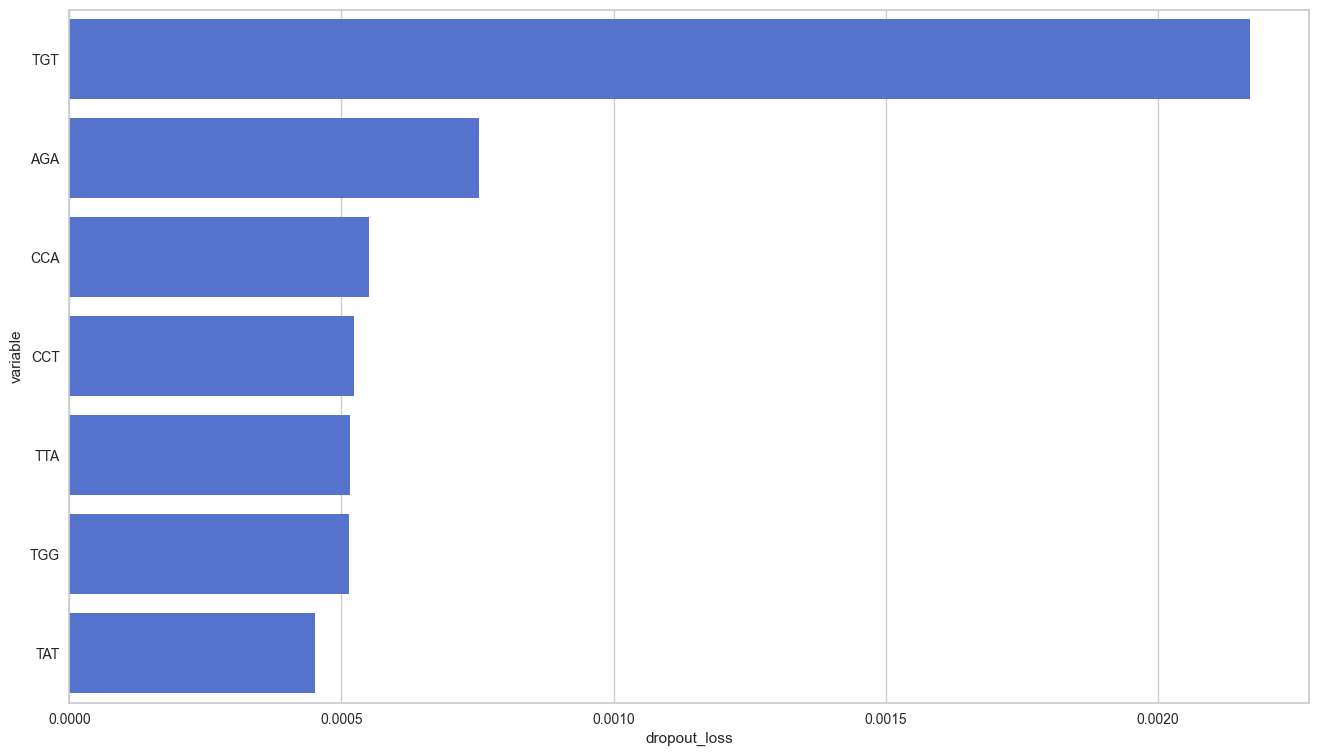

In [128]:
_ = plt.figure(figsize=(16, 9))

_ = sns.barplot(data=df.nlargest(n_features, 'dropout_loss'),
                y='variable',
                x='dropout_loss',
                orient='h',
                color='royalblue')

plt.show()

## Conclusion

After loading the data, features containing coding sequences and protein types have been extracted.
Then, we cleaned up the data by dropping the sequences with inappropriate number of nucleotides, with ambiguities, or belong to the classes represented by too few instances for reliable generalization.

The preparation phase has been completed by calculating codon usage frequencies and splitting the data into train and test sets.
A couple of other utilities have been prepared, before moving on to visualization phase.

During the visualization phase, we first looked at some general statistics.
That is, distribution of instances in different classes and features correlation test with target variable.
Then we looked at parallel coordinates and radar chart of a sampled data, and finally we looked at *t-SNE* projection of the training dataset.
The classes are extremely imbalanced, but they seem to be separable.
Then, we moved on to classification.

It appears that the data is linearly separable, as the linear-like classifiers such as *LinearSVC* and *DecisionTreeClassifier* achieved excellent results.
Even my custom built *AnnoyKNN* classifier, based on *Annoy* indexer, favored fewer neighbors and ignored distances, which implies that it prefers more linear separation of the data.

*ComplementaryNB* struggled with imbalanced data.
It simply failed to recognize the underrepresented classes.

The best results have been achieved with ensemble methods based on decision trees.
That doesn't come as a surprise, as even a single decision tree has achieved significant result.

This version of *KerasClassifier* appears to be broken.
In conjunction with *GASearchCV* it fails to report classification score, which is necessary for triggering early stopping callback.
Instead it returned NaN values.
When used with ordinary *GridSearchCV* it triggerd a number of warnings for variables that are even not accessible from *scikeras* API.

This version of *GASearchCV* does not parallelize at all, despite having n_jobs parameter.
If it has to evaluate *n* models during an iteration, and it has *n* cores available, I would expect that it would train each model in a separate process.
Instead, the models are trained one at a time, which is a serious flaw of this implementation.

This version of the visualization library *yellowbrick* is well imagined, but some of design decisions leave doubts.
Functions that generate confusion matrix, or precision-recall curve should not be able to fit the estimator internally.
Instead, in case when passed an estimator without prior training, these methods should throw an error.
The results generated by precision_recall_curve method are often inconsistent with other scores, which raises further doubts.
The library does not work with one-hot encoded targets, and the quick methods subset of its API is the functional API and the only truly useful part of the library.

Despite imbalance, the data classifies really well.
The majority of classifiers have achieved nearly $100\%$ accuracy, which is very rare.
Overall, out of seven reained models, six demonstrated excellent classification performance.